# High Freq Model

在这个notebook中，我们用训练高频模型。这里的代码做为模型更新线程的基础。

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time

pd.options.mode.chained_assignment = None

In [160]:
def to_pm(s):
    '''
    提取序列中的正负号 ( e.g. [-3, 2, -2, 3] -> [-1, 1, -1, 1] )
    s : array
    '''
    s_pm = np.zeros(s.shape)
    for i in range(len(s)):
        if s[i] > 0:
            s_pm[i] = 1
        if s[i] < 0:
            s_pm[i] = -1
    return s_pm

def calc_accuracy(pred, real):
    return (1 + np.sum(to_pm(pred) * to_pm(real))/len(pred))/2

def plotTVT(tr, trp, va, vap, te, tep):

    plt.figure(figsize = (15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(trp, tr, 'g.')
    plt.plot([-1,1], [-1,1], 'grey', ls = '--')
    plt.plot([-1,1], np.poly1d(np.polyfit(trp, tr, 1))([-1,1]), 'g--')
    plt.xlabel('pred')
    plt.ylabel('real')
    plt.title('training set')
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(vap, va, 'g.')
    plt.plot([-1,1], [-1,1], 'grey', ls = '--')
    plt.plot([-1,1], np.poly1d(np.polyfit(vap, va, 1))([-1,1]), 'g--')
    plt.xlabel('pred')
    plt.ylabel('real')
    plt.title('validation set')
    plt.grid()
    
    plt.subplot(1, 3, 3)
    plt.plot(trp, tr, 'g.')
    plt.plot([-1,1], [-1,1], 'grey', ls = '--')
    plt.plot([-1,1], np.poly1d(np.polyfit(tep, te, 1))([-1,1]), 'g--')
    plt.xlabel('pred')
    plt.ylabel('real')
    plt.title('test set')
    plt.grid()
    
    plt.show()

In [137]:
alphasbasic = pd.read_csv('data/alphasbasic.csv').set_index('Unnamed: 0')

In [139]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(alphasbasic.loc[: ,'obj1':].corr())

In [146]:
sub = alphasbasic.loc[:,'obj10':] \
    .replace([np.inf, -np.inf], np.nan).dropna()  # get rid of nans before training
sub

,obj10,obj5,SOIR1,SOIR2,SOIR3,SOIR4,SOIR5,SOIR6,SOIR7,SOIR8,...,MPC4,MPC5,MPC6,MPC7,MPC8,MPC9,MPC10,momentum5,momentum10,momentum20
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
10000,-0.012014,0.001441,0.629630,-0.066667,0.272727,0.809524,-0.785714,0.617021,0.217391,0.870968,...,0.007778,0.003874,0.002418,-0.001445,0.003874,0.001933,-0.001445,0.003874,-0.001445,-0.026303
10001,-0.002904,0.000000,-0.600000,0.333333,-0.941199,-0.777778,0.906443,-0.075474,0.103451,1.000000,...,-0.001158,-0.001158,-0.001158,-0.001158,-0.000001,-0.000001,-0.000001,-0.001157,0.000000,-0.001745
10002,-0.003885,0.001661,-0.500000,0.272727,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.009530,0.010104,0.008969,0.009530,0.007839,0.005582,0.006709,0.010105,0.006709,0.010666
10003,0.016331,0.021804,-0.822795,-0.764710,-0.684213,-0.676468,0.869568,-0.951022,-0.798663,-0.061994,...,-0.008087,0.000000,0.008255,0.008255,0.009654,0.009654,0.009654,0.000000,0.009658,0.023778
10004,-0.002540,-0.000423,-0.333359,0.111145,0.904800,-0.023247,-0.780838,-0.593228,-0.911117,-0.757583,...,-0.001695,0.002126,0.001700,0.000425,0.000000,-0.000848,-0.000848,0.002126,-0.000848,0.001700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554495,0.011429,0.006723,0.840076,0.921651,-0.217425,0.250037,0.100417,0.428632,0.923156,0.485685,...,0.001348,0.002022,0.002563,0.002969,0.004596,0.004732,0.005412,0.002022,0.005411,0.010881
1554496,0.000000,0.000000,-0.501977,0.359743,0.270270,-0.039578,-0.011858,0.396908,0.470371,-0.888112,...,0.000000,0.000000,0.000000,0.000000,0.001165,0.004702,0.000000,0.000000,0.000000,0.005884
1554497,0.001347,0.001010,0.253328,-0.319141,-0.402980,0.456794,0.250000,-0.592160,-0.283848,-0.111689,...,0.000000,0.000000,0.000134,0.000673,0.000673,0.000673,0.000807,0.000000,0.000673,0.000673


In [149]:
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

data_shuf = shuffle(sub, random_state = 2020)

y10_train = data_shuf.iloc[:1000000, 0].values
y5_train = data_shuf.iloc[:1000000, 1].values
X_train = data_shuf.iloc[:1000000, 2:].values
y10_validate = data_shuf.iloc[1000000:1300000, 0].values
y5_validate = data_shuf.iloc[1000000:1300000, 1].values
X_validate = data_shuf.iloc[1000000:1300000, 2:].values
y10_test = data_shuf.iloc[1300000:, 0].values
y5_test = data_shuf.iloc[1300000:, 1].values
X_test = data_shuf.iloc[1300000:, 2:].values

In [148]:
y10 = data_shuf.iloc[:, 0].values
y5 = data_shuf.iloc[:, 1].values
X = data_shuf.iloc[:, 2:].values

# SKLEARN gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [150]:
gb10 = GradientBoostingRegressor(loss = 'huber', 
                               learning_rate = 0.25, 
                               n_estimators = 25, 
                               verbose = True, 
                               random_state = 2020)

gb10.fit(X_train, y10_train)

      Iter       Train Loss   Remaining Time 
         1           0.0000            2.93m
         2           0.0000            2.94m
         3           0.0000            2.87m
         4           0.0000            2.78m
         5           0.0000            2.62m
         6           0.0000            2.46m
         7           0.0000            2.31m
         8           0.0000            2.21m
         9           0.0000            2.09m
        10           0.0000            1.97m
        20           0.0000           39.25s


GradientBoostingRegressor(learning_rate=0.25, loss='huber', n_estimators=25,
                          random_state=2020, verbose=True)

In [152]:
y10_train_pred = gb10.predict(X_train)
print("Training MSE: " + str(mean_squared_error(y10_train_pred, y10_train)))
print("Training accuracy: " + str(calc_accuracy(y10_train_pred, y10_train)))

Training MSE: 0.0003946998981084597
Training accuracy: 0.5323275


In [154]:
y10_validate_pred = gb10.predict(X_validate)
print("Validation MSE: " + str(mean_squared_error(y10_validate_pred, y10_validate)))
print("Validation accuracy: " + str(calc_accuracy(y10_validate_pred, y10_validate)))

Validation MSE: 0.00039136087154303424
Validation accuracy: 0.5292816666666667


In [295]:
y10_test_pred = gb10.predict(X_test)
print("Test MSE: " + str(mean_squared_error(y10_test_pred, y10_test)))
print("Test accuracy: " + str(calc_accuracy(y10_test_pred, y10_test)))

Test MSE: 0.0003783468325941107
Test accuracy: 0.530161554192229


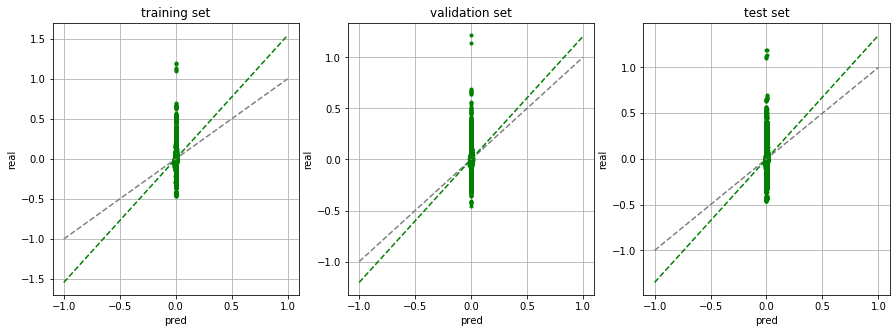

In [290]:
plotTVT(y10_train, y10_train_pred, 
        y10_validate, y10_validate_pred,
        y10_test, y10_test_pred)

In [288]:
# (1544500 - 1300000) * 15/500 = 7335

(np.mean(y10_test[y10_test_pred.argsort()[-7335:]]), \
np.mean(y10_test[y10_test_pred.argsort()[:7335]]))

(0.003352970686952098, -0.0019241699893400876)

In [162]:
gb5 = GradientBoostingRegressor(loss = 'huber', 
                               learning_rate = 0.25, 
                               n_estimators = 25, 
                               verbose = True, 
                               random_state = 2020)

gb5.fit(X_train, y5_train)

      Iter       Train Loss   Remaining Time 
         1           0.0000            3.11m
         2           0.0000            3.00m
         3           0.0000            2.87m
         4           0.0000            2.69m
         5           0.0000            2.54m
         6           0.0000            2.43m
         7           0.0000            2.30m
         8           0.0000            2.19m
         9           0.0000            2.06m
        10           0.0000            1.94m
        20           0.0000           38.31s


GradientBoostingRegressor(learning_rate=0.25, loss='huber', n_estimators=25,
                          random_state=2020, verbose=True)

In [163]:
y5_train_pred = gb5.predict(X_train)
print("Training MSE: " + str(mean_squared_error(y5_train_pred, y5_train)))
print("Training accuracy: " + str(calc_accuracy(y5_train_pred, y5_train)))

Training MSE: 0.00020252892217924033
Training accuracy: 0.530372


In [164]:
y5_validate_pred = gb5.predict(X_validate)
print("Validation MSE: " + str(mean_squared_error(y5_validate_pred, y5_validate)))
print("Validation accuracy: " + str(calc_accuracy(y5_validate_pred, y5_validate)))

Validation MSE: 0.00019651377859640468
Validation accuracy: 0.5278183333333333


In [294]:
y5_test_pred = gb5.predict(X_test)
print("Test MSE: " + str(mean_squared_error(y5_test_pred, y5_test)))
print("Test accuracy: " + str(calc_accuracy(y5_test_pred, y5_test)))

Test MSE: 0.0001839940364124622
Test accuracy: 0.5276850715746422


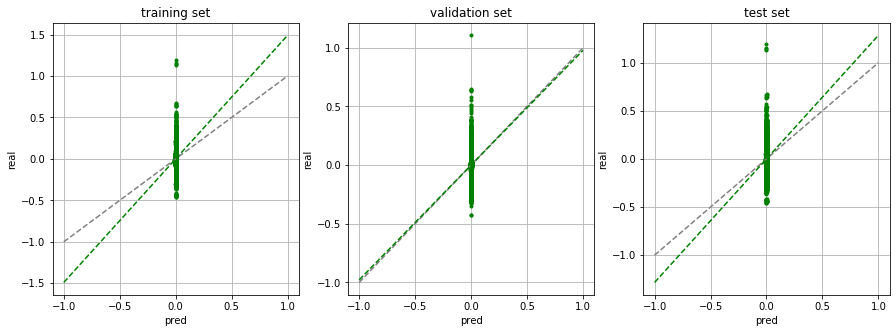

In [166]:
plotTVT(y5_train, y5_train_pred, 
        y5_validate, y5_validate_pred,
        y5_test, y5_test_pred)

In [308]:
# (1544500 - 1300000) * 15/500 = 7335

(np.mean(y5_test[y5_test_pred.argsort()[-7335:]]), \
np.mean(y5_test[y5_test_pred.argsort()[:7335]]))

(0.0017366287602270174, -0.0009369708389330015)

# LIGHTGBM gradient boosting

In [170]:
import lightgbm as lgb

In [228]:
# grid search

import itertools

l_num_leaves = [40,60,80,100,120]
l_learning_rate = [0.05, 0.1, 0.2, 0.4, 0.8]
l_num_boost_round = [100, 300, 500]
l_feature_fraction = [0.5, 1]

In [211]:
l_acc = np.zeros(0)

for x in itertools.product(l_num_leaves, l_learning_rate, l_num_boost_round, l_feature_fraction):
    
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'huber'},
        'num_leaves': x[0],
        'learning_rate': x[1],
        'num_boost_round' : x[2],
        'feature_fraction': x[3],
        'bagging_fraction': 1,
        'bagging_freq': 1,
        'verbose': -1
    }
    lgb10_train = lgb.Dataset(X_train, y10_train)
    lgb10_eval = lgb.Dataset(X_validate, y10_validate, reference = lgb10_train)
    lgbm10 = lgb.train(params, lgb10_train, valid_sets = lgb10_eval)
    y10_test_lgbmpred = lgbm10.predict(X_test)
    
    l_acc = np.append(l_acc, calc_accuracy(y10_test_lgbmpred, y10_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm-3.2.1-py3.6-macosx-10.9-x86_64.egg/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's huber: 0.000195663
[2]	valid_0's huber: 0.000195632
[3]	valid_0's huber: 0.000195618
[4]	valid_0's huber: 0.000195608
[5]	valid_0's huber: 0.000195583
[6]	valid_0's huber: 0.000195554
[7]	valid_0's huber: 0.000195531
[8]	valid_0's huber: 0.000195521
[9]	valid_0's huber: 0.000195496
[10]	valid_0's huber: 0.000195487
[11]	valid_0's huber: 0.000195471
[12]	valid_0's huber: 0.000195459
[13]	valid_0's huber: 0.000195451
[14]	valid_0's huber: 0.000195443
[15]	valid_0's huber: 0.000195431
[16]	valid_0's huber: 0.000195411
[17]	valid_0's huber: 0.000195398
[18]	valid_0's huber: 0.000195384
[19]	valid_0's huber: 0.000195378
[20]	valid_0's huber: 0.000195359
[21]	valid_0's huber: 0.000195341
[22]	valid_0's huber: 0.000195323
[23]	valid_0's huber: 0.00019531
[24]	valid_0's huber: 0.000195299
[25]	valid_0's huber: 0.000195264
[26]	valid_0's huber: 0.000195251
[27]	valid_0's huber: 0.000195241
[28]	valid_0's huber: 0.000195234
[29]	valid_0's huber: 0.000195228
[30]	valid_0's huber: 0.

[52]	valid_0's huber: 0.000195086
[53]	valid_0's huber: 0.000195087
[54]	valid_0's huber: 0.000195086
[55]	valid_0's huber: 0.000195076
[56]	valid_0's huber: 0.000195075
[57]	valid_0's huber: 0.000195074
[58]	valid_0's huber: 0.000195075
[59]	valid_0's huber: 0.000195071
[60]	valid_0's huber: 0.00019507
[61]	valid_0's huber: 0.000195069
[62]	valid_0's huber: 0.000195069
[63]	valid_0's huber: 0.000195046
[64]	valid_0's huber: 0.000195035
[65]	valid_0's huber: 0.000195035
[66]	valid_0's huber: 0.000195033
[67]	valid_0's huber: 0.00019503
[68]	valid_0's huber: 0.000195029
[69]	valid_0's huber: 0.000195027
[70]	valid_0's huber: 0.000195025
[71]	valid_0's huber: 0.000195015
[72]	valid_0's huber: 0.000195014
[73]	valid_0's huber: 0.000195015
[74]	valid_0's huber: 0.000195009
[75]	valid_0's huber: 0.000195009
[76]	valid_0's huber: 0.000195007
[77]	valid_0's huber: 0.000195005
[78]	valid_0's huber: 0.000195002
[79]	valid_0's huber: 0.000195003
[80]	valid_0's huber: 0.000195002
[81]	valid_0's h

[292]	valid_0's huber: 0.000194491
[293]	valid_0's huber: 0.00019449
[294]	valid_0's huber: 0.000194482
[295]	valid_0's huber: 0.000194474
[296]	valid_0's huber: 0.000194471
[297]	valid_0's huber: 0.000194471
[298]	valid_0's huber: 0.00019447
[299]	valid_0's huber: 0.000194471
[300]	valid_0's huber: 0.00019447
[1]	valid_0's huber: 0.000195645
[2]	valid_0's huber: 0.000195611
[3]	valid_0's huber: 0.00019558
[4]	valid_0's huber: 0.000195554
[5]	valid_0's huber: 0.000195531
[6]	valid_0's huber: 0.000195506
[7]	valid_0's huber: 0.000195481
[8]	valid_0's huber: 0.000195462
[9]	valid_0's huber: 0.000195434
[10]	valid_0's huber: 0.000195421
[11]	valid_0's huber: 0.000195409
[12]	valid_0's huber: 0.000195388
[13]	valid_0's huber: 0.000195368
[14]	valid_0's huber: 0.000195345
[15]	valid_0's huber: 0.000195334
[16]	valid_0's huber: 0.000195292
[17]	valid_0's huber: 0.000195283
[18]	valid_0's huber: 0.000195276
[19]	valid_0's huber: 0.000195265
[20]	valid_0's huber: 0.00019524
[21]	valid_0's hube

[240]	valid_0's huber: 0.00019441
[241]	valid_0's huber: 0.000194409
[242]	valid_0's huber: 0.0001944
[243]	valid_0's huber: 0.000194391
[244]	valid_0's huber: 0.000194384
[245]	valid_0's huber: 0.000194383
[246]	valid_0's huber: 0.000194384
[247]	valid_0's huber: 0.000194382
[248]	valid_0's huber: 0.000194381
[249]	valid_0's huber: 0.000194383
[250]	valid_0's huber: 0.000194385
[251]	valid_0's huber: 0.000194384
[252]	valid_0's huber: 0.000194383
[253]	valid_0's huber: 0.00019438
[254]	valid_0's huber: 0.000194377
[255]	valid_0's huber: 0.000194379
[256]	valid_0's huber: 0.000194377
[257]	valid_0's huber: 0.000194377
[258]	valid_0's huber: 0.000194376
[259]	valid_0's huber: 0.000194368
[260]	valid_0's huber: 0.000194359
[261]	valid_0's huber: 0.000194359
[262]	valid_0's huber: 0.000194347
[263]	valid_0's huber: 0.000194332
[264]	valid_0's huber: 0.000194332
[265]	valid_0's huber: 0.000194323
[266]	valid_0's huber: 0.000194324
[267]	valid_0's huber: 0.000194324
[268]	valid_0's huber: 0

[194]	valid_0's huber: 0.000194757
[195]	valid_0's huber: 0.000194758
[196]	valid_0's huber: 0.000194753
[197]	valid_0's huber: 0.000194745
[198]	valid_0's huber: 0.00019474
[199]	valid_0's huber: 0.000194741
[200]	valid_0's huber: 0.00019474
[201]	valid_0's huber: 0.000194734
[202]	valid_0's huber: 0.000194731
[203]	valid_0's huber: 0.000194734
[204]	valid_0's huber: 0.000194732
[205]	valid_0's huber: 0.000194733
[206]	valid_0's huber: 0.00019472
[207]	valid_0's huber: 0.00019471
[208]	valid_0's huber: 0.00019471
[209]	valid_0's huber: 0.000194709
[210]	valid_0's huber: 0.00019469
[211]	valid_0's huber: 0.00019469
[212]	valid_0's huber: 0.000194686
[213]	valid_0's huber: 0.000194683
[214]	valid_0's huber: 0.000194683
[215]	valid_0's huber: 0.000194683
[216]	valid_0's huber: 0.000194682
[217]	valid_0's huber: 0.000194684
[218]	valid_0's huber: 0.000194682
[219]	valid_0's huber: 0.000194681
[220]	valid_0's huber: 0.000194681
[221]	valid_0's huber: 0.000194677
[222]	valid_0's huber: 0.00

[442]	valid_0's huber: 0.00019411
[443]	valid_0's huber: 0.00019411
[444]	valid_0's huber: 0.000194107
[445]	valid_0's huber: 0.000194109
[446]	valid_0's huber: 0.000194108
[447]	valid_0's huber: 0.000194108
[448]	valid_0's huber: 0.000194109
[449]	valid_0's huber: 0.000194108
[450]	valid_0's huber: 0.000194107
[451]	valid_0's huber: 0.000194086
[452]	valid_0's huber: 0.000194083
[453]	valid_0's huber: 0.000194084
[454]	valid_0's huber: 0.000194084
[455]	valid_0's huber: 0.00019408
[456]	valid_0's huber: 0.000194071
[457]	valid_0's huber: 0.000194068
[458]	valid_0's huber: 0.000194068
[459]	valid_0's huber: 0.000194067
[460]	valid_0's huber: 0.000194067
[461]	valid_0's huber: 0.000194066
[462]	valid_0's huber: 0.000194065
[463]	valid_0's huber: 0.000194045
[464]	valid_0's huber: 0.000194043
[465]	valid_0's huber: 0.000194041
[466]	valid_0's huber: 0.000194037
[467]	valid_0's huber: 0.000194039
[468]	valid_0's huber: 0.000194037
[469]	valid_0's huber: 0.000194037
[470]	valid_0's huber: 

[186]	valid_0's huber: 0.000194607
[187]	valid_0's huber: 0.000194605
[188]	valid_0's huber: 0.000194587
[189]	valid_0's huber: 0.000194586
[190]	valid_0's huber: 0.000194584
[191]	valid_0's huber: 0.000194581
[192]	valid_0's huber: 0.000194573
[193]	valid_0's huber: 0.000194558
[194]	valid_0's huber: 0.000194557
[195]	valid_0's huber: 0.000194558
[196]	valid_0's huber: 0.000194544
[197]	valid_0's huber: 0.000194537
[198]	valid_0's huber: 0.00019453
[199]	valid_0's huber: 0.000194531
[200]	valid_0's huber: 0.00019453
[201]	valid_0's huber: 0.000194529
[202]	valid_0's huber: 0.000194526
[203]	valid_0's huber: 0.000194523
[204]	valid_0's huber: 0.000194523
[205]	valid_0's huber: 0.000194523
[206]	valid_0's huber: 0.000194513
[207]	valid_0's huber: 0.000194506
[208]	valid_0's huber: 0.000194505
[209]	valid_0's huber: 0.000194505
[210]	valid_0's huber: 0.000194503
[211]	valid_0's huber: 0.000194498
[212]	valid_0's huber: 0.000194499
[213]	valid_0's huber: 0.000194491
[214]	valid_0's huber:

[424]	valid_0's huber: 0.000193875
[425]	valid_0's huber: 0.000193857
[426]	valid_0's huber: 0.000193859
[427]	valid_0's huber: 0.000193858
[428]	valid_0's huber: 0.000193858
[429]	valid_0's huber: 0.000193859
[430]	valid_0's huber: 0.000193853
[431]	valid_0's huber: 0.000193853
[432]	valid_0's huber: 0.000193848
[433]	valid_0's huber: 0.000193842
[434]	valid_0's huber: 0.000193833
[435]	valid_0's huber: 0.000193827
[436]	valid_0's huber: 0.000193819
[437]	valid_0's huber: 0.000193819
[438]	valid_0's huber: 0.000193818
[439]	valid_0's huber: 0.000193818
[440]	valid_0's huber: 0.000193813
[441]	valid_0's huber: 0.000193816
[442]	valid_0's huber: 0.000193815
[443]	valid_0's huber: 0.000193816
[444]	valid_0's huber: 0.000193816
[445]	valid_0's huber: 0.000193812
[446]	valid_0's huber: 0.000193814
[447]	valid_0's huber: 0.00019381
[448]	valid_0's huber: 0.000193811
[449]	valid_0's huber: 0.000193807
[450]	valid_0's huber: 0.000193796
[451]	valid_0's huber: 0.000193797
[452]	valid_0's huber

[64]	valid_0's huber: 0.000194917
[65]	valid_0's huber: 0.000194896
[66]	valid_0's huber: 0.000194896
[67]	valid_0's huber: 0.000194889
[68]	valid_0's huber: 0.000194849
[69]	valid_0's huber: 0.000194852
[70]	valid_0's huber: 0.000194852
[71]	valid_0's huber: 0.000194849
[72]	valid_0's huber: 0.000194844
[73]	valid_0's huber: 0.000194845
[74]	valid_0's huber: 0.000194826
[75]	valid_0's huber: 0.000194829
[76]	valid_0's huber: 0.000194829
[77]	valid_0's huber: 0.000194827
[78]	valid_0's huber: 0.000194827
[79]	valid_0's huber: 0.000194827
[80]	valid_0's huber: 0.000194829
[81]	valid_0's huber: 0.000194829
[82]	valid_0's huber: 0.000194826
[83]	valid_0's huber: 0.000194826
[84]	valid_0's huber: 0.000194826
[85]	valid_0's huber: 0.00019482
[86]	valid_0's huber: 0.000194818
[87]	valid_0's huber: 0.000194817
[88]	valid_0's huber: 0.000194805
[89]	valid_0's huber: 0.00019481
[90]	valid_0's huber: 0.000194788
[91]	valid_0's huber: 0.000194783
[92]	valid_0's huber: 0.000194777
[93]	valid_0's h

[217]	valid_0's huber: 0.000194138
[218]	valid_0's huber: 0.000194129
[219]	valid_0's huber: 0.000194128
[220]	valid_0's huber: 0.000194126
[221]	valid_0's huber: 0.000194127
[222]	valid_0's huber: 0.000194128
[223]	valid_0's huber: 0.000194125
[224]	valid_0's huber: 0.000194123
[225]	valid_0's huber: 0.00019409
[226]	valid_0's huber: 0.000194092
[227]	valid_0's huber: 0.000194094
[228]	valid_0's huber: 0.000194094
[229]	valid_0's huber: 0.000194087
[230]	valid_0's huber: 0.000194088
[231]	valid_0's huber: 0.000194085
[232]	valid_0's huber: 0.00019408
[233]	valid_0's huber: 0.000194083
[234]	valid_0's huber: 0.000194065
[235]	valid_0's huber: 0.000194066
[236]	valid_0's huber: 0.000194065
[237]	valid_0's huber: 0.000194052
[238]	valid_0's huber: 0.000194042
[239]	valid_0's huber: 0.000194038
[240]	valid_0's huber: 0.000194036
[241]	valid_0's huber: 0.000194037
[242]	valid_0's huber: 0.000194034
[243]	valid_0's huber: 0.00019403
[244]	valid_0's huber: 0.000194026
[245]	valid_0's huber: 

[166]	valid_0's huber: 0.000194395
[167]	valid_0's huber: 0.000194395
[168]	valid_0's huber: 0.000194393
[169]	valid_0's huber: 0.000194383
[170]	valid_0's huber: 0.000194367
[171]	valid_0's huber: 0.000194365
[172]	valid_0's huber: 0.000194364
[173]	valid_0's huber: 0.000194366
[174]	valid_0's huber: 0.000194368
[175]	valid_0's huber: 0.000194367
[176]	valid_0's huber: 0.000194345
[177]	valid_0's huber: 0.000194341
[178]	valid_0's huber: 0.000194347
[179]	valid_0's huber: 0.000194344
[180]	valid_0's huber: 0.000194319
[181]	valid_0's huber: 0.000194283
[182]	valid_0's huber: 0.000194283
[183]	valid_0's huber: 0.000194283
[184]	valid_0's huber: 0.000194285
[185]	valid_0's huber: 0.000194262
[186]	valid_0's huber: 0.000194252
[187]	valid_0's huber: 0.000194246
[188]	valid_0's huber: 0.00019425
[189]	valid_0's huber: 0.000194254
[190]	valid_0's huber: 0.000194253
[191]	valid_0's huber: 0.000194255
[192]	valid_0's huber: 0.000194252
[193]	valid_0's huber: 0.000194256
[194]	valid_0's huber

[118]	valid_0's huber: 0.00019476
[119]	valid_0's huber: 0.000194759
[120]	valid_0's huber: 0.000194753
[121]	valid_0's huber: 0.000194751
[122]	valid_0's huber: 0.000194746
[123]	valid_0's huber: 0.000194741
[124]	valid_0's huber: 0.000194741
[125]	valid_0's huber: 0.000194742
[126]	valid_0's huber: 0.000194718
[127]	valid_0's huber: 0.000194714
[128]	valid_0's huber: 0.000194721
[129]	valid_0's huber: 0.000194709
[130]	valid_0's huber: 0.000194706
[131]	valid_0's huber: 0.000194701
[132]	valid_0's huber: 0.000194702
[133]	valid_0's huber: 0.0001947
[134]	valid_0's huber: 0.0001947
[135]	valid_0's huber: 0.000194704
[136]	valid_0's huber: 0.000194705
[137]	valid_0's huber: 0.000194701
[138]	valid_0's huber: 0.000194702
[139]	valid_0's huber: 0.000194702
[140]	valid_0's huber: 0.000194702
[141]	valid_0's huber: 0.000194698
[142]	valid_0's huber: 0.000194677
[143]	valid_0's huber: 0.000194661
[144]	valid_0's huber: 0.000194663
[145]	valid_0's huber: 0.000194607
[146]	valid_0's huber: 0.

[358]	valid_0's huber: 0.000193451
[359]	valid_0's huber: 0.00019345
[360]	valid_0's huber: 0.000193451
[361]	valid_0's huber: 0.000193435
[362]	valid_0's huber: 0.000193426
[363]	valid_0's huber: 0.000193429
[364]	valid_0's huber: 0.000193428
[365]	valid_0's huber: 0.00019343
[366]	valid_0's huber: 0.000193425
[367]	valid_0's huber: 0.000193429
[368]	valid_0's huber: 0.000193427
[369]	valid_0's huber: 0.000193427
[370]	valid_0's huber: 0.000193426
[371]	valid_0's huber: 0.000193427
[372]	valid_0's huber: 0.000193429
[373]	valid_0's huber: 0.000193431
[374]	valid_0's huber: 0.00019343
[375]	valid_0's huber: 0.000193425
[376]	valid_0's huber: 0.000193431
[377]	valid_0's huber: 0.000193431
[378]	valid_0's huber: 0.000193419
[379]	valid_0's huber: 0.000193416
[380]	valid_0's huber: 0.000193414
[381]	valid_0's huber: 0.000193408
[382]	valid_0's huber: 0.000193406
[383]	valid_0's huber: 0.000193412
[384]	valid_0's huber: 0.000193409
[385]	valid_0's huber: 0.000193407
[386]	valid_0's huber: 

[105]	valid_0's huber: 0.000194661
[106]	valid_0's huber: 0.000194658
[107]	valid_0's huber: 0.000194651
[108]	valid_0's huber: 0.000194646
[109]	valid_0's huber: 0.000194635
[110]	valid_0's huber: 0.000194633
[111]	valid_0's huber: 0.000194631
[112]	valid_0's huber: 0.000194632
[113]	valid_0's huber: 0.00019462
[114]	valid_0's huber: 0.000194609
[115]	valid_0's huber: 0.000194608
[116]	valid_0's huber: 0.000194608
[117]	valid_0's huber: 0.000194613
[118]	valid_0's huber: 0.000194609
[119]	valid_0's huber: 0.000194579
[120]	valid_0's huber: 0.000194571
[121]	valid_0's huber: 0.000194571
[122]	valid_0's huber: 0.000194576
[123]	valid_0's huber: 0.000194579
[124]	valid_0's huber: 0.000194586
[125]	valid_0's huber: 0.000194581
[126]	valid_0's huber: 0.000194577
[127]	valid_0's huber: 0.000194566
[128]	valid_0's huber: 0.000194567
[129]	valid_0's huber: 0.00019457
[130]	valid_0's huber: 0.000194557
[131]	valid_0's huber: 0.000194558
[132]	valid_0's huber: 0.000194537
[133]	valid_0's huber:

[340]	valid_0's huber: 0.000193598
[341]	valid_0's huber: 0.000193595
[342]	valid_0's huber: 0.000193592
[343]	valid_0's huber: 0.00019359
[344]	valid_0's huber: 0.000193592
[345]	valid_0's huber: 0.000193536
[346]	valid_0's huber: 0.000193533
[347]	valid_0's huber: 0.000193532
[348]	valid_0's huber: 0.000193525
[349]	valid_0's huber: 0.000193526
[350]	valid_0's huber: 0.000193521
[351]	valid_0's huber: 0.000193505
[352]	valid_0's huber: 0.000193501
[353]	valid_0's huber: 0.000193489
[354]	valid_0's huber: 0.000193491
[355]	valid_0's huber: 0.000193495
[356]	valid_0's huber: 0.000193491
[357]	valid_0's huber: 0.000193492
[358]	valid_0's huber: 0.000193494
[359]	valid_0's huber: 0.00019349
[360]	valid_0's huber: 0.000193483
[361]	valid_0's huber: 0.000193471
[362]	valid_0's huber: 0.000193444
[363]	valid_0's huber: 0.000193443
[364]	valid_0's huber: 0.000193441
[365]	valid_0's huber: 0.00019344
[366]	valid_0's huber: 0.000193422
[367]	valid_0's huber: 0.000193426
[368]	valid_0's huber: 

[82]	valid_0's huber: 0.000194824
[83]	valid_0's huber: 0.00019477
[84]	valid_0's huber: 0.000194728
[85]	valid_0's huber: 0.000194729
[86]	valid_0's huber: 0.000194721
[87]	valid_0's huber: 0.000194724
[88]	valid_0's huber: 0.000194721
[89]	valid_0's huber: 0.000194656
[90]	valid_0's huber: 0.000194629
[91]	valid_0's huber: 0.000194625
[92]	valid_0's huber: 0.00019463
[93]	valid_0's huber: 0.000194619
[94]	valid_0's huber: 0.000194584
[95]	valid_0's huber: 0.000194587
[96]	valid_0's huber: 0.000194586
[97]	valid_0's huber: 0.00019459
[98]	valid_0's huber: 0.000194585
[99]	valid_0's huber: 0.0001946
[100]	valid_0's huber: 0.000194598
[1]	valid_0's huber: 0.00019555
[2]	valid_0's huber: 0.000195459
[3]	valid_0's huber: 0.000195394
[4]	valid_0's huber: 0.000195349
[5]	valid_0's huber: 0.000195275
[6]	valid_0's huber: 0.000195161
[7]	valid_0's huber: 0.000195161
[8]	valid_0's huber: 0.000195144
[9]	valid_0's huber: 0.000195125
[10]	valid_0's huber: 0.000195126
[11]	valid_0's huber: 0.0001

[135]	valid_0's huber: 0.000194349
[136]	valid_0's huber: 0.000194344
[137]	valid_0's huber: 0.000194333
[138]	valid_0's huber: 0.000194339
[139]	valid_0's huber: 0.000194323
[140]	valid_0's huber: 0.00019432
[141]	valid_0's huber: 0.000194318
[142]	valid_0's huber: 0.000194306
[143]	valid_0's huber: 0.000194301
[144]	valid_0's huber: 0.000194307
[145]	valid_0's huber: 0.000194314
[146]	valid_0's huber: 0.000194321
[147]	valid_0's huber: 0.000194327
[148]	valid_0's huber: 0.000194293
[149]	valid_0's huber: 0.000194202
[150]	valid_0's huber: 0.000194201
[151]	valid_0's huber: 0.000194188
[152]	valid_0's huber: 0.000194188
[153]	valid_0's huber: 0.000194191
[154]	valid_0's huber: 0.000194194
[155]	valid_0's huber: 0.000194189
[156]	valid_0's huber: 0.000194191
[157]	valid_0's huber: 0.000194197
[158]	valid_0's huber: 0.000194204
[159]	valid_0's huber: 0.000194212
[160]	valid_0's huber: 0.000194206
[161]	valid_0's huber: 0.000194201
[162]	valid_0's huber: 0.000194184
[163]	valid_0's huber

[77]	valid_0's huber: 0.000194725
[78]	valid_0's huber: 0.000194701
[79]	valid_0's huber: 0.000194698
[80]	valid_0's huber: 0.000194698
[81]	valid_0's huber: 0.000194698
[82]	valid_0's huber: 0.00019468
[83]	valid_0's huber: 0.000194684
[84]	valid_0's huber: 0.000194689
[85]	valid_0's huber: 0.000194684
[86]	valid_0's huber: 0.00019469
[87]	valid_0's huber: 0.0001947
[88]	valid_0's huber: 0.0001947
[89]	valid_0's huber: 0.000194599
[90]	valid_0's huber: 0.000194602
[91]	valid_0's huber: 0.000194607
[92]	valid_0's huber: 0.00019458
[93]	valid_0's huber: 0.000194558
[94]	valid_0's huber: 0.000194549
[95]	valid_0's huber: 0.000194532
[96]	valid_0's huber: 0.000194533
[97]	valid_0's huber: 0.000194534
[98]	valid_0's huber: 0.000194523
[99]	valid_0's huber: 0.000194521
[100]	valid_0's huber: 0.000194517
[101]	valid_0's huber: 0.000194518
[102]	valid_0's huber: 0.000194485
[103]	valid_0's huber: 0.00019447
[104]	valid_0's huber: 0.000194473
[105]	valid_0's huber: 0.000194472
[106]	valid_0's 

[26]	valid_0's huber: 0.000195043
[27]	valid_0's huber: 0.000195033
[28]	valid_0's huber: 0.000195037
[29]	valid_0's huber: 0.000195029
[30]	valid_0's huber: 0.000195024
[31]	valid_0's huber: 0.00019502
[32]	valid_0's huber: 0.000195026
[33]	valid_0's huber: 0.000195033
[34]	valid_0's huber: 0.000195012
[35]	valid_0's huber: 0.000194998
[36]	valid_0's huber: 0.000194991
[37]	valid_0's huber: 0.000194985
[38]	valid_0's huber: 0.000194986
[39]	valid_0's huber: 0.000194984
[40]	valid_0's huber: 0.000194974
[41]	valid_0's huber: 0.000194979
[42]	valid_0's huber: 0.000194985
[43]	valid_0's huber: 0.000194977
[44]	valid_0's huber: 0.000194984
[45]	valid_0's huber: 0.000195001
[46]	valid_0's huber: 0.000195001
[47]	valid_0's huber: 0.000195007
[48]	valid_0's huber: 0.000195001
[49]	valid_0's huber: 0.000195012
[50]	valid_0's huber: 0.000194978
[51]	valid_0's huber: 0.000194992
[52]	valid_0's huber: 0.000194992
[53]	valid_0's huber: 0.000194981
[54]	valid_0's huber: 0.000194973
[55]	valid_0's 

[272]	valid_0's huber: 0.000193608
[273]	valid_0's huber: 0.000193614
[274]	valid_0's huber: 0.000193627
[275]	valid_0's huber: 0.000193626
[276]	valid_0's huber: 0.00019363
[277]	valid_0's huber: 0.000193624
[278]	valid_0's huber: 0.000193596
[279]	valid_0's huber: 0.00019356
[280]	valid_0's huber: 0.00019356
[281]	valid_0's huber: 0.000193568
[282]	valid_0's huber: 0.000193554
[283]	valid_0's huber: 0.000193535
[284]	valid_0's huber: 0.000193527
[285]	valid_0's huber: 0.000193542
[286]	valid_0's huber: 0.000193545
[287]	valid_0's huber: 0.000193556
[288]	valid_0's huber: 0.000193559
[289]	valid_0's huber: 0.000193528
[290]	valid_0's huber: 0.000193507
[291]	valid_0's huber: 0.00019351
[292]	valid_0's huber: 0.000193513
[293]	valid_0's huber: 0.000193513
[294]	valid_0's huber: 0.000193514
[295]	valid_0's huber: 0.000193516
[296]	valid_0's huber: 0.000193533
[297]	valid_0's huber: 0.000193533
[298]	valid_0's huber: 0.000193538
[299]	valid_0's huber: 0.000193518
[300]	valid_0's huber: 0

[14]	valid_0's huber: 0.000195096
[15]	valid_0's huber: 0.000195085
[16]	valid_0's huber: 0.000195084
[17]	valid_0's huber: 0.000195081
[18]	valid_0's huber: 0.000195078
[19]	valid_0's huber: 0.000195084
[20]	valid_0's huber: 0.000195084
[21]	valid_0's huber: 0.000195094
[22]	valid_0's huber: 0.000195089
[23]	valid_0's huber: 0.000195068
[24]	valid_0's huber: 0.000195074
[25]	valid_0's huber: 0.000195068
[26]	valid_0's huber: 0.00019508
[27]	valid_0's huber: 0.000195058
[28]	valid_0's huber: 0.000195063
[29]	valid_0's huber: 0.000195014
[30]	valid_0's huber: 0.000194996
[31]	valid_0's huber: 0.000194993
[32]	valid_0's huber: 0.000194985
[33]	valid_0's huber: 0.000194991
[34]	valid_0's huber: 0.000195002
[35]	valid_0's huber: 0.000194986
[36]	valid_0's huber: 0.000194984
[37]	valid_0's huber: 0.000194989
[38]	valid_0's huber: 0.000194995
[39]	valid_0's huber: 0.000195007
[40]	valid_0's huber: 0.000195007
[41]	valid_0's huber: 0.000195005
[42]	valid_0's huber: 0.000195006
[43]	valid_0's 

[259]	valid_0's huber: 0.000193641
[260]	valid_0's huber: 0.000193637
[261]	valid_0's huber: 0.000193635
[262]	valid_0's huber: 0.000193635
[263]	valid_0's huber: 0.000193641
[264]	valid_0's huber: 0.000193636
[265]	valid_0's huber: 0.000193635
[266]	valid_0's huber: 0.000193639
[267]	valid_0's huber: 0.000193651
[268]	valid_0's huber: 0.000193652
[269]	valid_0's huber: 0.000193659
[270]	valid_0's huber: 0.000193656
[271]	valid_0's huber: 0.000193669
[272]	valid_0's huber: 0.000193672
[273]	valid_0's huber: 0.000193661
[274]	valid_0's huber: 0.000193654
[275]	valid_0's huber: 0.000193642
[276]	valid_0's huber: 0.000193635
[277]	valid_0's huber: 0.000193623
[278]	valid_0's huber: 0.000193623
[279]	valid_0's huber: 0.00019363
[280]	valid_0's huber: 0.000193631
[281]	valid_0's huber: 0.000193632
[282]	valid_0's huber: 0.000193636
[283]	valid_0's huber: 0.000193629
[284]	valid_0's huber: 0.000193631
[285]	valid_0's huber: 0.000193641
[286]	valid_0's huber: 0.000193649
[287]	valid_0's huber

[499]	valid_0's huber: 0.000192869
[500]	valid_0's huber: 0.000192841
[1]	valid_0's huber: 0.000195579
[2]	valid_0's huber: 0.000195423
[3]	valid_0's huber: 0.000195398
[4]	valid_0's huber: 0.0001954
[5]	valid_0's huber: 0.000195378
[6]	valid_0's huber: 0.000195319
[7]	valid_0's huber: 0.000195316
[8]	valid_0's huber: 0.000195305
[9]	valid_0's huber: 0.000195305
[10]	valid_0's huber: 0.000195338
[11]	valid_0's huber: 0.000195413
[12]	valid_0's huber: 0.000195373
[13]	valid_0's huber: 0.000195357
[14]	valid_0's huber: 0.000195389
[15]	valid_0's huber: 0.000195398
[16]	valid_0's huber: 0.000195418
[17]	valid_0's huber: 0.000195455
[18]	valid_0's huber: 0.000195462
[19]	valid_0's huber: 0.000195452
[20]	valid_0's huber: 0.000195453
[21]	valid_0's huber: 0.000195406
[22]	valid_0's huber: 0.000195418
[23]	valid_0's huber: 0.000195313
[24]	valid_0's huber: 0.000195337
[25]	valid_0's huber: 0.000195292
[26]	valid_0's huber: 0.000195272
[27]	valid_0's huber: 0.000195248
[28]	valid_0's huber: 0

[48]	valid_0's huber: 0.00019529
[49]	valid_0's huber: 0.000195316
[50]	valid_0's huber: 0.000195314
[51]	valid_0's huber: 0.000195336
[52]	valid_0's huber: 0.000195359
[53]	valid_0's huber: 0.000195383
[54]	valid_0's huber: 0.000195398
[55]	valid_0's huber: 0.000195402
[56]	valid_0's huber: 0.000195416
[57]	valid_0's huber: 0.000195405
[58]	valid_0's huber: 0.000195335
[59]	valid_0's huber: 0.00019534
[60]	valid_0's huber: 0.000195339
[61]	valid_0's huber: 0.000195359
[62]	valid_0's huber: 0.000195369
[63]	valid_0's huber: 0.00019536
[64]	valid_0's huber: 0.000195314
[65]	valid_0's huber: 0.000195307
[66]	valid_0's huber: 0.000195317
[67]	valid_0's huber: 0.00019534
[68]	valid_0's huber: 0.000195362
[69]	valid_0's huber: 0.000195387
[70]	valid_0's huber: 0.000195408
[71]	valid_0's huber: 0.000195424
[72]	valid_0's huber: 0.000195442
[73]	valid_0's huber: 0.000195445
[74]	valid_0's huber: 0.000195461
[75]	valid_0's huber: 0.000195452
[76]	valid_0's huber: 0.000195477
[77]	valid_0's hub

[288]	valid_0's huber: 0.000195698
[289]	valid_0's huber: 0.00019568
[290]	valid_0's huber: 0.000195681
[291]	valid_0's huber: 0.000195689
[292]	valid_0's huber: 0.000195699
[293]	valid_0's huber: 0.000195721
[294]	valid_0's huber: 0.000195728
[295]	valid_0's huber: 0.000195704
[296]	valid_0's huber: 0.000195706
[297]	valid_0's huber: 0.000195721
[298]	valid_0's huber: 0.000195741
[299]	valid_0's huber: 0.000195746
[300]	valid_0's huber: 0.000195773
[1]	valid_0's huber: 0.000195471
[2]	valid_0's huber: 0.00019534
[3]	valid_0's huber: 0.000195211
[4]	valid_0's huber: 0.000195202
[5]	valid_0's huber: 0.000195199
[6]	valid_0's huber: 0.000195257
[7]	valid_0's huber: 0.000195278
[8]	valid_0's huber: 0.000195319
[9]	valid_0's huber: 0.000195321
[10]	valid_0's huber: 0.00019536
[11]	valid_0's huber: 0.00019543
[12]	valid_0's huber: 0.000195322
[13]	valid_0's huber: 0.00019532
[14]	valid_0's huber: 0.000195324
[15]	valid_0's huber: 0.000195383
[16]	valid_0's huber: 0.000195424
[17]	valid_0's 

[233]	valid_0's huber: 0.000195561
[234]	valid_0's huber: 0.000195582
[235]	valid_0's huber: 0.000195583
[236]	valid_0's huber: 0.000195603
[237]	valid_0's huber: 0.000195608
[238]	valid_0's huber: 0.000195645
[239]	valid_0's huber: 0.000195636
[240]	valid_0's huber: 0.000195629
[241]	valid_0's huber: 0.000195651
[242]	valid_0's huber: 0.000195643
[243]	valid_0's huber: 0.000195674
[244]	valid_0's huber: 0.000195681
[245]	valid_0's huber: 0.000195703
[246]	valid_0's huber: 0.0001957
[247]	valid_0's huber: 0.000195711
[248]	valid_0's huber: 0.000195716
[249]	valid_0's huber: 0.000195712
[250]	valid_0's huber: 0.000195722
[251]	valid_0's huber: 0.000195742
[252]	valid_0's huber: 0.000195755
[253]	valid_0's huber: 0.000195761
[254]	valid_0's huber: 0.000195758
[255]	valid_0's huber: 0.000195772
[256]	valid_0's huber: 0.000195767
[257]	valid_0's huber: 0.000195752
[258]	valid_0's huber: 0.000195754
[259]	valid_0's huber: 0.000195772
[260]	valid_0's huber: 0.000195774
[261]	valid_0's huber:

[175]	valid_0's huber: 0.000195358
[176]	valid_0's huber: 0.00019527
[177]	valid_0's huber: 0.000195293
[178]	valid_0's huber: 0.000195171
[179]	valid_0's huber: 0.000195027
[180]	valid_0's huber: 0.00019505
[181]	valid_0's huber: 0.000195023
[182]	valid_0's huber: 0.000195062
[183]	valid_0's huber: 0.000195038
[184]	valid_0's huber: 0.000195073
[185]	valid_0's huber: 0.000195043
[186]	valid_0's huber: 0.000195036
[187]	valid_0's huber: 0.000195055
[188]	valid_0's huber: 0.000195086
[189]	valid_0's huber: 0.000195077
[190]	valid_0's huber: 0.000195089
[191]	valid_0's huber: 0.000195087
[192]	valid_0's huber: 0.000195103
[193]	valid_0's huber: 0.000195111
[194]	valid_0's huber: 0.000195131
[195]	valid_0's huber: 0.000195143
[196]	valid_0's huber: 0.000195151
[197]	valid_0's huber: 0.000195158
[198]	valid_0's huber: 0.000195188
[199]	valid_0's huber: 0.000195191
[200]	valid_0's huber: 0.000195207
[201]	valid_0's huber: 0.000195166
[202]	valid_0's huber: 0.000195188
[203]	valid_0's huber:

[414]	valid_0's huber: 0.000196129
[415]	valid_0's huber: 0.00019614
[416]	valid_0's huber: 0.000196085
[417]	valid_0's huber: 0.000196097
[418]	valid_0's huber: 0.000196097
[419]	valid_0's huber: 0.000196097
[420]	valid_0's huber: 0.000196087
[421]	valid_0's huber: 0.000196079
[422]	valid_0's huber: 0.000196078
[423]	valid_0's huber: 0.000196082
[424]	valid_0's huber: 0.000196105
[425]	valid_0's huber: 0.000196113
[426]	valid_0's huber: 0.000196105
[427]	valid_0's huber: 0.0001961
[428]	valid_0's huber: 0.000196107
[429]	valid_0's huber: 0.000196111
[430]	valid_0's huber: 0.000196126
[431]	valid_0's huber: 0.000196151
[432]	valid_0's huber: 0.000196175
[433]	valid_0's huber: 0.000196206
[434]	valid_0's huber: 0.000196211
[435]	valid_0's huber: 0.000196153
[436]	valid_0's huber: 0.000196129
[437]	valid_0's huber: 0.000196131
[438]	valid_0's huber: 0.000196141
[439]	valid_0's huber: 0.000196154
[440]	valid_0's huber: 0.000196126
[441]	valid_0's huber: 0.00019612
[442]	valid_0's huber: 0

[161]	valid_0's huber: 0.000195239
[162]	valid_0's huber: 0.000195238
[163]	valid_0's huber: 0.000195248
[164]	valid_0's huber: 0.000195234
[165]	valid_0's huber: 0.000195253
[166]	valid_0's huber: 0.000195263
[167]	valid_0's huber: 0.000195222
[168]	valid_0's huber: 0.000195177
[169]	valid_0's huber: 0.000195188
[170]	valid_0's huber: 0.000195204
[171]	valid_0's huber: 0.00019521
[172]	valid_0's huber: 0.000195227
[173]	valid_0's huber: 0.000195238
[174]	valid_0's huber: 0.000195238
[175]	valid_0's huber: 0.000195223
[176]	valid_0's huber: 0.000195243
[177]	valid_0's huber: 0.000195239
[178]	valid_0's huber: 0.000195254
[179]	valid_0's huber: 0.000195243
[180]	valid_0's huber: 0.000195248
[181]	valid_0's huber: 0.000195277
[182]	valid_0's huber: 0.000195272
[183]	valid_0's huber: 0.000195213
[184]	valid_0's huber: 0.000195236
[185]	valid_0's huber: 0.000195252
[186]	valid_0's huber: 0.000195251
[187]	valid_0's huber: 0.000195266
[188]	valid_0's huber: 0.000195267
[189]	valid_0's huber

[403]	valid_0's huber: 0.000196534
[404]	valid_0's huber: 0.000196535
[405]	valid_0's huber: 0.000196525
[406]	valid_0's huber: 0.000196511
[407]	valid_0's huber: 0.000196528
[408]	valid_0's huber: 0.000196538
[409]	valid_0's huber: 0.000196542
[410]	valid_0's huber: 0.000196546
[411]	valid_0's huber: 0.000196538
[412]	valid_0's huber: 0.000196542
[413]	valid_0's huber: 0.000196552
[414]	valid_0's huber: 0.000196561
[415]	valid_0's huber: 0.000196563
[416]	valid_0's huber: 0.000196553
[417]	valid_0's huber: 0.000196515
[418]	valid_0's huber: 0.000196482
[419]	valid_0's huber: 0.000196483
[420]	valid_0's huber: 0.000196483
[421]	valid_0's huber: 0.000196503
[422]	valid_0's huber: 0.000196518
[423]	valid_0's huber: 0.000196471
[424]	valid_0's huber: 0.000196374
[425]	valid_0's huber: 0.000196384
[426]	valid_0's huber: 0.000196394
[427]	valid_0's huber: 0.000196411
[428]	valid_0's huber: 0.000196417
[429]	valid_0's huber: 0.000196408
[430]	valid_0's huber: 0.00019642
[431]	valid_0's huber

[56]	valid_0's huber: 0.00019951
[57]	valid_0's huber: 0.000199542
[58]	valid_0's huber: 0.00019962
[59]	valid_0's huber: 0.000199612
[60]	valid_0's huber: 0.000199597
[61]	valid_0's huber: 0.000199652
[62]	valid_0's huber: 0.000199778
[63]	valid_0's huber: 0.00019982
[64]	valid_0's huber: 0.000199896
[65]	valid_0's huber: 0.000199913
[66]	valid_0's huber: 0.000199954
[67]	valid_0's huber: 0.00019997
[68]	valid_0's huber: 0.00020007
[69]	valid_0's huber: 0.000200133
[70]	valid_0's huber: 0.000200181
[71]	valid_0's huber: 0.000200268
[72]	valid_0's huber: 0.000200376
[73]	valid_0's huber: 0.000200402
[74]	valid_0's huber: 0.000200451
[75]	valid_0's huber: 0.000200569
[76]	valid_0's huber: 0.000200627
[77]	valid_0's huber: 0.000200729
[78]	valid_0's huber: 0.000200701
[79]	valid_0's huber: 0.000200763
[80]	valid_0's huber: 0.000200827
[81]	valid_0's huber: 0.000200794
[82]	valid_0's huber: 0.000200835
[83]	valid_0's huber: 0.000200939
[84]	valid_0's huber: 0.000201035
[85]	valid_0's hube

[203]	valid_0's huber: 0.000205547
[204]	valid_0's huber: 0.000205563
[205]	valid_0's huber: 0.000205613
[206]	valid_0's huber: 0.000205641
[207]	valid_0's huber: 0.000205683
[208]	valid_0's huber: 0.000205697
[209]	valid_0's huber: 0.000205723
[210]	valid_0's huber: 0.000205742
[211]	valid_0's huber: 0.00020578
[212]	valid_0's huber: 0.000205775
[213]	valid_0's huber: 0.00020581
[214]	valid_0's huber: 0.00020586
[215]	valid_0's huber: 0.000205793
[216]	valid_0's huber: 0.000205853
[217]	valid_0's huber: 0.000205919
[218]	valid_0's huber: 0.000205974
[219]	valid_0's huber: 0.000206056
[220]	valid_0's huber: 0.000206088
[221]	valid_0's huber: 0.000206148
[222]	valid_0's huber: 0.000206163
[223]	valid_0's huber: 0.000206178
[224]	valid_0's huber: 0.000206238
[225]	valid_0's huber: 0.000206223
[226]	valid_0's huber: 0.000206243
[227]	valid_0's huber: 0.000206345
[228]	valid_0's huber: 0.000206408
[229]	valid_0's huber: 0.000206497
[230]	valid_0's huber: 0.000206537
[231]	valid_0's huber: 

[145]	valid_0's huber: 0.000204575
[146]	valid_0's huber: 0.000204582
[147]	valid_0's huber: 0.000204686
[148]	valid_0's huber: 0.00020474
[149]	valid_0's huber: 0.000204746
[150]	valid_0's huber: 0.000204766
[151]	valid_0's huber: 0.000204813
[152]	valid_0's huber: 0.000204841
[153]	valid_0's huber: 0.000204899
[154]	valid_0's huber: 0.000204917
[155]	valid_0's huber: 0.000205007
[156]	valid_0's huber: 0.000205116
[157]	valid_0's huber: 0.000205153
[158]	valid_0's huber: 0.000205235
[159]	valid_0's huber: 0.000205282
[160]	valid_0's huber: 0.000205315
[161]	valid_0's huber: 0.000205402
[162]	valid_0's huber: 0.000205421
[163]	valid_0's huber: 0.000205504
[164]	valid_0's huber: 0.00020553
[165]	valid_0's huber: 0.000205572
[166]	valid_0's huber: 0.000205576
[167]	valid_0's huber: 0.000205584
[168]	valid_0's huber: 0.000205516
[169]	valid_0's huber: 0.0002055
[170]	valid_0's huber: 0.00020557
[171]	valid_0's huber: 0.00020563
[172]	valid_0's huber: 0.000205716
[173]	valid_0's huber: 0.0

[83]	valid_0's huber: 0.000200292
[84]	valid_0's huber: 0.00020035
[85]	valid_0's huber: 0.000200396
[86]	valid_0's huber: 0.000200441
[87]	valid_0's huber: 0.000200369
[88]	valid_0's huber: 0.000200416
[89]	valid_0's huber: 0.000200471
[90]	valid_0's huber: 0.000200475
[91]	valid_0's huber: 0.000200539
[92]	valid_0's huber: 0.000200543
[93]	valid_0's huber: 0.000200613
[94]	valid_0's huber: 0.000200673
[95]	valid_0's huber: 0.000200734
[96]	valid_0's huber: 0.000200722
[97]	valid_0's huber: 0.000200741
[98]	valid_0's huber: 0.000200848
[99]	valid_0's huber: 0.000200844
[100]	valid_0's huber: 0.000200911
[101]	valid_0's huber: 0.000200945
[102]	valid_0's huber: 0.000201013
[103]	valid_0's huber: 0.000201053
[104]	valid_0's huber: 0.000201079
[105]	valid_0's huber: 0.000201206
[106]	valid_0's huber: 0.000201273
[107]	valid_0's huber: 0.000201284
[108]	valid_0's huber: 0.000201317
[109]	valid_0's huber: 0.000201373
[110]	valid_0's huber: 0.000201356
[111]	valid_0's huber: 0.000201424
[11

[336]	valid_0's huber: 0.000209984
[337]	valid_0's huber: 0.000210053
[338]	valid_0's huber: 0.000210008
[339]	valid_0's huber: 0.000210021
[340]	valid_0's huber: 0.000210082
[341]	valid_0's huber: 0.00021013
[342]	valid_0's huber: 0.000210155
[343]	valid_0's huber: 0.000210167
[344]	valid_0's huber: 0.000210191
[345]	valid_0's huber: 0.000210277
[346]	valid_0's huber: 0.000210289
[347]	valid_0's huber: 0.000210365
[348]	valid_0's huber: 0.00021043
[349]	valid_0's huber: 0.000210464
[350]	valid_0's huber: 0.000210517
[351]	valid_0's huber: 0.000210542
[352]	valid_0's huber: 0.000210611
[353]	valid_0's huber: 0.000210652
[354]	valid_0's huber: 0.000210663
[355]	valid_0's huber: 0.000210741
[356]	valid_0's huber: 0.000210794
[357]	valid_0's huber: 0.000210831
[358]	valid_0's huber: 0.000210842
[359]	valid_0's huber: 0.000210881
[360]	valid_0's huber: 0.000210911
[361]	valid_0's huber: 0.000210942
[362]	valid_0's huber: 0.000210993
[363]	valid_0's huber: 0.000211015
[364]	valid_0's huber:

[83]	valid_0's huber: 0.000200939
[84]	valid_0's huber: 0.000201035
[85]	valid_0's huber: 0.00020114
[86]	valid_0's huber: 0.00020133
[87]	valid_0's huber: 0.00020147
[88]	valid_0's huber: 0.000201508
[89]	valid_0's huber: 0.000201452
[90]	valid_0's huber: 0.000201488
[91]	valid_0's huber: 0.000201508
[92]	valid_0's huber: 0.000201659
[93]	valid_0's huber: 0.000201743
[94]	valid_0's huber: 0.000201815
[95]	valid_0's huber: 0.000202061
[96]	valid_0's huber: 0.000202104
[97]	valid_0's huber: 0.000202223
[98]	valid_0's huber: 0.000202304
[99]	valid_0's huber: 0.000202397
[100]	valid_0's huber: 0.000202491
[101]	valid_0's huber: 0.000202509
[102]	valid_0's huber: 0.000202528
[103]	valid_0's huber: 0.00020255
[104]	valid_0's huber: 0.000202697
[105]	valid_0's huber: 0.000202717
[106]	valid_0's huber: 0.000202742
[107]	valid_0's huber: 0.00020276
[108]	valid_0's huber: 0.000202873
[109]	valid_0's huber: 0.000202906
[110]	valid_0's huber: 0.00020304
[111]	valid_0's huber: 0.000203101
[112]	va

[322]	valid_0's huber: 0.000210419
[323]	valid_0's huber: 0.000210428
[324]	valid_0's huber: 0.000210445
[325]	valid_0's huber: 0.000210464
[326]	valid_0's huber: 0.000210511
[327]	valid_0's huber: 0.000210548
[328]	valid_0's huber: 0.000210518
[329]	valid_0's huber: 0.000210564
[330]	valid_0's huber: 0.000210566
[331]	valid_0's huber: 0.000210611
[332]	valid_0's huber: 0.00021063
[333]	valid_0's huber: 0.000210671
[334]	valid_0's huber: 0.000210776
[335]	valid_0's huber: 0.000210792
[336]	valid_0's huber: 0.000210831
[337]	valid_0's huber: 0.000210824
[338]	valid_0's huber: 0.000210879
[339]	valid_0's huber: 0.000210893
[340]	valid_0's huber: 0.000210971
[341]	valid_0's huber: 0.000210988
[342]	valid_0's huber: 0.000211024
[343]	valid_0's huber: 0.000211079
[344]	valid_0's huber: 0.00021113
[345]	valid_0's huber: 0.000211147
[346]	valid_0's huber: 0.000211197
[347]	valid_0's huber: 0.000211228
[348]	valid_0's huber: 0.000211281
[349]	valid_0's huber: 0.000211363
[350]	valid_0's huber:

[64]	valid_0's huber: 0.000194887
[65]	valid_0's huber: 0.000194888
[66]	valid_0's huber: 0.000194882
[67]	valid_0's huber: 0.000194875
[68]	valid_0's huber: 0.000194859
[69]	valid_0's huber: 0.000194844
[70]	valid_0's huber: 0.000194827
[71]	valid_0's huber: 0.000194813
[72]	valid_0's huber: 0.000194798
[73]	valid_0's huber: 0.000194797
[74]	valid_0's huber: 0.000194795
[75]	valid_0's huber: 0.00019478
[76]	valid_0's huber: 0.000194781
[77]	valid_0's huber: 0.000194779
[78]	valid_0's huber: 0.000194779
[79]	valid_0's huber: 0.00019478
[80]	valid_0's huber: 0.00019478
[81]	valid_0's huber: 0.000194782
[82]	valid_0's huber: 0.000194784
[83]	valid_0's huber: 0.000194782
[84]	valid_0's huber: 0.000194781
[85]	valid_0's huber: 0.000194781
[86]	valid_0's huber: 0.000194774
[87]	valid_0's huber: 0.000194775
[88]	valid_0's huber: 0.000194775
[89]	valid_0's huber: 0.000194762
[90]	valid_0's huber: 0.000194761
[91]	valid_0's huber: 0.00019476
[92]	valid_0's huber: 0.000194757
[93]	valid_0's hub

[113]	valid_0's huber: 0.000194689
[114]	valid_0's huber: 0.000194689
[115]	valid_0's huber: 0.000194688
[116]	valid_0's huber: 0.000194684
[117]	valid_0's huber: 0.000194672
[118]	valid_0's huber: 0.000194673
[119]	valid_0's huber: 0.000194672
[120]	valid_0's huber: 0.000194666
[121]	valid_0's huber: 0.000194652
[122]	valid_0's huber: 0.000194653
[123]	valid_0's huber: 0.000194649
[124]	valid_0's huber: 0.00019465
[125]	valid_0's huber: 0.000194641
[126]	valid_0's huber: 0.000194642
[127]	valid_0's huber: 0.000194639
[128]	valid_0's huber: 0.000194638
[129]	valid_0's huber: 0.000194629
[130]	valid_0's huber: 0.00019463
[131]	valid_0's huber: 0.000194622
[132]	valid_0's huber: 0.000194622
[133]	valid_0's huber: 0.000194599
[134]	valid_0's huber: 0.000194596
[135]	valid_0's huber: 0.000194585
[136]	valid_0's huber: 0.000194584
[137]	valid_0's huber: 0.000194574
[138]	valid_0's huber: 0.000194573
[139]	valid_0's huber: 0.000194564
[140]	valid_0's huber: 0.00019456
[141]	valid_0's huber: 

[52]	valid_0's huber: 0.000194714
[53]	valid_0's huber: 0.000194704
[54]	valid_0's huber: 0.000194707
[55]	valid_0's huber: 0.000194704
[56]	valid_0's huber: 0.000194692
[57]	valid_0's huber: 0.000194684
[58]	valid_0's huber: 0.000194682
[59]	valid_0's huber: 0.000194681
[60]	valid_0's huber: 0.000194656
[61]	valid_0's huber: 0.000194643
[62]	valid_0's huber: 0.000194642
[63]	valid_0's huber: 0.000194641
[64]	valid_0's huber: 0.000194639
[65]	valid_0's huber: 0.000194641
[66]	valid_0's huber: 0.000194643
[67]	valid_0's huber: 0.000194643
[68]	valid_0's huber: 0.000194635
[69]	valid_0's huber: 0.000194633
[70]	valid_0's huber: 0.000194629
[71]	valid_0's huber: 0.000194627
[72]	valid_0's huber: 0.000194624
[73]	valid_0's huber: 0.000194606
[74]	valid_0's huber: 0.000194604
[75]	valid_0's huber: 0.000194572
[76]	valid_0's huber: 0.000194571
[77]	valid_0's huber: 0.000194564
[78]	valid_0's huber: 0.000194549
[79]	valid_0's huber: 0.000194549
[80]	valid_0's huber: 0.000194543
[81]	valid_0's

[299]	valid_0's huber: 0.000193529
[300]	valid_0's huber: 0.000193522
[1]	valid_0's huber: 0.000195658
[2]	valid_0's huber: 0.000195624
[3]	valid_0's huber: 0.000195603
[4]	valid_0's huber: 0.000195592
[5]	valid_0's huber: 0.000195568
[6]	valid_0's huber: 0.000195537
[7]	valid_0's huber: 0.000195514
[8]	valid_0's huber: 0.000195497
[9]	valid_0's huber: 0.000195466
[10]	valid_0's huber: 0.000195455
[11]	valid_0's huber: 0.000195434
[12]	valid_0's huber: 0.000195401
[13]	valid_0's huber: 0.000195377
[14]	valid_0's huber: 0.000195367
[15]	valid_0's huber: 0.000195342
[16]	valid_0's huber: 0.000195322
[17]	valid_0's huber: 0.000195308
[18]	valid_0's huber: 0.000195291
[19]	valid_0's huber: 0.000195275
[20]	valid_0's huber: 0.000195263
[21]	valid_0's huber: 0.000195244
[22]	valid_0's huber: 0.000195224
[23]	valid_0's huber: 0.000195216
[24]	valid_0's huber: 0.000195201
[25]	valid_0's huber: 0.000195187
[26]	valid_0's huber: 0.000195167
[27]	valid_0's huber: 0.000195162
[28]	valid_0's huber:

[249]	valid_0's huber: 0.000194014
[250]	valid_0's huber: 0.000194014
[251]	valid_0's huber: 0.000194013
[252]	valid_0's huber: 0.000194009
[253]	valid_0's huber: 0.000194007
[254]	valid_0's huber: 0.000194007
[255]	valid_0's huber: 0.000194004
[256]	valid_0's huber: 0.000194004
[257]	valid_0's huber: 0.000193988
[258]	valid_0's huber: 0.000193989
[259]	valid_0's huber: 0.000193992
[260]	valid_0's huber: 0.000193993
[261]	valid_0's huber: 0.00019399
[262]	valid_0's huber: 0.000193982
[263]	valid_0's huber: 0.000193984
[264]	valid_0's huber: 0.000193984
[265]	valid_0's huber: 0.00019398
[266]	valid_0's huber: 0.000193974
[267]	valid_0's huber: 0.00019397
[268]	valid_0's huber: 0.000193971
[269]	valid_0's huber: 0.00019397
[270]	valid_0's huber: 0.00019397
[271]	valid_0's huber: 0.000193954
[272]	valid_0's huber: 0.000193946
[273]	valid_0's huber: 0.000193945
[274]	valid_0's huber: 0.000193943
[275]	valid_0's huber: 0.000193941
[276]	valid_0's huber: 0.00019394
[277]	valid_0's huber: 0.0

[492]	valid_0's huber: 0.000193196
[493]	valid_0's huber: 0.000193195
[494]	valid_0's huber: 0.000193192
[495]	valid_0's huber: 0.000193191
[496]	valid_0's huber: 0.00019319
[497]	valid_0's huber: 0.00019318
[498]	valid_0's huber: 0.00019318
[499]	valid_0's huber: 0.00019318
[500]	valid_0's huber: 0.000193179
[1]	valid_0's huber: 0.000195645
[2]	valid_0's huber: 0.000195609
[3]	valid_0's huber: 0.000195571
[4]	valid_0's huber: 0.00019554
[5]	valid_0's huber: 0.000195518
[6]	valid_0's huber: 0.000195478
[7]	valid_0's huber: 0.000195448
[8]	valid_0's huber: 0.000195416
[9]	valid_0's huber: 0.0001954
[10]	valid_0's huber: 0.000195385
[11]	valid_0's huber: 0.000195347
[12]	valid_0's huber: 0.000195331
[13]	valid_0's huber: 0.000195274
[14]	valid_0's huber: 0.000195245
[15]	valid_0's huber: 0.000195227
[16]	valid_0's huber: 0.000195183
[17]	valid_0's huber: 0.000195173
[18]	valid_0's huber: 0.000195153
[19]	valid_0's huber: 0.000195141
[20]	valid_0's huber: 0.000195123
[21]	valid_0's huber:

[237]	valid_0's huber: 0.000193742
[238]	valid_0's huber: 0.000193731
[239]	valid_0's huber: 0.000193734
[240]	valid_0's huber: 0.000193731
[241]	valid_0's huber: 0.000193733
[242]	valid_0's huber: 0.000193732
[243]	valid_0's huber: 0.000193735
[244]	valid_0's huber: 0.000193735
[245]	valid_0's huber: 0.000193735
[246]	valid_0's huber: 0.000193728
[247]	valid_0's huber: 0.000193699
[248]	valid_0's huber: 0.000193692
[249]	valid_0's huber: 0.00019368
[250]	valid_0's huber: 0.00019368
[251]	valid_0's huber: 0.00019368
[252]	valid_0's huber: 0.000193675
[253]	valid_0's huber: 0.000193673
[254]	valid_0's huber: 0.000193646
[255]	valid_0's huber: 0.000193644
[256]	valid_0's huber: 0.000193624
[257]	valid_0's huber: 0.000193626
[258]	valid_0's huber: 0.000193625
[259]	valid_0's huber: 0.000193625
[260]	valid_0's huber: 0.000193624
[261]	valid_0's huber: 0.000193617
[262]	valid_0's huber: 0.000193614
[263]	valid_0's huber: 0.000193608
[264]	valid_0's huber: 0.000193604
[265]	valid_0's huber: 

[476]	valid_0's huber: 0.000193032
[477]	valid_0's huber: 0.000193014
[478]	valid_0's huber: 0.000193015
[479]	valid_0's huber: 0.000193005
[480]	valid_0's huber: 0.000192997
[481]	valid_0's huber: 0.000192986
[482]	valid_0's huber: 0.000192969
[483]	valid_0's huber: 0.000192962
[484]	valid_0's huber: 0.000192962
[485]	valid_0's huber: 0.000192964
[486]	valid_0's huber: 0.00019295
[487]	valid_0's huber: 0.000192947
[488]	valid_0's huber: 0.000192948
[489]	valid_0's huber: 0.000192946
[490]	valid_0's huber: 0.000192943
[491]	valid_0's huber: 0.000192939
[492]	valid_0's huber: 0.000192944
[493]	valid_0's huber: 0.000192941
[494]	valid_0's huber: 0.000192943
[495]	valid_0's huber: 0.000192941
[496]	valid_0's huber: 0.000192943
[497]	valid_0's huber: 0.000192943
[498]	valid_0's huber: 0.000192943
[499]	valid_0's huber: 0.000192938
[500]	valid_0's huber: 0.000192937
[1]	valid_0's huber: 0.000195635
[2]	valid_0's huber: 0.000195571
[3]	valid_0's huber: 0.000195544
[4]	valid_0's huber: 0.0001

[20]	valid_0's huber: 0.00019501
[21]	valid_0's huber: 0.000195013
[22]	valid_0's huber: 0.000195011
[23]	valid_0's huber: 0.00019501
[24]	valid_0's huber: 0.000194998
[25]	valid_0's huber: 0.000194974
[26]	valid_0's huber: 0.000194969
[27]	valid_0's huber: 0.000194969
[28]	valid_0's huber: 0.000194972
[29]	valid_0's huber: 0.000194945
[30]	valid_0's huber: 0.000194936
[31]	valid_0's huber: 0.000194928
[32]	valid_0's huber: 0.000194926
[33]	valid_0's huber: 0.000194918
[34]	valid_0's huber: 0.000194911
[35]	valid_0's huber: 0.000194905
[36]	valid_0's huber: 0.000194901
[37]	valid_0's huber: 0.000194898
[38]	valid_0's huber: 0.0001949
[39]	valid_0's huber: 0.000194899
[40]	valid_0's huber: 0.000194902
[41]	valid_0's huber: 0.000194866
[42]	valid_0's huber: 0.000194866
[43]	valid_0's huber: 0.000194863
[44]	valid_0's huber: 0.000194869
[45]	valid_0's huber: 0.000194866
[46]	valid_0's huber: 0.000194869
[47]	valid_0's huber: 0.000194867
[48]	valid_0's huber: 0.000194868
[49]	valid_0's hub

[265]	valid_0's huber: 0.000193525
[266]	valid_0's huber: 0.000193516
[267]	valid_0's huber: 0.000193504
[268]	valid_0's huber: 0.000193506
[269]	valid_0's huber: 0.000193501
[270]	valid_0's huber: 0.000193493
[271]	valid_0's huber: 0.000193493
[272]	valid_0's huber: 0.000193491
[273]	valid_0's huber: 0.00019349
[274]	valid_0's huber: 0.000193474
[275]	valid_0's huber: 0.000193467
[276]	valid_0's huber: 0.000193467
[277]	valid_0's huber: 0.000193465
[278]	valid_0's huber: 0.000193468
[279]	valid_0's huber: 0.000193453
[280]	valid_0's huber: 0.000193455
[281]	valid_0's huber: 0.000193448
[282]	valid_0's huber: 0.000193435
[283]	valid_0's huber: 0.000193421
[284]	valid_0's huber: 0.00019342
[285]	valid_0's huber: 0.000193419
[286]	valid_0's huber: 0.000193424
[287]	valid_0's huber: 0.000193428
[288]	valid_0's huber: 0.000193434
[289]	valid_0's huber: 0.000193432
[290]	valid_0's huber: 0.000193431
[291]	valid_0's huber: 0.000193434
[292]	valid_0's huber: 0.000193432
[293]	valid_0's huber:

[209]	valid_0's huber: 0.000193219
[210]	valid_0's huber: 0.000193218
[211]	valid_0's huber: 0.000193221
[212]	valid_0's huber: 0.000193214
[213]	valid_0's huber: 0.000193219
[214]	valid_0's huber: 0.000193228
[215]	valid_0's huber: 0.000193226
[216]	valid_0's huber: 0.00019322
[217]	valid_0's huber: 0.00019321
[218]	valid_0's huber: 0.000193209
[219]	valid_0's huber: 0.000193212
[220]	valid_0's huber: 0.000193206
[221]	valid_0's huber: 0.000193191
[222]	valid_0's huber: 0.0001932
[223]	valid_0's huber: 0.0001932
[224]	valid_0's huber: 0.000193201
[225]	valid_0's huber: 0.000193205
[226]	valid_0's huber: 0.000193183
[227]	valid_0's huber: 0.000193178
[228]	valid_0's huber: 0.000193181
[229]	valid_0's huber: 0.000193188
[230]	valid_0's huber: 0.000193178
[231]	valid_0's huber: 0.000193172
[232]	valid_0's huber: 0.000193162
[233]	valid_0's huber: 0.000193151
[234]	valid_0's huber: 0.000193148
[235]	valid_0's huber: 0.000193084
[236]	valid_0's huber: 0.000193073
[237]	valid_0's huber: 0.0

[159]	valid_0's huber: 0.000194104
[160]	valid_0's huber: 0.000194109
[161]	valid_0's huber: 0.000194111
[162]	valid_0's huber: 0.00019411
[163]	valid_0's huber: 0.000194063
[164]	valid_0's huber: 0.000194063
[165]	valid_0's huber: 0.000194063
[166]	valid_0's huber: 0.000194065
[167]	valid_0's huber: 0.000194062
[168]	valid_0's huber: 0.000194063
[169]	valid_0's huber: 0.000194063
[170]	valid_0's huber: 0.000194065
[171]	valid_0's huber: 0.000194067
[172]	valid_0's huber: 0.000194058
[173]	valid_0's huber: 0.000194036
[174]	valid_0's huber: 0.00019404
[175]	valid_0's huber: 0.00019404
[176]	valid_0's huber: 0.000194021
[177]	valid_0's huber: 0.000194022
[178]	valid_0's huber: 0.000194013
[179]	valid_0's huber: 0.000194001
[180]	valid_0's huber: 0.000193999
[181]	valid_0's huber: 0.000194002
[182]	valid_0's huber: 0.000193998
[183]	valid_0's huber: 0.000193996
[184]	valid_0's huber: 0.000194
[185]	valid_0's huber: 0.000194001
[186]	valid_0's huber: 0.000194001
[187]	valid_0's huber: 0.0

[395]	valid_0's huber: 0.000192956
[396]	valid_0's huber: 0.00019295
[397]	valid_0's huber: 0.000192955
[398]	valid_0's huber: 0.000192956
[399]	valid_0's huber: 0.000192951
[400]	valid_0's huber: 0.000192948
[401]	valid_0's huber: 0.000192946
[402]	valid_0's huber: 0.00019294
[403]	valid_0's huber: 0.000192917
[404]	valid_0's huber: 0.00019292
[405]	valid_0's huber: 0.000192916
[406]	valid_0's huber: 0.000192911
[407]	valid_0's huber: 0.00019291
[408]	valid_0's huber: 0.00019288
[409]	valid_0's huber: 0.000192882
[410]	valid_0's huber: 0.000192879
[411]	valid_0's huber: 0.000192874
[412]	valid_0's huber: 0.000192876
[413]	valid_0's huber: 0.000192876
[414]	valid_0's huber: 0.000192875
[415]	valid_0's huber: 0.000192876
[416]	valid_0's huber: 0.000192849
[417]	valid_0's huber: 0.00019283
[418]	valid_0's huber: 0.000192833
[419]	valid_0's huber: 0.000192833
[420]	valid_0's huber: 0.000192829
[421]	valid_0's huber: 0.000192824
[422]	valid_0's huber: 0.000192826
[423]	valid_0's huber: 0.0

[144]	valid_0's huber: 0.000193717
[145]	valid_0's huber: 0.000193705
[146]	valid_0's huber: 0.000193701
[147]	valid_0's huber: 0.000193699
[148]	valid_0's huber: 0.000193693
[149]	valid_0's huber: 0.000193647
[150]	valid_0's huber: 0.000193625
[151]	valid_0's huber: 0.000193629
[152]	valid_0's huber: 0.000193625
[153]	valid_0's huber: 0.000193606
[154]	valid_0's huber: 0.000193605
[155]	valid_0's huber: 0.000193606
[156]	valid_0's huber: 0.000193593
[157]	valid_0's huber: 0.000193585
[158]	valid_0's huber: 0.000193584
[159]	valid_0's huber: 0.000193583
[160]	valid_0's huber: 0.000193584
[161]	valid_0's huber: 0.000193571
[162]	valid_0's huber: 0.000193564
[163]	valid_0's huber: 0.000193572
[164]	valid_0's huber: 0.00019357
[165]	valid_0's huber: 0.000193569
[166]	valid_0's huber: 0.000193566
[167]	valid_0's huber: 0.00019357
[168]	valid_0's huber: 0.000193557
[169]	valid_0's huber: 0.000193549
[170]	valid_0's huber: 0.00019355
[171]	valid_0's huber: 0.000193527
[172]	valid_0's huber: 

[384]	valid_0's huber: 0.000192326
[385]	valid_0's huber: 0.000192331
[386]	valid_0's huber: 0.000192332
[387]	valid_0's huber: 0.000192332
[388]	valid_0's huber: 0.000192326
[389]	valid_0's huber: 0.000192326
[390]	valid_0's huber: 0.000192328
[391]	valid_0's huber: 0.000192328
[392]	valid_0's huber: 0.000192317
[393]	valid_0's huber: 0.000192312
[394]	valid_0's huber: 0.000192309
[395]	valid_0's huber: 0.000192311
[396]	valid_0's huber: 0.000192297
[397]	valid_0's huber: 0.000192301
[398]	valid_0's huber: 0.000192305
[399]	valid_0's huber: 0.000192305
[400]	valid_0's huber: 0.000192299
[401]	valid_0's huber: 0.000192301
[402]	valid_0's huber: 0.000192304
[403]	valid_0's huber: 0.000192304
[404]	valid_0's huber: 0.000192293
[405]	valid_0's huber: 0.00019229
[406]	valid_0's huber: 0.00019228
[407]	valid_0's huber: 0.000192284
[408]	valid_0's huber: 0.000192276
[409]	valid_0's huber: 0.000192256
[410]	valid_0's huber: 0.000192254
[411]	valid_0's huber: 0.000192248
[412]	valid_0's huber:

[33]	valid_0's huber: 0.000194656
[34]	valid_0's huber: 0.000194682
[35]	valid_0's huber: 0.000194677
[36]	valid_0's huber: 0.000194692
[37]	valid_0's huber: 0.000194664
[38]	valid_0's huber: 0.00019467
[39]	valid_0's huber: 0.000194672
[40]	valid_0's huber: 0.000194677
[41]	valid_0's huber: 0.000194678
[42]	valid_0's huber: 0.000194641
[43]	valid_0's huber: 0.000194636
[44]	valid_0's huber: 0.000194627
[45]	valid_0's huber: 0.000194628
[46]	valid_0's huber: 0.000194632
[47]	valid_0's huber: 0.000194628
[48]	valid_0's huber: 0.000194635
[49]	valid_0's huber: 0.000194605
[50]	valid_0's huber: 0.000194609
[51]	valid_0's huber: 0.000194618
[52]	valid_0's huber: 0.000194612
[53]	valid_0's huber: 0.000194609
[54]	valid_0's huber: 0.000194583
[55]	valid_0's huber: 0.00019458
[56]	valid_0's huber: 0.00019458
[57]	valid_0's huber: 0.000194532
[58]	valid_0's huber: 0.000194529
[59]	valid_0's huber: 0.000194534
[60]	valid_0's huber: 0.000194505
[61]	valid_0's huber: 0.000194512
[62]	valid_0's hu

[176]	valid_0's huber: 0.000194071
[177]	valid_0's huber: 0.000194086
[178]	valid_0's huber: 0.000194102
[179]	valid_0's huber: 0.000194088
[180]	valid_0's huber: 0.000194068
[181]	valid_0's huber: 0.000194076
[182]	valid_0's huber: 0.000194043
[183]	valid_0's huber: 0.000194028
[184]	valid_0's huber: 0.000193992
[185]	valid_0's huber: 0.000193993
[186]	valid_0's huber: 0.000193991
[187]	valid_0's huber: 0.000193983
[188]	valid_0's huber: 0.000193978
[189]	valid_0's huber: 0.00019398
[190]	valid_0's huber: 0.000193981
[191]	valid_0's huber: 0.000193974
[192]	valid_0's huber: 0.000193949
[193]	valid_0's huber: 0.000193948
[194]	valid_0's huber: 0.000193945
[195]	valid_0's huber: 0.000193938
[196]	valid_0's huber: 0.000193913
[197]	valid_0's huber: 0.000193927
[198]	valid_0's huber: 0.000193908
[199]	valid_0's huber: 0.000193893
[200]	valid_0's huber: 0.000193897
[201]	valid_0's huber: 0.000193898
[202]	valid_0's huber: 0.000193861
[203]	valid_0's huber: 0.000193878
[204]	valid_0's huber

[119]	valid_0's huber: 0.000193854
[120]	valid_0's huber: 0.000193858
[121]	valid_0's huber: 0.000193867
[122]	valid_0's huber: 0.000193865
[123]	valid_0's huber: 0.000193852
[124]	valid_0's huber: 0.000193836
[125]	valid_0's huber: 0.000193831
[126]	valid_0's huber: 0.000193808
[127]	valid_0's huber: 0.000193776
[128]	valid_0's huber: 0.00019379
[129]	valid_0's huber: 0.000193791
[130]	valid_0's huber: 0.000193805
[131]	valid_0's huber: 0.000193804
[132]	valid_0's huber: 0.000193791
[133]	valid_0's huber: 0.000193794
[134]	valid_0's huber: 0.000193786
[135]	valid_0's huber: 0.000193781
[136]	valid_0's huber: 0.000193793
[137]	valid_0's huber: 0.000193764
[138]	valid_0's huber: 0.000193695
[139]	valid_0's huber: 0.000193705
[140]	valid_0's huber: 0.000193666
[141]	valid_0's huber: 0.000193673
[142]	valid_0's huber: 0.000193671
[143]	valid_0's huber: 0.000193615
[144]	valid_0's huber: 0.000193612
[145]	valid_0's huber: 0.000193601
[146]	valid_0's huber: 0.000193593
[147]	valid_0's huber

[70]	valid_0's huber: 0.000194465
[71]	valid_0's huber: 0.000194461
[72]	valid_0's huber: 0.00019448
[73]	valid_0's huber: 0.000194483
[74]	valid_0's huber: 0.000194472
[75]	valid_0's huber: 0.00019446
[76]	valid_0's huber: 0.000194462
[77]	valid_0's huber: 0.000194451
[78]	valid_0's huber: 0.000194456
[79]	valid_0's huber: 0.00019445
[80]	valid_0's huber: 0.000194454
[81]	valid_0's huber: 0.000194421
[82]	valid_0's huber: 0.000194422
[83]	valid_0's huber: 0.000194419
[84]	valid_0's huber: 0.000194421
[85]	valid_0's huber: 0.000194427
[86]	valid_0's huber: 0.000194418
[87]	valid_0's huber: 0.000194419
[88]	valid_0's huber: 0.000194419
[89]	valid_0's huber: 0.000194417
[90]	valid_0's huber: 0.000194427
[91]	valid_0's huber: 0.00019443
[92]	valid_0's huber: 0.000194444
[93]	valid_0's huber: 0.000194432
[94]	valid_0's huber: 0.000194434
[95]	valid_0's huber: 0.000194323
[96]	valid_0's huber: 0.000194335
[97]	valid_0's huber: 0.000194331
[98]	valid_0's huber: 0.000194292
[99]	valid_0's hub

[313]	valid_0's huber: 0.000193504
[314]	valid_0's huber: 0.000193509
[315]	valid_0's huber: 0.000193459
[316]	valid_0's huber: 0.000193467
[317]	valid_0's huber: 0.000193466
[318]	valid_0's huber: 0.000193367
[319]	valid_0's huber: 0.000193294
[320]	valid_0's huber: 0.000193286
[321]	valid_0's huber: 0.000193302
[322]	valid_0's huber: 0.000193303
[323]	valid_0's huber: 0.000193308
[324]	valid_0's huber: 0.000193288
[325]	valid_0's huber: 0.000193268
[326]	valid_0's huber: 0.000193267
[327]	valid_0's huber: 0.000193245
[328]	valid_0's huber: 0.000193244
[329]	valid_0's huber: 0.000193251
[330]	valid_0's huber: 0.000193251
[331]	valid_0's huber: 0.000193256
[332]	valid_0's huber: 0.000193263
[333]	valid_0's huber: 0.000193269
[334]	valid_0's huber: 0.000193242
[335]	valid_0's huber: 0.000193233
[336]	valid_0's huber: 0.00019323
[337]	valid_0's huber: 0.000193233
[338]	valid_0's huber: 0.000193223
[339]	valid_0's huber: 0.000193204
[340]	valid_0's huber: 0.000193207
[341]	valid_0's huber

[54]	valid_0's huber: 0.000194583
[55]	valid_0's huber: 0.00019458
[56]	valid_0's huber: 0.00019458
[57]	valid_0's huber: 0.000194532
[58]	valid_0's huber: 0.000194529
[59]	valid_0's huber: 0.000194534
[60]	valid_0's huber: 0.000194505
[61]	valid_0's huber: 0.000194512
[62]	valid_0's huber: 0.000194517
[63]	valid_0's huber: 0.000194504
[64]	valid_0's huber: 0.000194487
[65]	valid_0's huber: 0.000194502
[66]	valid_0's huber: 0.000194531
[67]	valid_0's huber: 0.000194478
[68]	valid_0's huber: 0.000194475
[69]	valid_0's huber: 0.00019445
[70]	valid_0's huber: 0.000194452
[71]	valid_0's huber: 0.000194459
[72]	valid_0's huber: 0.000194456
[73]	valid_0's huber: 0.000194449
[74]	valid_0's huber: 0.000194452
[75]	valid_0's huber: 0.000194459
[76]	valid_0's huber: 0.000194479
[77]	valid_0's huber: 0.00019447
[78]	valid_0's huber: 0.000194478
[79]	valid_0's huber: 0.000194443
[80]	valid_0's huber: 0.000194332
[81]	valid_0's huber: 0.000194326
[82]	valid_0's huber: 0.000194326
[83]	valid_0's hub

[294]	valid_0's huber: 0.000192563
[295]	valid_0's huber: 0.000192533
[296]	valid_0's huber: 0.000192535
[297]	valid_0's huber: 0.000192505
[298]	valid_0's huber: 0.000192486
[299]	valid_0's huber: 0.000192499
[300]	valid_0's huber: 0.000192506
[301]	valid_0's huber: 0.000192511
[302]	valid_0's huber: 0.00019251
[303]	valid_0's huber: 0.000192512
[304]	valid_0's huber: 0.00019251
[305]	valid_0's huber: 0.000192516
[306]	valid_0's huber: 0.000192514
[307]	valid_0's huber: 0.0001925
[308]	valid_0's huber: 0.000192417
[309]	valid_0's huber: 0.00019242
[310]	valid_0's huber: 0.000192423
[311]	valid_0's huber: 0.000192426
[312]	valid_0's huber: 0.000192425
[313]	valid_0's huber: 0.000192419
[314]	valid_0's huber: 0.000192415
[315]	valid_0's huber: 0.000192412
[316]	valid_0's huber: 0.000192408
[317]	valid_0's huber: 0.000192397
[318]	valid_0's huber: 0.000192408
[319]	valid_0's huber: 0.000192409
[320]	valid_0's huber: 0.000192413
[321]	valid_0's huber: 0.000192401
[322]	valid_0's huber: 0.

[41]	valid_0's huber: 0.000194992
[42]	valid_0's huber: 0.000194966
[43]	valid_0's huber: 0.000194937
[44]	valid_0's huber: 0.000194947
[45]	valid_0's huber: 0.00019496
[46]	valid_0's huber: 0.00019498
[47]	valid_0's huber: 0.000194999
[48]	valid_0's huber: 0.000195018
[49]	valid_0's huber: 0.000194995
[50]	valid_0's huber: 0.000195006
[51]	valid_0's huber: 0.000195013
[52]	valid_0's huber: 0.000195016
[53]	valid_0's huber: 0.000195033
[54]	valid_0's huber: 0.000195057
[55]	valid_0's huber: 0.000195077
[56]	valid_0's huber: 0.000195087
[57]	valid_0's huber: 0.000195125
[58]	valid_0's huber: 0.000195146
[59]	valid_0's huber: 0.000195113
[60]	valid_0's huber: 0.000195081
[61]	valid_0's huber: 0.00019512
[62]	valid_0's huber: 0.00019514
[63]	valid_0's huber: 0.000195058
[64]	valid_0's huber: 0.000195066
[65]	valid_0's huber: 0.000195048
[66]	valid_0's huber: 0.000195077
[67]	valid_0's huber: 0.000195053
[68]	valid_0's huber: 0.000195093
[69]	valid_0's huber: 0.000195144
[70]	valid_0's hub

[89]	valid_0's huber: 0.00019557
[90]	valid_0's huber: 0.00019556
[91]	valid_0's huber: 0.000195565
[92]	valid_0's huber: 0.000195588
[93]	valid_0's huber: 0.000195591
[94]	valid_0's huber: 0.000195615
[95]	valid_0's huber: 0.000195592
[96]	valid_0's huber: 0.000195576
[97]	valid_0's huber: 0.000195603
[98]	valid_0's huber: 0.00019561
[99]	valid_0's huber: 0.000195618
[100]	valid_0's huber: 0.000195608
[101]	valid_0's huber: 0.000195549
[102]	valid_0's huber: 0.000195553
[103]	valid_0's huber: 0.000195553
[104]	valid_0's huber: 0.00019556
[105]	valid_0's huber: 0.000195572
[106]	valid_0's huber: 0.000195581
[107]	valid_0's huber: 0.000195602
[108]	valid_0's huber: 0.000195604
[109]	valid_0's huber: 0.000195627
[110]	valid_0's huber: 0.000195618
[111]	valid_0's huber: 0.00019545
[112]	valid_0's huber: 0.000195499
[113]	valid_0's huber: 0.000195466
[114]	valid_0's huber: 0.000195492
[115]	valid_0's huber: 0.000195361
[116]	valid_0's huber: 0.000195374
[117]	valid_0's huber: 0.000195401
[

[31]	valid_0's huber: 0.000195223
[32]	valid_0's huber: 0.000195226
[33]	valid_0's huber: 0.00019523
[34]	valid_0's huber: 0.000195205
[35]	valid_0's huber: 0.000195205
[36]	valid_0's huber: 0.00019524
[37]	valid_0's huber: 0.000195121
[38]	valid_0's huber: 0.000195154
[39]	valid_0's huber: 0.000195167
[40]	valid_0's huber: 0.000195137
[41]	valid_0's huber: 0.000194924
[42]	valid_0's huber: 0.000194956
[43]	valid_0's huber: 0.000194942
[44]	valid_0's huber: 0.000194875
[45]	valid_0's huber: 0.000194891
[46]	valid_0's huber: 0.000194932
[47]	valid_0's huber: 0.000194986
[48]	valid_0's huber: 0.000195016
[49]	valid_0's huber: 0.000195034
[50]	valid_0's huber: 0.000195009
[51]	valid_0's huber: 0.000194895
[52]	valid_0's huber: 0.000194884
[53]	valid_0's huber: 0.000194907
[54]	valid_0's huber: 0.000194918
[55]	valid_0's huber: 0.000194908
[56]	valid_0's huber: 0.000194902
[57]	valid_0's huber: 0.000194902
[58]	valid_0's huber: 0.000194919
[59]	valid_0's huber: 0.00019493
[60]	valid_0's hu

[268]	valid_0's huber: 0.000195549
[269]	valid_0's huber: 0.000195535
[270]	valid_0's huber: 0.000195577
[271]	valid_0's huber: 0.000195577
[272]	valid_0's huber: 0.000195626
[273]	valid_0's huber: 0.000195624
[274]	valid_0's huber: 0.000195623
[275]	valid_0's huber: 0.00019564
[276]	valid_0's huber: 0.000195648
[277]	valid_0's huber: 0.000195686
[278]	valid_0's huber: 0.000195714
[279]	valid_0's huber: 0.000195701
[280]	valid_0's huber: 0.000195698
[281]	valid_0's huber: 0.000195713
[282]	valid_0's huber: 0.000195714
[283]	valid_0's huber: 0.000195745
[284]	valid_0's huber: 0.000195697
[285]	valid_0's huber: 0.000195698
[286]	valid_0's huber: 0.000195721
[287]	valid_0's huber: 0.000195755
[288]	valid_0's huber: 0.000195755
[289]	valid_0's huber: 0.000195784
[290]	valid_0's huber: 0.000195787
[291]	valid_0's huber: 0.000195812
[292]	valid_0's huber: 0.000195805
[293]	valid_0's huber: 0.000195831
[294]	valid_0's huber: 0.000195819
[295]	valid_0's huber: 0.00019582
[296]	valid_0's huber:

[218]	valid_0's huber: 0.000195807
[219]	valid_0's huber: 0.000195791
[220]	valid_0's huber: 0.000195792
[221]	valid_0's huber: 0.000195744
[222]	valid_0's huber: 0.00019577
[223]	valid_0's huber: 0.000195777
[224]	valid_0's huber: 0.000195803
[225]	valid_0's huber: 0.000195809
[226]	valid_0's huber: 0.000195821
[227]	valid_0's huber: 0.000195815
[228]	valid_0's huber: 0.000195831
[229]	valid_0's huber: 0.000195903
[230]	valid_0's huber: 0.000195961
[231]	valid_0's huber: 0.000195958
[232]	valid_0's huber: 0.000195974
[233]	valid_0's huber: 0.000195977
[234]	valid_0's huber: 0.00019589
[235]	valid_0's huber: 0.000195911
[236]	valid_0's huber: 0.000195915
[237]	valid_0's huber: 0.000195897
[238]	valid_0's huber: 0.000195948
[239]	valid_0's huber: 0.000195965
[240]	valid_0's huber: 0.000195963
[241]	valid_0's huber: 0.000195957
[242]	valid_0's huber: 0.000195967
[243]	valid_0's huber: 0.000195988
[244]	valid_0's huber: 0.000195979
[245]	valid_0's huber: 0.000195962
[246]	valid_0's huber:

[455]	valid_0's huber: 0.000196547
[456]	valid_0's huber: 0.000196549
[457]	valid_0's huber: 0.000196547
[458]	valid_0's huber: 0.000196542
[459]	valid_0's huber: 0.000196551
[460]	valid_0's huber: 0.000196573
[461]	valid_0's huber: 0.00019658
[462]	valid_0's huber: 0.000196579
[463]	valid_0's huber: 0.000196582
[464]	valid_0's huber: 0.000196604
[465]	valid_0's huber: 0.000196606
[466]	valid_0's huber: 0.000196614
[467]	valid_0's huber: 0.000196593
[468]	valid_0's huber: 0.000196587
[469]	valid_0's huber: 0.000196599
[470]	valid_0's huber: 0.000196594
[471]	valid_0's huber: 0.000196611
[472]	valid_0's huber: 0.00019661
[473]	valid_0's huber: 0.000196624
[474]	valid_0's huber: 0.000196637
[475]	valid_0's huber: 0.000196654
[476]	valid_0's huber: 0.000196672
[477]	valid_0's huber: 0.000196664
[478]	valid_0's huber: 0.000196647
[479]	valid_0's huber: 0.000196671
[480]	valid_0's huber: 0.00019669
[481]	valid_0's huber: 0.000196688
[482]	valid_0's huber: 0.000196698
[483]	valid_0's huber: 

[197]	valid_0's huber: 0.000195266
[198]	valid_0's huber: 0.000195275
[199]	valid_0's huber: 0.000195317
[200]	valid_0's huber: 0.000195329
[201]	valid_0's huber: 0.000195342
[202]	valid_0's huber: 0.000195361
[203]	valid_0's huber: 0.000195381
[204]	valid_0's huber: 0.000195396
[205]	valid_0's huber: 0.000195404
[206]	valid_0's huber: 0.000195396
[207]	valid_0's huber: 0.000195406
[208]	valid_0's huber: 0.000195422
[209]	valid_0's huber: 0.000195445
[210]	valid_0's huber: 0.000195443
[211]	valid_0's huber: 0.000195486
[212]	valid_0's huber: 0.000195481
[213]	valid_0's huber: 0.00019547
[214]	valid_0's huber: 0.000195464
[215]	valid_0's huber: 0.000195462
[216]	valid_0's huber: 0.000195459
[217]	valid_0's huber: 0.000195422
[218]	valid_0's huber: 0.000195448
[219]	valid_0's huber: 0.000195441
[220]	valid_0's huber: 0.000195443
[221]	valid_0's huber: 0.00019546
[222]	valid_0's huber: 0.000195452
[223]	valid_0's huber: 0.000195462
[224]	valid_0's huber: 0.000195261
[225]	valid_0's huber:

[438]	valid_0's huber: 0.00019663
[439]	valid_0's huber: 0.000196673
[440]	valid_0's huber: 0.000196674
[441]	valid_0's huber: 0.000196669
[442]	valid_0's huber: 0.000196648
[443]	valid_0's huber: 0.000196655
[444]	valid_0's huber: 0.000196666
[445]	valid_0's huber: 0.00019668
[446]	valid_0's huber: 0.000196696
[447]	valid_0's huber: 0.000196705
[448]	valid_0's huber: 0.000196712
[449]	valid_0's huber: 0.000196718
[450]	valid_0's huber: 0.00019668
[451]	valid_0's huber: 0.0001967
[452]	valid_0's huber: 0.00019672
[453]	valid_0's huber: 0.000196672
[454]	valid_0's huber: 0.000196683
[455]	valid_0's huber: 0.000196697
[456]	valid_0's huber: 0.000196692
[457]	valid_0's huber: 0.000196683
[458]	valid_0's huber: 0.000196712
[459]	valid_0's huber: 0.000196695
[460]	valid_0's huber: 0.000196699
[461]	valid_0's huber: 0.000196736
[462]	valid_0's huber: 0.000196745
[463]	valid_0's huber: 0.000196768
[464]	valid_0's huber: 0.000196775
[465]	valid_0's huber: 0.00019679
[466]	valid_0's huber: 0.00

[93]	valid_0's huber: 0.000203572
[94]	valid_0's huber: 0.000203638
[95]	valid_0's huber: 0.000203627
[96]	valid_0's huber: 0.00020371
[97]	valid_0's huber: 0.000203831
[98]	valid_0's huber: 0.00020396
[99]	valid_0's huber: 0.000204063
[100]	valid_0's huber: 0.000204109
[1]	valid_0's huber: 0.00019561
[2]	valid_0's huber: 0.000195744
[3]	valid_0's huber: 0.000195761
[4]	valid_0's huber: 0.000195887
[5]	valid_0's huber: 0.000196165
[6]	valid_0's huber: 0.000196295
[7]	valid_0's huber: 0.000196391
[8]	valid_0's huber: 0.000196453
[9]	valid_0's huber: 0.000196501
[10]	valid_0's huber: 0.000196604
[11]	valid_0's huber: 0.000196651
[12]	valid_0's huber: 0.00019674
[13]	valid_0's huber: 0.000196892
[14]	valid_0's huber: 0.000196942
[15]	valid_0's huber: 0.000197003
[16]	valid_0's huber: 0.000197218
[17]	valid_0's huber: 0.00019734
[18]	valid_0's huber: 0.000197312
[19]	valid_0's huber: 0.000197249
[20]	valid_0's huber: 0.000197389
[21]	valid_0's huber: 0.000197474
[22]	valid_0's huber: 0.000

[233]	valid_0's huber: 0.000211546
[234]	valid_0's huber: 0.000211493
[235]	valid_0's huber: 0.00021157
[236]	valid_0's huber: 0.000211632
[237]	valid_0's huber: 0.000211668
[238]	valid_0's huber: 0.000211789
[239]	valid_0's huber: 0.000211757
[240]	valid_0's huber: 0.000211837
[241]	valid_0's huber: 0.000211886
[242]	valid_0's huber: 0.000211924
[243]	valid_0's huber: 0.000211997
[244]	valid_0's huber: 0.000212059
[245]	valid_0's huber: 0.000212147
[246]	valid_0's huber: 0.000212181
[247]	valid_0's huber: 0.000212217
[248]	valid_0's huber: 0.000212207
[249]	valid_0's huber: 0.000212281
[250]	valid_0's huber: 0.000212307
[251]	valid_0's huber: 0.000212308
[252]	valid_0's huber: 0.000212288
[253]	valid_0's huber: 0.000212377
[254]	valid_0's huber: 0.000212415
[255]	valid_0's huber: 0.000212497
[256]	valid_0's huber: 0.000212495
[257]	valid_0's huber: 0.000212621
[258]	valid_0's huber: 0.000212708
[259]	valid_0's huber: 0.000212748
[260]	valid_0's huber: 0.000212819
[261]	valid_0's huber

[173]	valid_0's huber: 0.000208714
[174]	valid_0's huber: 0.000208749
[175]	valid_0's huber: 0.000208788
[176]	valid_0's huber: 0.000208897
[177]	valid_0's huber: 0.000209008
[178]	valid_0's huber: 0.000209057
[179]	valid_0's huber: 0.000209115
[180]	valid_0's huber: 0.000209185
[181]	valid_0's huber: 0.000209196
[182]	valid_0's huber: 0.000209253
[183]	valid_0's huber: 0.000209221
[184]	valid_0's huber: 0.00020927
[185]	valid_0's huber: 0.000209254
[186]	valid_0's huber: 0.000209309
[187]	valid_0's huber: 0.000209306
[188]	valid_0's huber: 0.00020935
[189]	valid_0's huber: 0.000209409
[190]	valid_0's huber: 0.000209478
[191]	valid_0's huber: 0.000209493
[192]	valid_0's huber: 0.00020958
[193]	valid_0's huber: 0.000209709
[194]	valid_0's huber: 0.000209808
[195]	valid_0's huber: 0.000209897
[196]	valid_0's huber: 0.000209952
[197]	valid_0's huber: 0.000209992
[198]	valid_0's huber: 0.000210056
[199]	valid_0's huber: 0.000210151
[200]	valid_0's huber: 0.000210277
[201]	valid_0's huber: 

[112]	valid_0's huber: 0.00020461
[113]	valid_0's huber: 0.000204691
[114]	valid_0's huber: 0.000204698
[115]	valid_0's huber: 0.000204738
[116]	valid_0's huber: 0.000204779
[117]	valid_0's huber: 0.000204917
[118]	valid_0's huber: 0.000204992
[119]	valid_0's huber: 0.000205047
[120]	valid_0's huber: 0.000205125
[121]	valid_0's huber: 0.00020521
[122]	valid_0's huber: 0.000205235
[123]	valid_0's huber: 0.000205268
[124]	valid_0's huber: 0.00020534
[125]	valid_0's huber: 0.000205388
[126]	valid_0's huber: 0.000205472
[127]	valid_0's huber: 0.000205522
[128]	valid_0's huber: 0.000205619
[129]	valid_0's huber: 0.00020573
[130]	valid_0's huber: 0.000205837
[131]	valid_0's huber: 0.000205847
[132]	valid_0's huber: 0.000205967
[133]	valid_0's huber: 0.000206066
[134]	valid_0's huber: 0.000206139
[135]	valid_0's huber: 0.000206241
[136]	valid_0's huber: 0.000206279
[137]	valid_0's huber: 0.00020632
[138]	valid_0's huber: 0.0002064
[139]	valid_0's huber: 0.000206469
[140]	valid_0's huber: 0.00

[357]	valid_0's huber: 0.000216986
[358]	valid_0's huber: 0.000217075
[359]	valid_0's huber: 0.000217134
[360]	valid_0's huber: 0.000217176
[361]	valid_0's huber: 0.000217207
[362]	valid_0's huber: 0.000217248
[363]	valid_0's huber: 0.000217285
[364]	valid_0's huber: 0.00021732
[365]	valid_0's huber: 0.000217346
[366]	valid_0's huber: 0.000217268
[367]	valid_0's huber: 0.000217315
[368]	valid_0's huber: 0.000217356
[369]	valid_0's huber: 0.00021743
[370]	valid_0's huber: 0.000217508
[371]	valid_0's huber: 0.000217563
[372]	valid_0's huber: 0.00021758
[373]	valid_0's huber: 0.000217632
[374]	valid_0's huber: 0.000217713
[375]	valid_0's huber: 0.000217725
[376]	valid_0's huber: 0.000217744
[377]	valid_0's huber: 0.000217768
[378]	valid_0's huber: 0.00021779
[379]	valid_0's huber: 0.000217794
[380]	valid_0's huber: 0.000217811
[381]	valid_0's huber: 0.000217849
[382]	valid_0's huber: 0.000217901
[383]	valid_0's huber: 0.000217948
[384]	valid_0's huber: 0.000217998
[385]	valid_0's huber: 0

[101]	valid_0's huber: 0.000204123
[102]	valid_0's huber: 0.000203953
[103]	valid_0's huber: 0.000204097
[104]	valid_0's huber: 0.000204172
[105]	valid_0's huber: 0.000204228
[106]	valid_0's huber: 0.000204239
[107]	valid_0's huber: 0.000204424
[108]	valid_0's huber: 0.000204499
[109]	valid_0's huber: 0.000204513
[110]	valid_0's huber: 0.000204565
[111]	valid_0's huber: 0.000204737
[112]	valid_0's huber: 0.000204861
[113]	valid_0's huber: 0.000204948
[114]	valid_0's huber: 0.000204969
[115]	valid_0's huber: 0.00020503
[116]	valid_0's huber: 0.000205083
[117]	valid_0's huber: 0.000205251
[118]	valid_0's huber: 0.000205323
[119]	valid_0's huber: 0.000205416
[120]	valid_0's huber: 0.000205546
[121]	valid_0's huber: 0.000205621
[122]	valid_0's huber: 0.000205644
[123]	valid_0's huber: 0.000205749
[124]	valid_0's huber: 0.0002058
[125]	valid_0's huber: 0.000205832
[126]	valid_0's huber: 0.000206033
[127]	valid_0's huber: 0.000206086
[128]	valid_0's huber: 0.00020618
[129]	valid_0's huber: 0

[344]	valid_0's huber: 0.000217032
[345]	valid_0's huber: 0.000217084
[346]	valid_0's huber: 0.000217146
[347]	valid_0's huber: 0.000217194
[348]	valid_0's huber: 0.00021724
[349]	valid_0's huber: 0.000217284
[350]	valid_0's huber: 0.000217277
[351]	valid_0's huber: 0.000217344
[352]	valid_0's huber: 0.000217392
[353]	valid_0's huber: 0.000217408
[354]	valid_0's huber: 0.000217474
[355]	valid_0's huber: 0.000217514
[356]	valid_0's huber: 0.000217544
[357]	valid_0's huber: 0.000217561
[358]	valid_0's huber: 0.000217615
[359]	valid_0's huber: 0.000217654
[360]	valid_0's huber: 0.000217678
[361]	valid_0's huber: 0.000217723
[362]	valid_0's huber: 0.000217782
[363]	valid_0's huber: 0.000217798
[364]	valid_0's huber: 0.000217802
[365]	valid_0's huber: 0.000217851
[366]	valid_0's huber: 0.000217872
[367]	valid_0's huber: 0.000217927
[368]	valid_0's huber: 0.000217937
[369]	valid_0's huber: 0.000218017
[370]	valid_0's huber: 0.000218098
[371]	valid_0's huber: 0.000218115
[372]	valid_0's huber

[82]	valid_0's huber: 0.00019451
[83]	valid_0's huber: 0.00019451
[84]	valid_0's huber: 0.00019451
[85]	valid_0's huber: 0.00019451
[86]	valid_0's huber: 0.000194512
[87]	valid_0's huber: 0.00019451
[88]	valid_0's huber: 0.000194507
[89]	valid_0's huber: 0.000194507
[90]	valid_0's huber: 0.000194506
[91]	valid_0's huber: 0.000194489
[92]	valid_0's huber: 0.000194489
[93]	valid_0's huber: 0.000194473
[94]	valid_0's huber: 0.000194475
[95]	valid_0's huber: 0.000194467
[96]	valid_0's huber: 0.000194464
[97]	valid_0's huber: 0.000194445
[98]	valid_0's huber: 0.000194444
[99]	valid_0's huber: 0.000194445
[100]	valid_0's huber: 0.000194444
[1]	valid_0's huber: 0.000195636
[2]	valid_0's huber: 0.000195585
[3]	valid_0's huber: 0.000195538
[4]	valid_0's huber: 0.000195502
[5]	valid_0's huber: 0.000195475
[6]	valid_0's huber: 0.000195434
[7]	valid_0's huber: 0.000195411
[8]	valid_0's huber: 0.000195331
[9]	valid_0's huber: 0.000195303
[10]	valid_0's huber: 0.000195276
[11]	valid_0's huber: 0.000

[135]	valid_0's huber: 0.000194233
[136]	valid_0's huber: 0.000194237
[137]	valid_0's huber: 0.000194231
[138]	valid_0's huber: 0.000194228
[139]	valid_0's huber: 0.000194227
[140]	valid_0's huber: 0.000194228
[141]	valid_0's huber: 0.000194226
[142]	valid_0's huber: 0.000194214
[143]	valid_0's huber: 0.000194202
[144]	valid_0's huber: 0.0001942
[145]	valid_0's huber: 0.000194197
[146]	valid_0's huber: 0.000194191
[147]	valid_0's huber: 0.000194175
[148]	valid_0's huber: 0.000194176
[149]	valid_0's huber: 0.000194177
[150]	valid_0's huber: 0.000194175
[151]	valid_0's huber: 0.000194168
[152]	valid_0's huber: 0.000194153
[153]	valid_0's huber: 0.000194152
[154]	valid_0's huber: 0.00019415
[155]	valid_0's huber: 0.000194149
[156]	valid_0's huber: 0.000194143
[157]	valid_0's huber: 0.000194143
[158]	valid_0's huber: 0.000194144
[159]	valid_0's huber: 0.000194141
[160]	valid_0's huber: 0.000194142
[161]	valid_0's huber: 0.00019414
[162]	valid_0's huber: 0.000194131
[163]	valid_0's huber: 0

[75]	valid_0's huber: 0.000194446
[76]	valid_0's huber: 0.000194436
[77]	valid_0's huber: 0.000194435
[78]	valid_0's huber: 0.000194435
[79]	valid_0's huber: 0.000194435
[80]	valid_0's huber: 0.000194432
[81]	valid_0's huber: 0.000194418
[82]	valid_0's huber: 0.000194414
[83]	valid_0's huber: 0.000194409
[84]	valid_0's huber: 0.000194412
[85]	valid_0's huber: 0.000194415
[86]	valid_0's huber: 0.000194399
[87]	valid_0's huber: 0.0001944
[88]	valid_0's huber: 0.000194393
[89]	valid_0's huber: 0.000194392
[90]	valid_0's huber: 0.00019439
[91]	valid_0's huber: 0.000194379
[92]	valid_0's huber: 0.000194377
[93]	valid_0's huber: 0.000194379
[94]	valid_0's huber: 0.000194379
[95]	valid_0's huber: 0.00019437
[96]	valid_0's huber: 0.000194369
[97]	valid_0's huber: 0.000194329
[98]	valid_0's huber: 0.000194329
[99]	valid_0's huber: 0.000194319
[100]	valid_0's huber: 0.000194308
[101]	valid_0's huber: 0.000194311
[102]	valid_0's huber: 0.000194283
[103]	valid_0's huber: 0.000194284
[104]	valid_0'

[15]	valid_0's huber: 0.000195289
[16]	valid_0's huber: 0.000195267
[17]	valid_0's huber: 0.000195247
[18]	valid_0's huber: 0.000195231
[19]	valid_0's huber: 0.000195222
[20]	valid_0's huber: 0.000195193
[21]	valid_0's huber: 0.000195173
[22]	valid_0's huber: 0.000195139
[23]	valid_0's huber: 0.000195105
[24]	valid_0's huber: 0.000195088
[25]	valid_0's huber: 0.000195077
[26]	valid_0's huber: 0.000195061
[27]	valid_0's huber: 0.000195052
[28]	valid_0's huber: 0.000195047
[29]	valid_0's huber: 0.000195037
[30]	valid_0's huber: 0.000195023
[31]	valid_0's huber: 0.000195012
[32]	valid_0's huber: 0.000195003
[33]	valid_0's huber: 0.000194995
[34]	valid_0's huber: 0.000194957
[35]	valid_0's huber: 0.000194943
[36]	valid_0's huber: 0.000194927
[37]	valid_0's huber: 0.00019492
[38]	valid_0's huber: 0.000194908
[39]	valid_0's huber: 0.000194903
[40]	valid_0's huber: 0.000194888
[41]	valid_0's huber: 0.000194885
[42]	valid_0's huber: 0.00019486
[43]	valid_0's huber: 0.000194837
[44]	valid_0's h

[253]	valid_0's huber: 0.000193618
[254]	valid_0's huber: 0.000193618
[255]	valid_0's huber: 0.000193615
[256]	valid_0's huber: 0.000193602
[257]	valid_0's huber: 0.000193593
[258]	valid_0's huber: 0.000193591
[259]	valid_0's huber: 0.00019359
[260]	valid_0's huber: 0.000193562
[261]	valid_0's huber: 0.000193562
[262]	valid_0's huber: 0.000193529
[263]	valid_0's huber: 0.00019353
[264]	valid_0's huber: 0.000193528
[265]	valid_0's huber: 0.000193521
[266]	valid_0's huber: 0.000193515
[267]	valid_0's huber: 0.00019351
[268]	valid_0's huber: 0.000193512
[269]	valid_0's huber: 0.000193514
[270]	valid_0's huber: 0.000193498
[271]	valid_0's huber: 0.000193489
[272]	valid_0's huber: 0.000193443
[273]	valid_0's huber: 0.000193443
[274]	valid_0's huber: 0.000193442
[275]	valid_0's huber: 0.00019344
[276]	valid_0's huber: 0.00019344
[277]	valid_0's huber: 0.000193432
[278]	valid_0's huber: 0.000193431
[279]	valid_0's huber: 0.000193433
[280]	valid_0's huber: 0.000193416
[281]	valid_0's huber: 0.

[494]	valid_0's huber: 0.000192576
[495]	valid_0's huber: 0.000192576
[496]	valid_0's huber: 0.000192577
[497]	valid_0's huber: 0.000192574
[498]	valid_0's huber: 0.000192575
[499]	valid_0's huber: 0.000192569
[500]	valid_0's huber: 0.00019257
[1]	valid_0's huber: 0.000195636
[2]	valid_0's huber: 0.000195585
[3]	valid_0's huber: 0.000195538
[4]	valid_0's huber: 0.000195502
[5]	valid_0's huber: 0.000195475
[6]	valid_0's huber: 0.000195434
[7]	valid_0's huber: 0.000195411
[8]	valid_0's huber: 0.000195331
[9]	valid_0's huber: 0.000195303
[10]	valid_0's huber: 0.000195276
[11]	valid_0's huber: 0.000195256
[12]	valid_0's huber: 0.000195199
[13]	valid_0's huber: 0.000195178
[14]	valid_0's huber: 0.000195159
[15]	valid_0's huber: 0.000195124
[16]	valid_0's huber: 0.00019508
[17]	valid_0's huber: 0.000195059
[18]	valid_0's huber: 0.000195035
[19]	valid_0's huber: 0.000195014
[20]	valid_0's huber: 0.000194985
[21]	valid_0's huber: 0.000194944
[22]	valid_0's huber: 0.000194922
[23]	valid_0's hub

[235]	valid_0's huber: 0.000193526
[236]	valid_0's huber: 0.000193527
[237]	valid_0's huber: 0.000193516
[238]	valid_0's huber: 0.000193515
[239]	valid_0's huber: 0.000193508
[240]	valid_0's huber: 0.000193507
[241]	valid_0's huber: 0.000193509
[242]	valid_0's huber: 0.000193491
[243]	valid_0's huber: 0.000193481
[244]	valid_0's huber: 0.000193474
[245]	valid_0's huber: 0.000193467
[246]	valid_0's huber: 0.000193465
[247]	valid_0's huber: 0.000193465
[248]	valid_0's huber: 0.000193466
[249]	valid_0's huber: 0.000193467
[250]	valid_0's huber: 0.000193461
[251]	valid_0's huber: 0.000193449
[252]	valid_0's huber: 0.000193447
[253]	valid_0's huber: 0.000193444
[254]	valid_0's huber: 0.000193443
[255]	valid_0's huber: 0.00019342
[256]	valid_0's huber: 0.000193421
[257]	valid_0's huber: 0.000193402
[258]	valid_0's huber: 0.000193403
[259]	valid_0's huber: 0.00019339
[260]	valid_0's huber: 0.000193387
[261]	valid_0's huber: 0.000193381
[262]	valid_0's huber: 0.000193385
[263]	valid_0's huber:

[483]	valid_0's huber: 0.000192126
[484]	valid_0's huber: 0.000192119
[485]	valid_0's huber: 0.000192117
[486]	valid_0's huber: 0.000192115
[487]	valid_0's huber: 0.000192104
[488]	valid_0's huber: 0.000192107
[489]	valid_0's huber: 0.000192101
[490]	valid_0's huber: 0.0001921
[491]	valid_0's huber: 0.000192101
[492]	valid_0's huber: 0.000192096
[493]	valid_0's huber: 0.000192095
[494]	valid_0's huber: 0.000192069
[495]	valid_0's huber: 0.000192068
[496]	valid_0's huber: 0.000192057
[497]	valid_0's huber: 0.000192058
[498]	valid_0's huber: 0.000192053
[499]	valid_0's huber: 0.000192043
[500]	valid_0's huber: 0.000192043
[1]	valid_0's huber: 0.000195634
[2]	valid_0's huber: 0.000195573
[3]	valid_0's huber: 0.000195536
[4]	valid_0's huber: 0.000195521
[5]	valid_0's huber: 0.000195472
[6]	valid_0's huber: 0.000195424
[7]	valid_0's huber: 0.00019537
[8]	valid_0's huber: 0.00019536
[9]	valid_0's huber: 0.000195259
[10]	valid_0's huber: 0.00019523
[11]	valid_0's huber: 0.000195211
[12]	valid

[28]	valid_0's huber: 0.000194844
[29]	valid_0's huber: 0.000194818
[30]	valid_0's huber: 0.000194797
[31]	valid_0's huber: 0.000194785
[32]	valid_0's huber: 0.000194775
[33]	valid_0's huber: 0.000194769
[34]	valid_0's huber: 0.000194764
[35]	valid_0's huber: 0.000194707
[36]	valid_0's huber: 0.0001947
[37]	valid_0's huber: 0.000194703
[38]	valid_0's huber: 0.00019469
[39]	valid_0's huber: 0.000194675
[40]	valid_0's huber: 0.000194681
[41]	valid_0's huber: 0.000194679
[42]	valid_0's huber: 0.00019467
[43]	valid_0's huber: 0.000194667
[44]	valid_0's huber: 0.000194668
[45]	valid_0's huber: 0.000194668
[46]	valid_0's huber: 0.000194669
[47]	valid_0's huber: 0.000194641
[48]	valid_0's huber: 0.000194644
[49]	valid_0's huber: 0.000194619
[50]	valid_0's huber: 0.000194611
[51]	valid_0's huber: 0.000194611
[52]	valid_0's huber: 0.000194604
[53]	valid_0's huber: 0.000194596
[54]	valid_0's huber: 0.000194594
[55]	valid_0's huber: 0.00019459
[56]	valid_0's huber: 0.00019456
[57]	valid_0's huber

[267]	valid_0's huber: 0.0001931
[268]	valid_0's huber: 0.000193101
[269]	valid_0's huber: 0.000193102
[270]	valid_0's huber: 0.000193096
[271]	valid_0's huber: 0.000193095
[272]	valid_0's huber: 0.000193055
[273]	valid_0's huber: 0.000193056
[274]	valid_0's huber: 0.000193048
[275]	valid_0's huber: 0.000193049
[276]	valid_0's huber: 0.000193049
[277]	valid_0's huber: 0.000193036
[278]	valid_0's huber: 0.000193038
[279]	valid_0's huber: 0.000193034
[280]	valid_0's huber: 0.000193039
[281]	valid_0's huber: 0.000193035
[282]	valid_0's huber: 0.000193038
[283]	valid_0's huber: 0.00019303
[284]	valid_0's huber: 0.000192999
[285]	valid_0's huber: 0.000193001
[286]	valid_0's huber: 0.000193004
[287]	valid_0's huber: 0.000193011
[288]	valid_0's huber: 0.000193012
[289]	valid_0's huber: 0.000193011
[290]	valid_0's huber: 0.000192994
[291]	valid_0's huber: 0.000192972
[292]	valid_0's huber: 0.000192968
[293]	valid_0's huber: 0.000192969
[294]	valid_0's huber: 0.000192963
[295]	valid_0's huber: 

[214]	valid_0's huber: 0.000192797
[215]	valid_0's huber: 0.000192796
[216]	valid_0's huber: 0.000192774
[217]	valid_0's huber: 0.000192764
[218]	valid_0's huber: 0.000192768
[219]	valid_0's huber: 0.000192772
[220]	valid_0's huber: 0.000192776
[221]	valid_0's huber: 0.000192774
[222]	valid_0's huber: 0.000192775
[223]	valid_0's huber: 0.000192755
[224]	valid_0's huber: 0.000192756
[225]	valid_0's huber: 0.000192759
[226]	valid_0's huber: 0.000192747
[227]	valid_0's huber: 0.00019273
[228]	valid_0's huber: 0.000192731
[229]	valid_0's huber: 0.00019273
[230]	valid_0's huber: 0.000192699
[231]	valid_0's huber: 0.000192685
[232]	valid_0's huber: 0.000192675
[233]	valid_0's huber: 0.000192668
[234]	valid_0's huber: 0.000192661
[235]	valid_0's huber: 0.00019266
[236]	valid_0's huber: 0.000192662
[237]	valid_0's huber: 0.000192671
[238]	valid_0's huber: 0.000192645
[239]	valid_0's huber: 0.000192643
[240]	valid_0's huber: 0.000192637
[241]	valid_0's huber: 0.000192631
[242]	valid_0's huber: 

[164]	valid_0's huber: 0.000193843
[165]	valid_0's huber: 0.00019385
[166]	valid_0's huber: 0.00019385
[167]	valid_0's huber: 0.000193827
[168]	valid_0's huber: 0.000193824
[169]	valid_0's huber: 0.000193825
[170]	valid_0's huber: 0.000193824
[171]	valid_0's huber: 0.000193822
[172]	valid_0's huber: 0.000193819
[173]	valid_0's huber: 0.000193784
[174]	valid_0's huber: 0.000193785
[175]	valid_0's huber: 0.000193779
[176]	valid_0's huber: 0.000193764
[177]	valid_0's huber: 0.000193765
[178]	valid_0's huber: 0.000193756
[179]	valid_0's huber: 0.000193755
[180]	valid_0's huber: 0.000193735
[181]	valid_0's huber: 0.000193722
[182]	valid_0's huber: 0.000193718
[183]	valid_0's huber: 0.000193719
[184]	valid_0's huber: 0.000193717
[185]	valid_0's huber: 0.000193708
[186]	valid_0's huber: 0.000193707
[187]	valid_0's huber: 0.000193709
[188]	valid_0's huber: 0.000193678
[189]	valid_0's huber: 0.000193675
[190]	valid_0's huber: 0.000193671
[191]	valid_0's huber: 0.00019367
[192]	valid_0's huber: 

[405]	valid_0's huber: 0.000192341
[406]	valid_0's huber: 0.000192349
[407]	valid_0's huber: 0.000192346
[408]	valid_0's huber: 0.000192339
[409]	valid_0's huber: 0.000192336
[410]	valid_0's huber: 0.000192334
[411]	valid_0's huber: 0.00019234
[412]	valid_0's huber: 0.000192345
[413]	valid_0's huber: 0.000192343
[414]	valid_0's huber: 0.000192276
[415]	valid_0's huber: 0.00019228
[416]	valid_0's huber: 0.000192276
[417]	valid_0's huber: 0.000192249
[418]	valid_0's huber: 0.000192241
[419]	valid_0's huber: 0.000192219
[420]	valid_0's huber: 0.000192219
[421]	valid_0's huber: 0.000192215
[422]	valid_0's huber: 0.000192217
[423]	valid_0's huber: 0.000192184
[424]	valid_0's huber: 0.000192187
[425]	valid_0's huber: 0.000192185
[426]	valid_0's huber: 0.00019218
[427]	valid_0's huber: 0.000192184
[428]	valid_0's huber: 0.000192141
[429]	valid_0's huber: 0.000192138
[430]	valid_0's huber: 0.00019214
[431]	valid_0's huber: 0.000192139
[432]	valid_0's huber: 0.000192137
[433]	valid_0's huber: 0

[151]	valid_0's huber: 0.000193393
[152]	valid_0's huber: 0.000193388
[153]	valid_0's huber: 0.000193375
[154]	valid_0's huber: 0.000193377
[155]	valid_0's huber: 0.00019336
[156]	valid_0's huber: 0.000193353
[157]	valid_0's huber: 0.000193338
[158]	valid_0's huber: 0.0001933
[159]	valid_0's huber: 0.000193266
[160]	valid_0's huber: 0.000193263
[161]	valid_0's huber: 0.000193257
[162]	valid_0's huber: 0.000193255
[163]	valid_0's huber: 0.000193241
[164]	valid_0's huber: 0.000193241
[165]	valid_0's huber: 0.000193226
[166]	valid_0's huber: 0.00019323
[167]	valid_0's huber: 0.000193234
[168]	valid_0's huber: 0.000193216
[169]	valid_0's huber: 0.000193217
[170]	valid_0's huber: 0.000193198
[171]	valid_0's huber: 0.000193195
[172]	valid_0's huber: 0.000193178
[173]	valid_0's huber: 0.000193158
[174]	valid_0's huber: 0.00019313
[175]	valid_0's huber: 0.000193127
[176]	valid_0's huber: 0.000193129
[177]	valid_0's huber: 0.00019313
[178]	valid_0's huber: 0.000193124
[179]	valid_0's huber: 0.0

[394]	valid_0's huber: 0.000191586
[395]	valid_0's huber: 0.000191586
[396]	valid_0's huber: 0.000191594
[397]	valid_0's huber: 0.000191597
[398]	valid_0's huber: 0.000191574
[399]	valid_0's huber: 0.000191546
[400]	valid_0's huber: 0.000191548
[401]	valid_0's huber: 0.000191551
[402]	valid_0's huber: 0.000191558
[403]	valid_0's huber: 0.00019156
[404]	valid_0's huber: 0.000191556
[405]	valid_0's huber: 0.000191556
[406]	valid_0's huber: 0.000191554
[407]	valid_0's huber: 0.000191555
[408]	valid_0's huber: 0.000191558
[409]	valid_0's huber: 0.000191557
[410]	valid_0's huber: 0.000191558
[411]	valid_0's huber: 0.000191551
[412]	valid_0's huber: 0.000191554
[413]	valid_0's huber: 0.000191555
[414]	valid_0's huber: 0.000191532
[415]	valid_0's huber: 0.000191524
[416]	valid_0's huber: 0.000191526
[417]	valid_0's huber: 0.000191499
[418]	valid_0's huber: 0.0001915
[419]	valid_0's huber: 0.000191501
[420]	valid_0's huber: 0.000191501
[421]	valid_0's huber: 0.000191501
[422]	valid_0's huber: 

[38]	valid_0's huber: 0.000194249
[39]	valid_0's huber: 0.000194186
[40]	valid_0's huber: 0.00019418
[41]	valid_0's huber: 0.000194155
[42]	valid_0's huber: 0.000194158
[43]	valid_0's huber: 0.000194133
[44]	valid_0's huber: 0.000194127
[45]	valid_0's huber: 0.000194123
[46]	valid_0's huber: 0.000194087
[47]	valid_0's huber: 0.000194088
[48]	valid_0's huber: 0.00019409
[49]	valid_0's huber: 0.000194095
[50]	valid_0's huber: 0.000194102
[51]	valid_0's huber: 0.000194108
[52]	valid_0's huber: 0.000194117
[53]	valid_0's huber: 0.000194123
[54]	valid_0's huber: 0.000193991
[55]	valid_0's huber: 0.000193987
[56]	valid_0's huber: 0.000193988
[57]	valid_0's huber: 0.000194
[58]	valid_0's huber: 0.000193984
[59]	valid_0's huber: 0.000193992
[60]	valid_0's huber: 0.00019398
[61]	valid_0's huber: 0.000193976
[62]	valid_0's huber: 0.000194001
[63]	valid_0's huber: 0.000193973
[64]	valid_0's huber: 0.00019395
[65]	valid_0's huber: 0.000193945
[66]	valid_0's huber: 0.0001939
[67]	valid_0's huber: 0

[184]	valid_0's huber: 0.000193394
[185]	valid_0's huber: 0.000193386
[186]	valid_0's huber: 0.000193371
[187]	valid_0's huber: 0.00019335
[188]	valid_0's huber: 0.000193353
[189]	valid_0's huber: 0.000193345
[190]	valid_0's huber: 0.00019336
[191]	valid_0's huber: 0.000193358
[192]	valid_0's huber: 0.000193361
[193]	valid_0's huber: 0.000193373
[194]	valid_0's huber: 0.000193371
[195]	valid_0's huber: 0.000193348
[196]	valid_0's huber: 0.000193322
[197]	valid_0's huber: 0.00019332
[198]	valid_0's huber: 0.000193244
[199]	valid_0's huber: 0.000193258
[200]	valid_0's huber: 0.000193266
[201]	valid_0's huber: 0.000193265
[202]	valid_0's huber: 0.000193281
[203]	valid_0's huber: 0.000193289
[204]	valid_0's huber: 0.000193259
[205]	valid_0's huber: 0.00019327
[206]	valid_0's huber: 0.000193255
[207]	valid_0's huber: 0.000193216
[208]	valid_0's huber: 0.000193221
[209]	valid_0's huber: 0.000193186
[210]	valid_0's huber: 0.000193197
[211]	valid_0's huber: 0.00019317
[212]	valid_0's huber: 0.

[131]	valid_0's huber: 0.000193014
[132]	valid_0's huber: 0.000193028
[133]	valid_0's huber: 0.000193033
[134]	valid_0's huber: 0.000193041
[135]	valid_0's huber: 0.00019306
[136]	valid_0's huber: 0.000193049
[137]	valid_0's huber: 0.000193054
[138]	valid_0's huber: 0.000193078
[139]	valid_0's huber: 0.000193087
[140]	valid_0's huber: 0.000193037
[141]	valid_0's huber: 0.000193049
[142]	valid_0's huber: 0.000192973
[143]	valid_0's huber: 0.000192953
[144]	valid_0's huber: 0.000192964
[145]	valid_0's huber: 0.000192948
[146]	valid_0's huber: 0.000192948
[147]	valid_0's huber: 0.000192947
[148]	valid_0's huber: 0.000192946
[149]	valid_0's huber: 0.000192969
[150]	valid_0's huber: 0.000192976
[151]	valid_0's huber: 0.000192987
[152]	valid_0's huber: 0.000192975
[153]	valid_0's huber: 0.000192984
[154]	valid_0's huber: 0.000192983
[155]	valid_0's huber: 0.000192967
[156]	valid_0's huber: 0.000192977
[157]	valid_0's huber: 0.000192961
[158]	valid_0's huber: 0.000192968
[159]	valid_0's huber

[77]	valid_0's huber: 0.00019434
[78]	valid_0's huber: 0.000194343
[79]	valid_0's huber: 0.000194322
[80]	valid_0's huber: 0.000194326
[81]	valid_0's huber: 0.000194342
[82]	valid_0's huber: 0.000194343
[83]	valid_0's huber: 0.000194257
[84]	valid_0's huber: 0.000194262
[85]	valid_0's huber: 0.000194267
[86]	valid_0's huber: 0.000194275
[87]	valid_0's huber: 0.000194279
[88]	valid_0's huber: 0.000194291
[89]	valid_0's huber: 0.000194302
[90]	valid_0's huber: 0.000194275
[91]	valid_0's huber: 0.000194309
[92]	valid_0's huber: 0.000194306
[93]	valid_0's huber: 0.000194278
[94]	valid_0's huber: 0.000194244
[95]	valid_0's huber: 0.00019425
[96]	valid_0's huber: 0.000194225
[97]	valid_0's huber: 0.000194223
[98]	valid_0's huber: 0.000194131
[99]	valid_0's huber: 0.000194129
[100]	valid_0's huber: 0.00019414
[101]	valid_0's huber: 0.000194137
[102]	valid_0's huber: 0.000194128
[103]	valid_0's huber: 0.000194139
[104]	valid_0's huber: 0.000194167
[105]	valid_0's huber: 0.000194181
[106]	valid

[320]	valid_0's huber: 0.000192765
[321]	valid_0's huber: 0.000192751
[322]	valid_0's huber: 0.000192752
[323]	valid_0's huber: 0.000192729
[324]	valid_0's huber: 0.000192735
[325]	valid_0's huber: 0.000192735
[326]	valid_0's huber: 0.000192733
[327]	valid_0's huber: 0.000192739
[328]	valid_0's huber: 0.000192721
[329]	valid_0's huber: 0.000192721
[330]	valid_0's huber: 0.000192691
[331]	valid_0's huber: 0.000192706
[332]	valid_0's huber: 0.000192688
[333]	valid_0's huber: 0.000192695
[334]	valid_0's huber: 0.000192692
[335]	valid_0's huber: 0.000192676
[336]	valid_0's huber: 0.00019268
[337]	valid_0's huber: 0.000192684
[338]	valid_0's huber: 0.000192677
[339]	valid_0's huber: 0.000192673
[340]	valid_0's huber: 0.000192663
[341]	valid_0's huber: 0.000192658
[342]	valid_0's huber: 0.000192663
[343]	valid_0's huber: 0.000192664
[344]	valid_0's huber: 0.000192664
[345]	valid_0's huber: 0.000192671
[346]	valid_0's huber: 0.000192575
[347]	valid_0's huber: 0.000192582
[348]	valid_0's huber

[61]	valid_0's huber: 0.000193976
[62]	valid_0's huber: 0.000194001
[63]	valid_0's huber: 0.000193973
[64]	valid_0's huber: 0.00019395
[65]	valid_0's huber: 0.000193945
[66]	valid_0's huber: 0.0001939
[67]	valid_0's huber: 0.0001939
[68]	valid_0's huber: 0.000193895
[69]	valid_0's huber: 0.000193895
[70]	valid_0's huber: 0.000193837
[71]	valid_0's huber: 0.000193724
[72]	valid_0's huber: 0.000193624
[73]	valid_0's huber: 0.000193594
[74]	valid_0's huber: 0.0001935
[75]	valid_0's huber: 0.00019347
[76]	valid_0's huber: 0.000193437
[77]	valid_0's huber: 0.000193437
[78]	valid_0's huber: 0.000193423
[79]	valid_0's huber: 0.000193442
[80]	valid_0's huber: 0.000193463
[81]	valid_0's huber: 0.000193438
[82]	valid_0's huber: 0.000193447
[83]	valid_0's huber: 0.000193437
[84]	valid_0's huber: 0.000193451
[85]	valid_0's huber: 0.000193466
[86]	valid_0's huber: 0.000193464
[87]	valid_0's huber: 0.000193437
[88]	valid_0's huber: 0.000193436
[89]	valid_0's huber: 0.000193401
[90]	valid_0's huber: 

[309]	valid_0's huber: 0.000191668
[310]	valid_0's huber: 0.000191672
[311]	valid_0's huber: 0.000191675
[312]	valid_0's huber: 0.00019168
[313]	valid_0's huber: 0.000191688
[314]	valid_0's huber: 0.00019168
[315]	valid_0's huber: 0.000191654
[316]	valid_0's huber: 0.00019166
[317]	valid_0's huber: 0.000191671
[318]	valid_0's huber: 0.000191596
[319]	valid_0's huber: 0.000191609
[320]	valid_0's huber: 0.000191605
[321]	valid_0's huber: 0.000191599
[322]	valid_0's huber: 0.000191591
[323]	valid_0's huber: 0.000191582
[324]	valid_0's huber: 0.000191591
[325]	valid_0's huber: 0.000191589
[326]	valid_0's huber: 0.000191574
[327]	valid_0's huber: 0.000191574
[328]	valid_0's huber: 0.000191573
[329]	valid_0's huber: 0.000191571
[330]	valid_0's huber: 0.000191581
[331]	valid_0's huber: 0.000191577
[332]	valid_0's huber: 0.000191573
[333]	valid_0's huber: 0.000191574
[334]	valid_0's huber: 0.000191576
[335]	valid_0's huber: 0.000191578
[336]	valid_0's huber: 0.000191569
[337]	valid_0's huber: 

[49]	valid_0's huber: 0.000195299
[50]	valid_0's huber: 0.000195265
[51]	valid_0's huber: 0.000195269
[52]	valid_0's huber: 0.000195275
[53]	valid_0's huber: 0.000195344
[54]	valid_0's huber: 0.000195385
[55]	valid_0's huber: 0.000195384
[56]	valid_0's huber: 0.000195376
[57]	valid_0's huber: 0.000195253
[58]	valid_0's huber: 0.000195201
[59]	valid_0's huber: 0.000195235
[60]	valid_0's huber: 0.000195276
[61]	valid_0's huber: 0.000195265
[62]	valid_0's huber: 0.000195298
[63]	valid_0's huber: 0.00019532
[64]	valid_0's huber: 0.000195358
[65]	valid_0's huber: 0.000195376
[66]	valid_0's huber: 0.000195407
[67]	valid_0's huber: 0.000195231
[68]	valid_0's huber: 0.000195222
[69]	valid_0's huber: 0.000195245
[70]	valid_0's huber: 0.000195258
[71]	valid_0's huber: 0.000195273
[72]	valid_0's huber: 0.000195323
[73]	valid_0's huber: 0.000195318
[74]	valid_0's huber: 0.0001953
[75]	valid_0's huber: 0.000195316
[76]	valid_0's huber: 0.000195298
[77]	valid_0's huber: 0.00019528
[78]	valid_0's hub

[93]	valid_0's huber: 0.000195255
[94]	valid_0's huber: 0.000195288
[95]	valid_0's huber: 0.000195312
[96]	valid_0's huber: 0.00019531
[97]	valid_0's huber: 0.000195297
[98]	valid_0's huber: 0.0001953
[99]	valid_0's huber: 0.000195326
[100]	valid_0's huber: 0.000195387
[101]	valid_0's huber: 0.000195399
[102]	valid_0's huber: 0.000195428
[103]	valid_0's huber: 0.00019545
[104]	valid_0's huber: 0.000195518
[105]	valid_0's huber: 0.000195526
[106]	valid_0's huber: 0.000195508
[107]	valid_0's huber: 0.000195523
[108]	valid_0's huber: 0.000195552
[109]	valid_0's huber: 0.000195582
[110]	valid_0's huber: 0.000195583
[111]	valid_0's huber: 0.000195588
[112]	valid_0's huber: 0.00019561
[113]	valid_0's huber: 0.000195613
[114]	valid_0's huber: 0.000195646
[115]	valid_0's huber: 0.000195591
[116]	valid_0's huber: 0.000195449
[117]	valid_0's huber: 0.000195496
[118]	valid_0's huber: 0.000195506
[119]	valid_0's huber: 0.000195537
[120]	valid_0's huber: 0.000195573
[121]	valid_0's huber: 0.0001956

[31]	valid_0's huber: 0.000194974
[32]	valid_0's huber: 0.000195007
[33]	valid_0's huber: 0.000195036
[34]	valid_0's huber: 0.000195023
[35]	valid_0's huber: 0.000195032
[36]	valid_0's huber: 0.000195055
[37]	valid_0's huber: 0.000195111
[38]	valid_0's huber: 0.00019516
[39]	valid_0's huber: 0.000195172
[40]	valid_0's huber: 0.000195163
[41]	valid_0's huber: 0.000195033
[42]	valid_0's huber: 0.000194963
[43]	valid_0's huber: 0.000194953
[44]	valid_0's huber: 0.000194941
[45]	valid_0's huber: 0.000194711
[46]	valid_0's huber: 0.000194727
[47]	valid_0's huber: 0.000194751
[48]	valid_0's huber: 0.000194744
[49]	valid_0's huber: 0.000194826
[50]	valid_0's huber: 0.000194788
[51]	valid_0's huber: 0.000194734
[52]	valid_0's huber: 0.000194698
[53]	valid_0's huber: 0.000194742
[54]	valid_0's huber: 0.000194723
[55]	valid_0's huber: 0.000194785
[56]	valid_0's huber: 0.000194848
[57]	valid_0's huber: 0.000194887
[58]	valid_0's huber: 0.000194907
[59]	valid_0's huber: 0.000194874
[60]	valid_0's 

[277]	valid_0's huber: 0.000196382
[278]	valid_0's huber: 0.000196384
[279]	valid_0's huber: 0.000196417
[280]	valid_0's huber: 0.00019643
[281]	valid_0's huber: 0.000196353
[282]	valid_0's huber: 0.000196363
[283]	valid_0's huber: 0.000196379
[284]	valid_0's huber: 0.000196401
[285]	valid_0's huber: 0.000196406
[286]	valid_0's huber: 0.000196393
[287]	valid_0's huber: 0.0001964
[288]	valid_0's huber: 0.000196403
[289]	valid_0's huber: 0.000196418
[290]	valid_0's huber: 0.000196427
[291]	valid_0's huber: 0.000196441
[292]	valid_0's huber: 0.000196449
[293]	valid_0's huber: 0.000196446
[294]	valid_0's huber: 0.000196503
[295]	valid_0's huber: 0.000196552
[296]	valid_0's huber: 0.000196535
[297]	valid_0's huber: 0.00019654
[298]	valid_0's huber: 0.000196568
[299]	valid_0's huber: 0.000196568
[300]	valid_0's huber: 0.000196493
[1]	valid_0's huber: 0.000195572
[2]	valid_0's huber: 0.00019544
[3]	valid_0's huber: 0.00019542
[4]	valid_0's huber: 0.000195369
[5]	valid_0's huber: 0.000195393
[

[227]	valid_0's huber: 0.000196107
[228]	valid_0's huber: 0.000196125
[229]	valid_0's huber: 0.000196131
[230]	valid_0's huber: 0.000196144
[231]	valid_0's huber: 0.000196144
[232]	valid_0's huber: 0.000196159
[233]	valid_0's huber: 0.000196169
[234]	valid_0's huber: 0.000196197
[235]	valid_0's huber: 0.00019619
[236]	valid_0's huber: 0.000196176
[237]	valid_0's huber: 0.000196197
[238]	valid_0's huber: 0.000196224
[239]	valid_0's huber: 0.000196272
[240]	valid_0's huber: 0.000196265
[241]	valid_0's huber: 0.000196264
[242]	valid_0's huber: 0.000196281
[243]	valid_0's huber: 0.000196329
[244]	valid_0's huber: 0.000196352
[245]	valid_0's huber: 0.000196361
[246]	valid_0's huber: 0.000196328
[247]	valid_0's huber: 0.000196345
[248]	valid_0's huber: 0.000196367
[249]	valid_0's huber: 0.000196381
[250]	valid_0's huber: 0.000196379
[251]	valid_0's huber: 0.000196371
[252]	valid_0's huber: 0.000196384
[253]	valid_0's huber: 0.000196322
[254]	valid_0's huber: 0.000196321
[255]	valid_0's huber

[462]	valid_0's huber: 0.000197453
[463]	valid_0's huber: 0.000197473
[464]	valid_0's huber: 0.000197486
[465]	valid_0's huber: 0.000197492
[466]	valid_0's huber: 0.000197507
[467]	valid_0's huber: 0.000197491
[468]	valid_0's huber: 0.000197478
[469]	valid_0's huber: 0.000197506
[470]	valid_0's huber: 0.000197523
[471]	valid_0's huber: 0.000197531
[472]	valid_0's huber: 0.000197536
[473]	valid_0's huber: 0.000197546
[474]	valid_0's huber: 0.00019757
[475]	valid_0's huber: 0.000197562
[476]	valid_0's huber: 0.00019754
[477]	valid_0's huber: 0.00019756
[478]	valid_0's huber: 0.000197557
[479]	valid_0's huber: 0.000197567
[480]	valid_0's huber: 0.000197576
[481]	valid_0's huber: 0.000197609
[482]	valid_0's huber: 0.000197629
[483]	valid_0's huber: 0.000197626
[484]	valid_0's huber: 0.000197656
[485]	valid_0's huber: 0.000197669
[486]	valid_0's huber: 0.000197683
[487]	valid_0's huber: 0.000197679
[488]	valid_0's huber: 0.000197694
[489]	valid_0's huber: 0.000197696
[490]	valid_0's huber: 

[210]	valid_0's huber: 0.000196207
[211]	valid_0's huber: 0.000196194
[212]	valid_0's huber: 0.000196216
[213]	valid_0's huber: 0.000196224
[214]	valid_0's huber: 0.000196285
[215]	valid_0's huber: 0.00019632
[216]	valid_0's huber: 0.00019633
[217]	valid_0's huber: 0.000196348
[218]	valid_0's huber: 0.000196353
[219]	valid_0's huber: 0.000196377
[220]	valid_0's huber: 0.000196378
[221]	valid_0's huber: 0.000196424
[222]	valid_0's huber: 0.000196458
[223]	valid_0's huber: 0.000196477
[224]	valid_0's huber: 0.000196498
[225]	valid_0's huber: 0.000196534
[226]	valid_0's huber: 0.000196544
[227]	valid_0's huber: 0.000196478
[228]	valid_0's huber: 0.000196407
[229]	valid_0's huber: 0.000196431
[230]	valid_0's huber: 0.000196475
[231]	valid_0's huber: 0.000196496
[232]	valid_0's huber: 0.000196539
[233]	valid_0's huber: 0.000196435
[234]	valid_0's huber: 0.000196433
[235]	valid_0's huber: 0.000196451
[236]	valid_0's huber: 0.000196449
[237]	valid_0's huber: 0.000196406
[238]	valid_0's huber:

[446]	valid_0's huber: 0.000197199
[447]	valid_0's huber: 0.000197219
[448]	valid_0's huber: 0.000197251
[449]	valid_0's huber: 0.000197274
[450]	valid_0's huber: 0.00019727
[451]	valid_0's huber: 0.000197253
[452]	valid_0's huber: 0.000197263
[453]	valid_0's huber: 0.000197257
[454]	valid_0's huber: 0.000197266
[455]	valid_0's huber: 0.000197298
[456]	valid_0's huber: 0.000197308
[457]	valid_0's huber: 0.000197309
[458]	valid_0's huber: 0.00019728
[459]	valid_0's huber: 0.000197294
[460]	valid_0's huber: 0.000197299
[461]	valid_0's huber: 0.000197323
[462]	valid_0's huber: 0.000197291
[463]	valid_0's huber: 0.000197293
[464]	valid_0's huber: 0.000197307
[465]	valid_0's huber: 0.000197323
[466]	valid_0's huber: 0.000197326
[467]	valid_0's huber: 0.000197351
[468]	valid_0's huber: 0.000197337
[469]	valid_0's huber: 0.000197322
[470]	valid_0's huber: 0.000197353
[471]	valid_0's huber: 0.000197282
[472]	valid_0's huber: 0.000197293
[473]	valid_0's huber: 0.000197302
[474]	valid_0's huber:

[98]	valid_0's huber: 0.000205493
[99]	valid_0's huber: 0.000205613
[100]	valid_0's huber: 0.000205704
[1]	valid_0's huber: 0.000195689
[2]	valid_0's huber: 0.000195724
[3]	valid_0's huber: 0.00019588
[4]	valid_0's huber: 0.000196001
[5]	valid_0's huber: 0.000196248
[6]	valid_0's huber: 0.000196344
[7]	valid_0's huber: 0.000196483
[8]	valid_0's huber: 0.000196637
[9]	valid_0's huber: 0.00019667
[10]	valid_0's huber: 0.000196808
[11]	valid_0's huber: 0.000197084
[12]	valid_0's huber: 0.000197236
[13]	valid_0's huber: 0.000197387
[14]	valid_0's huber: 0.000197509
[15]	valid_0's huber: 0.000197682
[16]	valid_0's huber: 0.000197808
[17]	valid_0's huber: 0.000197989
[18]	valid_0's huber: 0.000197867
[19]	valid_0's huber: 0.000198047
[20]	valid_0's huber: 0.000198064
[21]	valid_0's huber: 0.000198109
[22]	valid_0's huber: 0.000198088
[23]	valid_0's huber: 0.000198277
[24]	valid_0's huber: 0.000198436
[25]	valid_0's huber: 0.000198614
[26]	valid_0's huber: 0.000198747
[27]	valid_0's huber: 0.

[237]	valid_0's huber: 0.000213408
[238]	valid_0's huber: 0.000213447
[239]	valid_0's huber: 0.000213526
[240]	valid_0's huber: 0.000213564
[241]	valid_0's huber: 0.000213632
[242]	valid_0's huber: 0.000213721
[243]	valid_0's huber: 0.000213751
[244]	valid_0's huber: 0.000213795
[245]	valid_0's huber: 0.000213891
[246]	valid_0's huber: 0.000213959
[247]	valid_0's huber: 0.00021397
[248]	valid_0's huber: 0.000214046
[249]	valid_0's huber: 0.000214116
[250]	valid_0's huber: 0.000214122
[251]	valid_0's huber: 0.000214146
[252]	valid_0's huber: 0.00021426
[253]	valid_0's huber: 0.000214302
[254]	valid_0's huber: 0.000214302
[255]	valid_0's huber: 0.000214367
[256]	valid_0's huber: 0.000214434
[257]	valid_0's huber: 0.00021453
[258]	valid_0's huber: 0.000214668
[259]	valid_0's huber: 0.000214617
[260]	valid_0's huber: 0.000214623
[261]	valid_0's huber: 0.000214686
[262]	valid_0's huber: 0.00021469
[263]	valid_0's huber: 0.000214796
[264]	valid_0's huber: 0.000214821
[265]	valid_0's huber: 0

[180]	valid_0's huber: 0.000211632
[181]	valid_0's huber: 0.000211667
[182]	valid_0's huber: 0.000211837
[183]	valid_0's huber: 0.000211973
[184]	valid_0's huber: 0.000212049
[185]	valid_0's huber: 0.000212068
[186]	valid_0's huber: 0.000212103
[187]	valid_0's huber: 0.000212201
[188]	valid_0's huber: 0.000212169
[189]	valid_0's huber: 0.000212242
[190]	valid_0's huber: 0.000212282
[191]	valid_0's huber: 0.000212392
[192]	valid_0's huber: 0.000212499
[193]	valid_0's huber: 0.000212572
[194]	valid_0's huber: 0.000212678
[195]	valid_0's huber: 0.000212732
[196]	valid_0's huber: 0.000212839
[197]	valid_0's huber: 0.000212885
[198]	valid_0's huber: 0.000212863
[199]	valid_0's huber: 0.000212835
[200]	valid_0's huber: 0.000212924
[201]	valid_0's huber: 0.000212961
[202]	valid_0's huber: 0.000213041
[203]	valid_0's huber: 0.000213137
[204]	valid_0's huber: 0.000213191
[205]	valid_0's huber: 0.000213261
[206]	valid_0's huber: 0.000213316
[207]	valid_0's huber: 0.000213376
[208]	valid_0's hube

[124]	valid_0's huber: 0.000206397
[125]	valid_0's huber: 0.00020645
[126]	valid_0's huber: 0.000206482
[127]	valid_0's huber: 0.000206551
[128]	valid_0's huber: 0.000206568
[129]	valid_0's huber: 0.000206611
[130]	valid_0's huber: 0.000206639
[131]	valid_0's huber: 0.00020671
[132]	valid_0's huber: 0.00020678
[133]	valid_0's huber: 0.000206895
[134]	valid_0's huber: 0.000206947
[135]	valid_0's huber: 0.000206995
[136]	valid_0's huber: 0.000207136
[137]	valid_0's huber: 0.000207153
[138]	valid_0's huber: 0.000207256
[139]	valid_0's huber: 0.000207346
[140]	valid_0's huber: 0.000207432
[141]	valid_0's huber: 0.000207564
[142]	valid_0's huber: 0.000207643
[143]	valid_0's huber: 0.000207748
[144]	valid_0's huber: 0.000207756
[145]	valid_0's huber: 0.000207796
[146]	valid_0's huber: 0.000207862
[147]	valid_0's huber: 0.000207871
[148]	valid_0's huber: 0.000207913
[149]	valid_0's huber: 0.000208013
[150]	valid_0's huber: 0.000208129
[151]	valid_0's huber: 0.000208146
[152]	valid_0's huber: 

[364]	valid_0's huber: 0.000220009
[365]	valid_0's huber: 0.000220036
[366]	valid_0's huber: 0.000219934
[367]	valid_0's huber: 0.000219986
[368]	valid_0's huber: 0.000220051
[369]	valid_0's huber: 0.000220091
[370]	valid_0's huber: 0.000220122
[371]	valid_0's huber: 0.000220109
[372]	valid_0's huber: 0.000220164
[373]	valid_0's huber: 0.00022018
[374]	valid_0's huber: 0.000220246
[375]	valid_0's huber: 0.000220286
[376]	valid_0's huber: 0.000220338
[377]	valid_0's huber: 0.000220404
[378]	valid_0's huber: 0.000220435
[379]	valid_0's huber: 0.000220478
[380]	valid_0's huber: 0.000220552
[381]	valid_0's huber: 0.000220657
[382]	valid_0's huber: 0.000220748
[383]	valid_0's huber: 0.000220658
[384]	valid_0's huber: 0.000220687
[385]	valid_0's huber: 0.000220753
[386]	valid_0's huber: 0.0002208
[387]	valid_0's huber: 0.000220814
[388]	valid_0's huber: 0.000220931
[389]	valid_0's huber: 0.000220866
[390]	valid_0's huber: 0.000220977
[391]	valid_0's huber: 0.000221025
[392]	valid_0's huber: 

[107]	valid_0's huber: 0.000206384
[108]	valid_0's huber: 0.000206428
[109]	valid_0's huber: 0.000206454
[110]	valid_0's huber: 0.000206479
[111]	valid_0's huber: 0.000206577
[112]	valid_0's huber: 0.000206519
[113]	valid_0's huber: 0.000206593
[114]	valid_0's huber: 0.0002067
[115]	valid_0's huber: 0.000206739
[116]	valid_0's huber: 0.000206762
[117]	valid_0's huber: 0.00020684
[118]	valid_0's huber: 0.000206894
[119]	valid_0's huber: 0.000207023
[120]	valid_0's huber: 0.000207128
[121]	valid_0's huber: 0.000207202
[122]	valid_0's huber: 0.000207196
[123]	valid_0's huber: 0.000207353
[124]	valid_0's huber: 0.000207407
[125]	valid_0's huber: 0.000207469
[126]	valid_0's huber: 0.000207574
[127]	valid_0's huber: 0.000207638
[128]	valid_0's huber: 0.00020777
[129]	valid_0's huber: 0.000207808
[130]	valid_0's huber: 0.000207892
[131]	valid_0's huber: 0.000208045
[132]	valid_0's huber: 0.000208107
[133]	valid_0's huber: 0.00020817
[134]	valid_0's huber: 0.000208195
[135]	valid_0's huber: 0.

[349]	valid_0's huber: 0.00022088
[350]	valid_0's huber: 0.000220925
[351]	valid_0's huber: 0.000220961
[352]	valid_0's huber: 0.000220997
[353]	valid_0's huber: 0.000221068
[354]	valid_0's huber: 0.000221182
[355]	valid_0's huber: 0.000221196
[356]	valid_0's huber: 0.000221227
[357]	valid_0's huber: 0.000221245
[358]	valid_0's huber: 0.000221313
[359]	valid_0's huber: 0.000221365
[360]	valid_0's huber: 0.000221382
[361]	valid_0's huber: 0.000221363
[362]	valid_0's huber: 0.000221426
[363]	valid_0's huber: 0.000221448
[364]	valid_0's huber: 0.00022154
[365]	valid_0's huber: 0.00022153
[366]	valid_0's huber: 0.000221578
[367]	valid_0's huber: 0.000221666
[368]	valid_0's huber: 0.000221673
[369]	valid_0's huber: 0.000221788
[370]	valid_0's huber: 0.000221799
[371]	valid_0's huber: 0.000221868
[372]	valid_0's huber: 0.000221945
[373]	valid_0's huber: 0.000221982
[374]	valid_0's huber: 0.000222034
[375]	valid_0's huber: 0.000222097
[376]	valid_0's huber: 0.000222271
[377]	valid_0's huber: 

[93]	valid_0's huber: 0.000194303
[94]	valid_0's huber: 0.000194298
[95]	valid_0's huber: 0.000194292
[96]	valid_0's huber: 0.000194293
[97]	valid_0's huber: 0.000194291
[98]	valid_0's huber: 0.000194292
[99]	valid_0's huber: 0.000194291
[100]	valid_0's huber: 0.000194292
[1]	valid_0's huber: 0.000195636
[2]	valid_0's huber: 0.000195585
[3]	valid_0's huber: 0.000195539
[4]	valid_0's huber: 0.0001955
[5]	valid_0's huber: 0.000195464
[6]	valid_0's huber: 0.000195427
[7]	valid_0's huber: 0.000195402
[8]	valid_0's huber: 0.000195308
[9]	valid_0's huber: 0.000195287
[10]	valid_0's huber: 0.000195248
[11]	valid_0's huber: 0.000195207
[12]	valid_0's huber: 0.000195182
[13]	valid_0's huber: 0.000195127
[14]	valid_0's huber: 0.000195056
[15]	valid_0's huber: 0.00019502
[16]	valid_0's huber: 0.000194962
[17]	valid_0's huber: 0.000194935
[18]	valid_0's huber: 0.00019489
[19]	valid_0's huber: 0.000194869
[20]	valid_0's huber: 0.000194851
[21]	valid_0's huber: 0.000194824
[22]	valid_0's huber: 0.00

[136]	valid_0's huber: 0.000194083
[137]	valid_0's huber: 0.000194081
[138]	valid_0's huber: 0.000194082
[139]	valid_0's huber: 0.000194082
[140]	valid_0's huber: 0.00019408
[141]	valid_0's huber: 0.000194066
[142]	valid_0's huber: 0.000194067
[143]	valid_0's huber: 0.000194033
[144]	valid_0's huber: 0.000194035
[145]	valid_0's huber: 0.000194033
[146]	valid_0's huber: 0.000194033
[147]	valid_0's huber: 0.000194023
[148]	valid_0's huber: 0.000194012
[149]	valid_0's huber: 0.000194002
[150]	valid_0's huber: 0.000193991
[151]	valid_0's huber: 0.000193974
[152]	valid_0's huber: 0.000193969
[153]	valid_0's huber: 0.000193969
[154]	valid_0's huber: 0.000193964
[155]	valid_0's huber: 0.000193957
[156]	valid_0's huber: 0.000193958
[157]	valid_0's huber: 0.000193956
[158]	valid_0's huber: 0.000193956
[159]	valid_0's huber: 0.000193953
[160]	valid_0's huber: 0.000193953
[161]	valid_0's huber: 0.00019394
[162]	valid_0's huber: 0.000193931
[163]	valid_0's huber: 0.00019393
[164]	valid_0's huber: 

[81]	valid_0's huber: 0.00019416
[82]	valid_0's huber: 0.000194158
[83]	valid_0's huber: 0.000194153
[84]	valid_0's huber: 0.000194146
[85]	valid_0's huber: 0.000194132
[86]	valid_0's huber: 0.000194122
[87]	valid_0's huber: 0.000194116
[88]	valid_0's huber: 0.000194114
[89]	valid_0's huber: 0.000194109
[90]	valid_0's huber: 0.00019411
[91]	valid_0's huber: 0.000194105
[92]	valid_0's huber: 0.000194087
[93]	valid_0's huber: 0.000194083
[94]	valid_0's huber: 0.000194048
[95]	valid_0's huber: 0.000194048
[96]	valid_0's huber: 0.000194033
[97]	valid_0's huber: 0.000194029
[98]	valid_0's huber: 0.000194031
[99]	valid_0's huber: 0.000194009
[100]	valid_0's huber: 0.000194004
[101]	valid_0's huber: 0.000193957
[102]	valid_0's huber: 0.000193958
[103]	valid_0's huber: 0.00019395
[104]	valid_0's huber: 0.000193952
[105]	valid_0's huber: 0.000193941
[106]	valid_0's huber: 0.000193948
[107]	valid_0's huber: 0.000193946
[108]	valid_0's huber: 0.000193944
[109]	valid_0's huber: 0.000193945
[110]	v

[24]	valid_0's huber: 0.000195033
[25]	valid_0's huber: 0.000194991
[26]	valid_0's huber: 0.000194966
[27]	valid_0's huber: 0.000194955
[28]	valid_0's huber: 0.000194951
[29]	valid_0's huber: 0.000194936
[30]	valid_0's huber: 0.000194929
[31]	valid_0's huber: 0.000194919
[32]	valid_0's huber: 0.000194907
[33]	valid_0's huber: 0.000194877
[34]	valid_0's huber: 0.000194855
[35]	valid_0's huber: 0.00019484
[36]	valid_0's huber: 0.000194828
[37]	valid_0's huber: 0.000194826
[38]	valid_0's huber: 0.000194822
[39]	valid_0's huber: 0.000194818
[40]	valid_0's huber: 0.00019481
[41]	valid_0's huber: 0.000194806
[42]	valid_0's huber: 0.000194788
[43]	valid_0's huber: 0.000194769
[44]	valid_0's huber: 0.000194757
[45]	valid_0's huber: 0.000194732
[46]	valid_0's huber: 0.000194723
[47]	valid_0's huber: 0.000194692
[48]	valid_0's huber: 0.000194671
[49]	valid_0's huber: 0.000194642
[50]	valid_0's huber: 0.000194639
[51]	valid_0's huber: 0.000194628
[52]	valid_0's huber: 0.000194616
[53]	valid_0's h

[263]	valid_0's huber: 0.0001934
[264]	valid_0's huber: 0.000193398
[265]	valid_0's huber: 0.000193396
[266]	valid_0's huber: 0.000193393
[267]	valid_0's huber: 0.000193392
[268]	valid_0's huber: 0.000193385
[269]	valid_0's huber: 0.000193382
[270]	valid_0's huber: 0.000193359
[271]	valid_0's huber: 0.000193353
[272]	valid_0's huber: 0.000193336
[273]	valid_0's huber: 0.000193335
[274]	valid_0's huber: 0.000193334
[275]	valid_0's huber: 0.000193334
[276]	valid_0's huber: 0.000193333
[277]	valid_0's huber: 0.000193331
[278]	valid_0's huber: 0.000193329
[279]	valid_0's huber: 0.00019333
[280]	valid_0's huber: 0.000193325
[281]	valid_0's huber: 0.000193324
[282]	valid_0's huber: 0.000193322
[283]	valid_0's huber: 0.000193317
[284]	valid_0's huber: 0.00019327
[285]	valid_0's huber: 0.000193271
[286]	valid_0's huber: 0.000193268
[287]	valid_0's huber: 0.000193266
[288]	valid_0's huber: 0.000193266
[289]	valid_0's huber: 0.000193262
[290]	valid_0's huber: 0.000193221
[291]	valid_0's huber: 0

[1]	valid_0's huber: 0.000195636
[2]	valid_0's huber: 0.000195585
[3]	valid_0's huber: 0.000195539
[4]	valid_0's huber: 0.0001955
[5]	valid_0's huber: 0.000195464
[6]	valid_0's huber: 0.000195427
[7]	valid_0's huber: 0.000195402
[8]	valid_0's huber: 0.000195308
[9]	valid_0's huber: 0.000195287
[10]	valid_0's huber: 0.000195248
[11]	valid_0's huber: 0.000195207
[12]	valid_0's huber: 0.000195182
[13]	valid_0's huber: 0.000195127
[14]	valid_0's huber: 0.000195056
[15]	valid_0's huber: 0.00019502
[16]	valid_0's huber: 0.000194962
[17]	valid_0's huber: 0.000194935
[18]	valid_0's huber: 0.00019489
[19]	valid_0's huber: 0.000194869
[20]	valid_0's huber: 0.000194851
[21]	valid_0's huber: 0.000194824
[22]	valid_0's huber: 0.000194788
[23]	valid_0's huber: 0.000194772
[24]	valid_0's huber: 0.000194747
[25]	valid_0's huber: 0.000194733
[26]	valid_0's huber: 0.000194717
[27]	valid_0's huber: 0.000194683
[28]	valid_0's huber: 0.000194674
[29]	valid_0's huber: 0.000194644
[30]	valid_0's huber: 0.000

[241]	valid_0's huber: 0.0001931
[242]	valid_0's huber: 0.000193092
[243]	valid_0's huber: 0.000193082
[244]	valid_0's huber: 0.000193061
[245]	valid_0's huber: 0.000193062
[246]	valid_0's huber: 0.000193063
[247]	valid_0's huber: 0.000193057
[248]	valid_0's huber: 0.000193046
[249]	valid_0's huber: 0.000193044
[250]	valid_0's huber: 0.000193033
[251]	valid_0's huber: 0.000193019
[252]	valid_0's huber: 0.000193018
[253]	valid_0's huber: 0.000193014
[254]	valid_0's huber: 0.000193011
[255]	valid_0's huber: 0.00019301
[256]	valid_0's huber: 0.000192994
[257]	valid_0's huber: 0.000192993
[258]	valid_0's huber: 0.000192992
[259]	valid_0's huber: 0.000192993
[260]	valid_0's huber: 0.000192988
[261]	valid_0's huber: 0.000192983
[262]	valid_0's huber: 0.000192981
[263]	valid_0's huber: 0.000192965
[264]	valid_0's huber: 0.000192964
[265]	valid_0's huber: 0.000192968
[266]	valid_0's huber: 0.000192963
[267]	valid_0's huber: 0.000192961
[268]	valid_0's huber: 0.000192959
[269]	valid_0's huber: 

[478]	valid_0's huber: 0.000191835
[479]	valid_0's huber: 0.000191829
[480]	valid_0's huber: 0.000191815
[481]	valid_0's huber: 0.000191804
[482]	valid_0's huber: 0.000191793
[483]	valid_0's huber: 0.000191781
[484]	valid_0's huber: 0.000191777
[485]	valid_0's huber: 0.000191757
[486]	valid_0's huber: 0.000191749
[487]	valid_0's huber: 0.000191752
[488]	valid_0's huber: 0.000191751
[489]	valid_0's huber: 0.000191749
[490]	valid_0's huber: 0.00019175
[491]	valid_0's huber: 0.00019175
[492]	valid_0's huber: 0.000191748
[493]	valid_0's huber: 0.000191749
[494]	valid_0's huber: 0.000191739
[495]	valid_0's huber: 0.000191738
[496]	valid_0's huber: 0.000191719
[497]	valid_0's huber: 0.000191711
[498]	valid_0's huber: 0.000191703
[499]	valid_0's huber: 0.000191704
[500]	valid_0's huber: 0.000191701
[1]	valid_0's huber: 0.000195639
[2]	valid_0's huber: 0.000195568
[3]	valid_0's huber: 0.000195528
[4]	valid_0's huber: 0.000195509
[5]	valid_0's huber: 0.000195453
[6]	valid_0's huber: 0.000195397

[23]	valid_0's huber: 0.000194852
[24]	valid_0's huber: 0.000194822
[25]	valid_0's huber: 0.000194807
[26]	valid_0's huber: 0.000194786
[27]	valid_0's huber: 0.000194763
[28]	valid_0's huber: 0.000194757
[29]	valid_0's huber: 0.000194724
[30]	valid_0's huber: 0.000194653
[31]	valid_0's huber: 0.000194657
[32]	valid_0's huber: 0.00019465
[33]	valid_0's huber: 0.000194644
[34]	valid_0's huber: 0.000194641
[35]	valid_0's huber: 0.00019464
[36]	valid_0's huber: 0.000194616
[37]	valid_0's huber: 0.00019461
[38]	valid_0's huber: 0.0001946
[39]	valid_0's huber: 0.000194579
[40]	valid_0's huber: 0.000194558
[41]	valid_0's huber: 0.00019455
[42]	valid_0's huber: 0.000194551
[43]	valid_0's huber: 0.000194537
[44]	valid_0's huber: 0.000194526
[45]	valid_0's huber: 0.000194516
[46]	valid_0's huber: 0.000194522
[47]	valid_0's huber: 0.000194518
[48]	valid_0's huber: 0.000194525
[49]	valid_0's huber: 0.000194502
[50]	valid_0's huber: 0.000194488
[51]	valid_0's huber: 0.000194488
[52]	valid_0's huber

[270]	valid_0's huber: 0.000192702
[271]	valid_0's huber: 0.000192702
[272]	valid_0's huber: 0.000192692
[273]	valid_0's huber: 0.000192697
[274]	valid_0's huber: 0.000192702
[275]	valid_0's huber: 0.000192702
[276]	valid_0's huber: 0.000192706
[277]	valid_0's huber: 0.00019271
[278]	valid_0's huber: 0.000192711
[279]	valid_0's huber: 0.000192709
[280]	valid_0's huber: 0.000192679
[281]	valid_0's huber: 0.000192678
[282]	valid_0's huber: 0.000192665
[283]	valid_0's huber: 0.000192663
[284]	valid_0's huber: 0.000192635
[285]	valid_0's huber: 0.000192631
[286]	valid_0's huber: 0.00019263
[287]	valid_0's huber: 0.000192636
[288]	valid_0's huber: 0.000192626
[289]	valid_0's huber: 0.000192565
[290]	valid_0's huber: 0.000192541
[291]	valid_0's huber: 0.000192535
[292]	valid_0's huber: 0.00019254
[293]	valid_0's huber: 0.000192539
[294]	valid_0's huber: 0.000192536
[295]	valid_0's huber: 0.000192534
[296]	valid_0's huber: 0.00019251
[297]	valid_0's huber: 0.000192492
[298]	valid_0's huber: 0

[212]	valid_0's huber: 0.000192524
[213]	valid_0's huber: 0.000192525
[214]	valid_0's huber: 0.000192519
[215]	valid_0's huber: 0.000192518
[216]	valid_0's huber: 0.000192525
[217]	valid_0's huber: 0.000192525
[218]	valid_0's huber: 0.000192509
[219]	valid_0's huber: 0.000192491
[220]	valid_0's huber: 0.000192458
[221]	valid_0's huber: 0.000192462
[222]	valid_0's huber: 0.000192453
[223]	valid_0's huber: 0.000192454
[224]	valid_0's huber: 0.000192442
[225]	valid_0's huber: 0.000192441
[226]	valid_0's huber: 0.000192421
[227]	valid_0's huber: 0.00019241
[228]	valid_0's huber: 0.000192393
[229]	valid_0's huber: 0.000192373
[230]	valid_0's huber: 0.000192366
[231]	valid_0's huber: 0.000192376
[232]	valid_0's huber: 0.000192359
[233]	valid_0's huber: 0.000192308
[234]	valid_0's huber: 0.000192311
[235]	valid_0's huber: 0.00019232
[236]	valid_0's huber: 0.000192322
[237]	valid_0's huber: 0.0001923
[238]	valid_0's huber: 0.000192293
[239]	valid_0's huber: 0.000192301
[240]	valid_0's huber: 0

[155]	valid_0's huber: 0.000193532
[156]	valid_0's huber: 0.000193531
[157]	valid_0's huber: 0.000193531
[158]	valid_0's huber: 0.000193535
[159]	valid_0's huber: 0.000193537
[160]	valid_0's huber: 0.000193519
[161]	valid_0's huber: 0.000193525
[162]	valid_0's huber: 0.000193518
[163]	valid_0's huber: 0.000193515
[164]	valid_0's huber: 0.00019351
[165]	valid_0's huber: 0.00019347
[166]	valid_0's huber: 0.000193427
[167]	valid_0's huber: 0.000193421
[168]	valid_0's huber: 0.000193429
[169]	valid_0's huber: 0.000193418
[170]	valid_0's huber: 0.000193418
[171]	valid_0's huber: 0.000193421
[172]	valid_0's huber: 0.000193413
[173]	valid_0's huber: 0.000193414
[174]	valid_0's huber: 0.000193408
[175]	valid_0's huber: 0.000193406
[176]	valid_0's huber: 0.000193405
[177]	valid_0's huber: 0.000193387
[178]	valid_0's huber: 0.000193383
[179]	valid_0's huber: 0.000193381
[180]	valid_0's huber: 0.000193342
[181]	valid_0's huber: 0.00019334
[182]	valid_0's huber: 0.000193328
[183]	valid_0's huber: 

[393]	valid_0's huber: 0.00019201
[394]	valid_0's huber: 0.000192008
[395]	valid_0's huber: 0.000191993
[396]	valid_0's huber: 0.000191994
[397]	valid_0's huber: 0.000191984
[398]	valid_0's huber: 0.00019198
[399]	valid_0's huber: 0.000191977
[400]	valid_0's huber: 0.000191954
[401]	valid_0's huber: 0.000191957
[402]	valid_0's huber: 0.000191956
[403]	valid_0's huber: 0.000191964
[404]	valid_0's huber: 0.000191934
[405]	valid_0's huber: 0.000191924
[406]	valid_0's huber: 0.000191923
[407]	valid_0's huber: 0.000191923
[408]	valid_0's huber: 0.000191911
[409]	valid_0's huber: 0.000191883
[410]	valid_0's huber: 0.000191868
[411]	valid_0's huber: 0.000191851
[412]	valid_0's huber: 0.00019183
[413]	valid_0's huber: 0.000191829
[414]	valid_0's huber: 0.00019183
[415]	valid_0's huber: 0.000191831
[416]	valid_0's huber: 0.000191814
[417]	valid_0's huber: 0.000191798
[418]	valid_0's huber: 0.000191798
[419]	valid_0's huber: 0.000191791
[420]	valid_0's huber: 0.000191795
[421]	valid_0's huber: 0

[141]	valid_0's huber: 0.000193125
[142]	valid_0's huber: 0.000193129
[143]	valid_0's huber: 0.000193127
[144]	valid_0's huber: 0.000193121
[145]	valid_0's huber: 0.00019312
[146]	valid_0's huber: 0.000193098
[147]	valid_0's huber: 0.000193102
[148]	valid_0's huber: 0.00019309
[149]	valid_0's huber: 0.000193064
[150]	valid_0's huber: 0.000193022
[151]	valid_0's huber: 0.000193029
[152]	valid_0's huber: 0.000193014
[153]	valid_0's huber: 0.000193013
[154]	valid_0's huber: 0.000193016
[155]	valid_0's huber: 0.000193019
[156]	valid_0's huber: 0.000193017
[157]	valid_0's huber: 0.000193008
[158]	valid_0's huber: 0.000192985
[159]	valid_0's huber: 0.000192968
[160]	valid_0's huber: 0.000192962
[161]	valid_0's huber: 0.000192962
[162]	valid_0's huber: 0.000192964
[163]	valid_0's huber: 0.000192958
[164]	valid_0's huber: 0.00019295
[165]	valid_0's huber: 0.000192943
[166]	valid_0's huber: 0.000192945
[167]	valid_0's huber: 0.000192931
[168]	valid_0's huber: 0.000192928
[169]	valid_0's huber: 

[380]	valid_0's huber: 0.000191133
[381]	valid_0's huber: 0.000191121
[382]	valid_0's huber: 0.000191105
[383]	valid_0's huber: 0.000191106
[384]	valid_0's huber: 0.000191107
[385]	valid_0's huber: 0.000191108
[386]	valid_0's huber: 0.000191097
[387]	valid_0's huber: 0.000191092
[388]	valid_0's huber: 0.00019109
[389]	valid_0's huber: 0.000191084
[390]	valid_0's huber: 0.000191082
[391]	valid_0's huber: 0.000191083
[392]	valid_0's huber: 0.000191082
[393]	valid_0's huber: 0.000191073
[394]	valid_0's huber: 0.000191075
[395]	valid_0's huber: 0.000191075
[396]	valid_0's huber: 0.000191076
[397]	valid_0's huber: 0.00019106
[398]	valid_0's huber: 0.000191063
[399]	valid_0's huber: 0.000191064
[400]	valid_0's huber: 0.000191012
[401]	valid_0's huber: 0.000191004
[402]	valid_0's huber: 0.000191008
[403]	valid_0's huber: 0.000190977
[404]	valid_0's huber: 0.000190974
[405]	valid_0's huber: 0.000190975
[406]	valid_0's huber: 0.000190975
[407]	valid_0's huber: 0.000190976
[408]	valid_0's huber:

[22]	valid_0's huber: 0.000194453
[23]	valid_0's huber: 0.000194365
[24]	valid_0's huber: 0.000194367
[25]	valid_0's huber: 0.000194371
[26]	valid_0's huber: 0.00019426
[27]	valid_0's huber: 0.000194218
[28]	valid_0's huber: 0.000194207
[29]	valid_0's huber: 0.000194219
[30]	valid_0's huber: 0.000194222
[31]	valid_0's huber: 0.000194224
[32]	valid_0's huber: 0.000194232
[33]	valid_0's huber: 0.000194229
[34]	valid_0's huber: 0.00019423
[35]	valid_0's huber: 0.000194249
[36]	valid_0's huber: 0.000194241
[37]	valid_0's huber: 0.000194208
[38]	valid_0's huber: 0.0001941
[39]	valid_0's huber: 0.000194106
[40]	valid_0's huber: 0.000194067
[41]	valid_0's huber: 0.000194074
[42]	valid_0's huber: 0.000194066
[43]	valid_0's huber: 0.00019406
[44]	valid_0's huber: 0.000194068
[45]	valid_0's huber: 0.000194065
[46]	valid_0's huber: 0.000193997
[47]	valid_0's huber: 0.000193878
[48]	valid_0's huber: 0.000193864
[49]	valid_0's huber: 0.000193849
[50]	valid_0's huber: 0.000193854
[51]	valid_0's hube

[166]	valid_0's huber: 0.000193349
[167]	valid_0's huber: 0.000193297
[168]	valid_0's huber: 0.000193274
[169]	valid_0's huber: 0.00019328
[170]	valid_0's huber: 0.000193286
[171]	valid_0's huber: 0.000193279
[172]	valid_0's huber: 0.000193289
[173]	valid_0's huber: 0.00019328
[174]	valid_0's huber: 0.000193296
[175]	valid_0's huber: 0.000193307
[176]	valid_0's huber: 0.000193294
[177]	valid_0's huber: 0.000193297
[178]	valid_0's huber: 0.000193306
[179]	valid_0's huber: 0.000193228
[180]	valid_0's huber: 0.000193182
[181]	valid_0's huber: 0.000193189
[182]	valid_0's huber: 0.000193198
[183]	valid_0's huber: 0.000193178
[184]	valid_0's huber: 0.000193182
[185]	valid_0's huber: 0.000193194
[186]	valid_0's huber: 0.000193166
[187]	valid_0's huber: 0.000193153
[188]	valid_0's huber: 0.000193138
[189]	valid_0's huber: 0.000193119
[190]	valid_0's huber: 0.000193123
[191]	valid_0's huber: 0.000193104
[192]	valid_0's huber: 0.000193113
[193]	valid_0's huber: 0.000193133
[194]	valid_0's huber:

[108]	valid_0's huber: 0.000193405
[109]	valid_0's huber: 0.000193378
[110]	valid_0's huber: 0.000193378
[111]	valid_0's huber: 0.000193362
[112]	valid_0's huber: 0.000193368
[113]	valid_0's huber: 0.00019336
[114]	valid_0's huber: 0.000193377
[115]	valid_0's huber: 0.000193303
[116]	valid_0's huber: 0.000193295
[117]	valid_0's huber: 0.000193302
[118]	valid_0's huber: 0.000193324
[119]	valid_0's huber: 0.00019328
[120]	valid_0's huber: 0.000193249
[121]	valid_0's huber: 0.000193233
[122]	valid_0's huber: 0.000193237
[123]	valid_0's huber: 0.00019323
[124]	valid_0's huber: 0.000193222
[125]	valid_0's huber: 0.000193224
[126]	valid_0's huber: 0.000193202
[127]	valid_0's huber: 0.000193167
[128]	valid_0's huber: 0.000193178
[129]	valid_0's huber: 0.000193147
[130]	valid_0's huber: 0.000193143
[131]	valid_0's huber: 0.000193152
[132]	valid_0's huber: 0.000193166
[133]	valid_0's huber: 0.000193182
[134]	valid_0's huber: 0.00019318
[135]	valid_0's huber: 0.000193178
[136]	valid_0's huber: 0

[54]	valid_0's huber: 0.00019454
[55]	valid_0's huber: 0.000194537
[56]	valid_0's huber: 0.000194535
[57]	valid_0's huber: 0.000194547
[58]	valid_0's huber: 0.000194557
[59]	valid_0's huber: 0.000194541
[60]	valid_0's huber: 0.000194557
[61]	valid_0's huber: 0.000194566
[62]	valid_0's huber: 0.000194583
[63]	valid_0's huber: 0.000194558
[64]	valid_0's huber: 0.000194524
[65]	valid_0's huber: 0.000194531
[66]	valid_0's huber: 0.000194528
[67]	valid_0's huber: 0.000194437
[68]	valid_0's huber: 0.000194424
[69]	valid_0's huber: 0.000194402
[70]	valid_0's huber: 0.000194348
[71]	valid_0's huber: 0.000194328
[72]	valid_0's huber: 0.000194338
[73]	valid_0's huber: 0.000194341
[74]	valid_0's huber: 0.000194355
[75]	valid_0's huber: 0.000194326
[76]	valid_0's huber: 0.000194278
[77]	valid_0's huber: 0.000194289
[78]	valid_0's huber: 0.000194291
[79]	valid_0's huber: 0.000194276
[80]	valid_0's huber: 0.000194222
[81]	valid_0's huber: 0.000194169
[82]	valid_0's huber: 0.000194161
[83]	valid_0's 

[294]	valid_0's huber: 0.000192722
[295]	valid_0's huber: 0.00019272
[296]	valid_0's huber: 0.000192714
[297]	valid_0's huber: 0.00019269
[298]	valid_0's huber: 0.000192676
[299]	valid_0's huber: 0.000192685
[300]	valid_0's huber: 0.000192643
[301]	valid_0's huber: 0.000192649
[302]	valid_0's huber: 0.000192647
[303]	valid_0's huber: 0.000192624
[304]	valid_0's huber: 0.000192632
[305]	valid_0's huber: 0.00019264
[306]	valid_0's huber: 0.000192628
[307]	valid_0's huber: 0.000192583
[308]	valid_0's huber: 0.000192591
[309]	valid_0's huber: 0.000192593
[310]	valid_0's huber: 0.000192586
[311]	valid_0's huber: 0.00019258
[312]	valid_0's huber: 0.000192587
[313]	valid_0's huber: 0.000192529
[314]	valid_0's huber: 0.000192534
[315]	valid_0's huber: 0.000192541
[316]	valid_0's huber: 0.000192545
[317]	valid_0's huber: 0.000192556
[318]	valid_0's huber: 0.000192556
[319]	valid_0's huber: 0.00019254
[320]	valid_0's huber: 0.000192548
[321]	valid_0's huber: 0.000192552
[322]	valid_0's huber: 0.

[33]	valid_0's huber: 0.000194229
[34]	valid_0's huber: 0.00019423
[35]	valid_0's huber: 0.000194249
[36]	valid_0's huber: 0.000194241
[37]	valid_0's huber: 0.000194208
[38]	valid_0's huber: 0.0001941
[39]	valid_0's huber: 0.000194106
[40]	valid_0's huber: 0.000194067
[41]	valid_0's huber: 0.000194074
[42]	valid_0's huber: 0.000194066
[43]	valid_0's huber: 0.00019406
[44]	valid_0's huber: 0.000194068
[45]	valid_0's huber: 0.000194065
[46]	valid_0's huber: 0.000193997
[47]	valid_0's huber: 0.000193878
[48]	valid_0's huber: 0.000193864
[49]	valid_0's huber: 0.000193849
[50]	valid_0's huber: 0.000193854
[51]	valid_0's huber: 0.000193874
[52]	valid_0's huber: 0.000193879
[53]	valid_0's huber: 0.000193835
[54]	valid_0's huber: 0.000193705
[55]	valid_0's huber: 0.000193718
[56]	valid_0's huber: 0.000193723
[57]	valid_0's huber: 0.000193646
[58]	valid_0's huber: 0.000193624
[59]	valid_0's huber: 0.000193631
[60]	valid_0's huber: 0.000193621
[61]	valid_0's huber: 0.000193621
[62]	valid_0's hub

[274]	valid_0's huber: 0.000192376
[275]	valid_0's huber: 0.000192382
[276]	valid_0's huber: 0.000192375
[277]	valid_0's huber: 0.000192371
[278]	valid_0's huber: 0.000192372
[279]	valid_0's huber: 0.000192366
[280]	valid_0's huber: 0.000192368
[281]	valid_0's huber: 0.000192345
[282]	valid_0's huber: 0.000192327
[283]	valid_0's huber: 0.000192321
[284]	valid_0's huber: 0.000192338
[285]	valid_0's huber: 0.000192338
[286]	valid_0's huber: 0.000192346
[287]	valid_0's huber: 0.000192342
[288]	valid_0's huber: 0.000192347
[289]	valid_0's huber: 0.000192361
[290]	valid_0's huber: 0.000192374
[291]	valid_0's huber: 0.000192374
[292]	valid_0's huber: 0.000192344
[293]	valid_0's huber: 0.000192331
[294]	valid_0's huber: 0.000192335
[295]	valid_0's huber: 0.000192314
[296]	valid_0's huber: 0.000192321
[297]	valid_0's huber: 0.000192343
[298]	valid_0's huber: 0.000192328
[299]	valid_0's huber: 0.000192316
[300]	valid_0's huber: 0.000192317
[301]	valid_0's huber: 0.000192312
[302]	valid_0's hube

[18]	valid_0's huber: 0.000195419
[19]	valid_0's huber: 0.000195455
[20]	valid_0's huber: 0.000195432
[21]	valid_0's huber: 0.00019546
[22]	valid_0's huber: 0.000195489
[23]	valid_0's huber: 0.000195477
[24]	valid_0's huber: 0.000195401
[25]	valid_0's huber: 0.000195449
[26]	valid_0's huber: 0.000195505
[27]	valid_0's huber: 0.000195543
[28]	valid_0's huber: 0.000195623
[29]	valid_0's huber: 0.000195635
[30]	valid_0's huber: 0.000195584
[31]	valid_0's huber: 0.000195602
[32]	valid_0's huber: 0.000195661
[33]	valid_0's huber: 0.000195492
[34]	valid_0's huber: 0.000195416
[35]	valid_0's huber: 0.00019542
[36]	valid_0's huber: 0.000195451
[37]	valid_0's huber: 0.000195525
[38]	valid_0's huber: 0.000195537
[39]	valid_0's huber: 0.000195584
[40]	valid_0's huber: 0.000195543
[41]	valid_0's huber: 0.000195611
[42]	valid_0's huber: 0.000195633
[43]	valid_0's huber: 0.000195616
[44]	valid_0's huber: 0.000195624
[45]	valid_0's huber: 0.000195617
[46]	valid_0's huber: 0.000195591
[47]	valid_0's h

[64]	valid_0's huber: 0.000195815
[65]	valid_0's huber: 0.000195833
[66]	valid_0's huber: 0.000195886
[67]	valid_0's huber: 0.000195848
[68]	valid_0's huber: 0.000195803
[69]	valid_0's huber: 0.000195824
[70]	valid_0's huber: 0.000195857
[71]	valid_0's huber: 0.000195787
[72]	valid_0's huber: 0.00019583
[73]	valid_0's huber: 0.00019585
[74]	valid_0's huber: 0.000195777
[75]	valid_0's huber: 0.000195798
[76]	valid_0's huber: 0.000195741
[77]	valid_0's huber: 0.00019572
[78]	valid_0's huber: 0.00019574
[79]	valid_0's huber: 0.000195766
[80]	valid_0's huber: 0.000195821
[81]	valid_0's huber: 0.000195862
[82]	valid_0's huber: 0.000195901
[83]	valid_0's huber: 0.00019595
[84]	valid_0's huber: 0.000195972
[85]	valid_0's huber: 0.000195986
[86]	valid_0's huber: 0.000196048
[87]	valid_0's huber: 0.000196045
[88]	valid_0's huber: 0.000196051
[89]	valid_0's huber: 0.00019609
[90]	valid_0's huber: 0.000196115
[91]	valid_0's huber: 0.000196151
[92]	valid_0's huber: 0.000196184
[93]	valid_0's huber

[300]	valid_0's huber: 0.00019726
[1]	valid_0's huber: 0.000195495
[2]	valid_0's huber: 0.000195316
[3]	valid_0's huber: 0.000195054
[4]	valid_0's huber: 0.000195029
[5]	valid_0's huber: 0.00019497
[6]	valid_0's huber: 0.000194982
[7]	valid_0's huber: 0.000194753
[8]	valid_0's huber: 0.000194854
[9]	valid_0's huber: 0.000194899
[10]	valid_0's huber: 0.000194936
[11]	valid_0's huber: 0.000195022
[12]	valid_0's huber: 0.000195011
[13]	valid_0's huber: 0.000195068
[14]	valid_0's huber: 0.000195032
[15]	valid_0's huber: 0.000194975
[16]	valid_0's huber: 0.000195005
[17]	valid_0's huber: 0.00019499
[18]	valid_0's huber: 0.000195057
[19]	valid_0's huber: 0.000195088
[20]	valid_0's huber: 0.000195104
[21]	valid_0's huber: 0.000195107
[22]	valid_0's huber: 0.000195133
[23]	valid_0's huber: 0.00019506
[24]	valid_0's huber: 0.000195096
[25]	valid_0's huber: 0.000195111
[26]	valid_0's huber: 0.000195164
[27]	valid_0's huber: 0.000195136
[28]	valid_0's huber: 0.000195067
[29]	valid_0's huber: 0.00

[240]	valid_0's huber: 0.00019621
[241]	valid_0's huber: 0.000196234
[242]	valid_0's huber: 0.000196243
[243]	valid_0's huber: 0.000196254
[244]	valid_0's huber: 0.000196249
[245]	valid_0's huber: 0.000196254
[246]	valid_0's huber: 0.000196256
[247]	valid_0's huber: 0.000196271
[248]	valid_0's huber: 0.000196281
[249]	valid_0's huber: 0.000196317
[250]	valid_0's huber: 0.000196336
[251]	valid_0's huber: 0.000196355
[252]	valid_0's huber: 0.000196364
[253]	valid_0's huber: 0.000196324
[254]	valid_0's huber: 0.000196324
[255]	valid_0's huber: 0.000196306
[256]	valid_0's huber: 0.000196305
[257]	valid_0's huber: 0.000196335
[258]	valid_0's huber: 0.000196352
[259]	valid_0's huber: 0.000196368
[260]	valid_0's huber: 0.000196377
[261]	valid_0's huber: 0.00019639
[262]	valid_0's huber: 0.00019641
[263]	valid_0's huber: 0.000196429
[264]	valid_0's huber: 0.000196439
[265]	valid_0's huber: 0.000196441
[266]	valid_0's huber: 0.000196462
[267]	valid_0's huber: 0.000196477
[268]	valid_0's huber: 

[184]	valid_0's huber: 0.00019652
[185]	valid_0's huber: 0.000196519
[186]	valid_0's huber: 0.000196445
[187]	valid_0's huber: 0.000196476
[188]	valid_0's huber: 0.000196447
[189]	valid_0's huber: 0.000196464
[190]	valid_0's huber: 0.00019646
[191]	valid_0's huber: 0.000196366
[192]	valid_0's huber: 0.00019638
[193]	valid_0's huber: 0.000196416
[194]	valid_0's huber: 0.000196405
[195]	valid_0's huber: 0.000196431
[196]	valid_0's huber: 0.000196429
[197]	valid_0's huber: 0.000196446
[198]	valid_0's huber: 0.000196481
[199]	valid_0's huber: 0.000196499
[200]	valid_0's huber: 0.000196494
[201]	valid_0's huber: 0.000196457
[202]	valid_0's huber: 0.000196456
[203]	valid_0's huber: 0.000196471
[204]	valid_0's huber: 0.000196482
[205]	valid_0's huber: 0.000196497
[206]	valid_0's huber: 0.000196461
[207]	valid_0's huber: 0.000196489
[208]	valid_0's huber: 0.000196509
[209]	valid_0's huber: 0.000196477
[210]	valid_0's huber: 0.000196516
[211]	valid_0's huber: 0.000196538
[212]	valid_0's huber: 

[425]	valid_0's huber: 0.000197794
[426]	valid_0's huber: 0.00019776
[427]	valid_0's huber: 0.000197763
[428]	valid_0's huber: 0.000197786
[429]	valid_0's huber: 0.000197747
[430]	valid_0's huber: 0.000197751
[431]	valid_0's huber: 0.000197765
[432]	valid_0's huber: 0.000197706
[433]	valid_0's huber: 0.000197722
[434]	valid_0's huber: 0.000197722
[435]	valid_0's huber: 0.000197734
[436]	valid_0's huber: 0.000197731
[437]	valid_0's huber: 0.000197736
[438]	valid_0's huber: 0.000197752
[439]	valid_0's huber: 0.000197762
[440]	valid_0's huber: 0.000197765
[441]	valid_0's huber: 0.00019777
[442]	valid_0's huber: 0.000197782
[443]	valid_0's huber: 0.000197783
[444]	valid_0's huber: 0.000197807
[445]	valid_0's huber: 0.000197804
[446]	valid_0's huber: 0.000197804
[447]	valid_0's huber: 0.000197806
[448]	valid_0's huber: 0.000197838
[449]	valid_0's huber: 0.000197861
[450]	valid_0's huber: 0.00019789
[451]	valid_0's huber: 0.000197857
[452]	valid_0's huber: 0.000197874
[453]	valid_0's huber: 

[167]	valid_0's huber: 0.000195645
[168]	valid_0's huber: 0.000195675
[169]	valid_0's huber: 0.000195602
[170]	valid_0's huber: 0.000195603
[171]	valid_0's huber: 0.000195623
[172]	valid_0's huber: 0.000195661
[173]	valid_0's huber: 0.000195689
[174]	valid_0's huber: 0.000195696
[175]	valid_0's huber: 0.000195765
[176]	valid_0's huber: 0.00019579
[177]	valid_0's huber: 0.00019585
[178]	valid_0's huber: 0.000195894
[179]	valid_0's huber: 0.00019592
[180]	valid_0's huber: 0.000195936
[181]	valid_0's huber: 0.000195965
[182]	valid_0's huber: 0.000195937
[183]	valid_0's huber: 0.000195942
[184]	valid_0's huber: 0.000195956
[185]	valid_0's huber: 0.000195956
[186]	valid_0's huber: 0.000195932
[187]	valid_0's huber: 0.000195952
[188]	valid_0's huber: 0.000195957
[189]	valid_0's huber: 0.000195991
[190]	valid_0's huber: 0.000196033
[191]	valid_0's huber: 0.000196044
[192]	valid_0's huber: 0.000196009
[193]	valid_0's huber: 0.000196027
[194]	valid_0's huber: 0.000196023
[195]	valid_0's huber: 

[411]	valid_0's huber: 0.000197565
[412]	valid_0's huber: 0.000197581
[413]	valid_0's huber: 0.000197626
[414]	valid_0's huber: 0.000197658
[415]	valid_0's huber: 0.000197655
[416]	valid_0's huber: 0.000197687
[417]	valid_0's huber: 0.00019769
[418]	valid_0's huber: 0.000197707
[419]	valid_0's huber: 0.00019773
[420]	valid_0's huber: 0.000197721
[421]	valid_0's huber: 0.00019768
[422]	valid_0's huber: 0.000197651
[423]	valid_0's huber: 0.000197679
[424]	valid_0's huber: 0.000197731
[425]	valid_0's huber: 0.000197716
[426]	valid_0's huber: 0.0001977
[427]	valid_0's huber: 0.000197701
[428]	valid_0's huber: 0.000197653
[429]	valid_0's huber: 0.000197651
[430]	valid_0's huber: 0.000197656
[431]	valid_0's huber: 0.000197687
[432]	valid_0's huber: 0.000197708
[433]	valid_0's huber: 0.000197716
[434]	valid_0's huber: 0.000197734
[435]	valid_0's huber: 0.000197733
[436]	valid_0's huber: 0.000197731
[437]	valid_0's huber: 0.000197756
[438]	valid_0's huber: 0.000197718
[439]	valid_0's huber: 0.

[56]	valid_0's huber: 0.000202543
[57]	valid_0's huber: 0.000202811
[58]	valid_0's huber: 0.000202999
[59]	valid_0's huber: 0.000203135
[60]	valid_0's huber: 0.000203297
[61]	valid_0's huber: 0.00020332
[62]	valid_0's huber: 0.000203396
[63]	valid_0's huber: 0.00020356
[64]	valid_0's huber: 0.000203612
[65]	valid_0's huber: 0.000203745
[66]	valid_0's huber: 0.000203885
[67]	valid_0's huber: 0.000203915
[68]	valid_0's huber: 0.000204007
[69]	valid_0's huber: 0.000204209
[70]	valid_0's huber: 0.00020434
[71]	valid_0's huber: 0.00020443
[72]	valid_0's huber: 0.000204597
[73]	valid_0's huber: 0.000204786
[74]	valid_0's huber: 0.000204912
[75]	valid_0's huber: 0.00020497
[76]	valid_0's huber: 0.00020509
[77]	valid_0's huber: 0.000205263
[78]	valid_0's huber: 0.000205388
[79]	valid_0's huber: 0.000205488
[80]	valid_0's huber: 0.000205562
[81]	valid_0's huber: 0.000205875
[82]	valid_0's huber: 0.000206017
[83]	valid_0's huber: 0.000205967
[84]	valid_0's huber: 0.000206067
[85]	valid_0's huber

[204]	valid_0's huber: 0.00021379
[205]	valid_0's huber: 0.000213866
[206]	valid_0's huber: 0.000213927
[207]	valid_0's huber: 0.000213989
[208]	valid_0's huber: 0.000214083
[209]	valid_0's huber: 0.000214175
[210]	valid_0's huber: 0.000214218
[211]	valid_0's huber: 0.000214287
[212]	valid_0's huber: 0.00021439
[213]	valid_0's huber: 0.000214464
[214]	valid_0's huber: 0.000214564
[215]	valid_0's huber: 0.000214682
[216]	valid_0's huber: 0.000214765
[217]	valid_0's huber: 0.000214941
[218]	valid_0's huber: 0.000215041
[219]	valid_0's huber: 0.000215156
[220]	valid_0's huber: 0.000215249
[221]	valid_0's huber: 0.00021532
[222]	valid_0's huber: 0.000215408
[223]	valid_0's huber: 0.000215509
[224]	valid_0's huber: 0.000215513
[225]	valid_0's huber: 0.000215502
[226]	valid_0's huber: 0.000215587
[227]	valid_0's huber: 0.000215648
[228]	valid_0's huber: 0.000215752
[229]	valid_0's huber: 0.000215801
[230]	valid_0's huber: 0.000215869
[231]	valid_0's huber: 0.000215857
[232]	valid_0's huber: 

[145]	valid_0's huber: 0.00021205
[146]	valid_0's huber: 0.000212156
[147]	valid_0's huber: 0.000212234
[148]	valid_0's huber: 0.000212286
[149]	valid_0's huber: 0.000212368
[150]	valid_0's huber: 0.000212412
[151]	valid_0's huber: 0.000212448
[152]	valid_0's huber: 0.000212516
[153]	valid_0's huber: 0.000212582
[154]	valid_0's huber: 0.000212678
[155]	valid_0's huber: 0.000212635
[156]	valid_0's huber: 0.000212738
[157]	valid_0's huber: 0.000212806
[158]	valid_0's huber: 0.000212843
[159]	valid_0's huber: 0.000212859
[160]	valid_0's huber: 0.000212925
[161]	valid_0's huber: 0.000212974
[162]	valid_0's huber: 0.000213014
[163]	valid_0's huber: 0.000213
[164]	valid_0's huber: 0.000213203
[165]	valid_0's huber: 0.000213436
[166]	valid_0's huber: 0.000213507
[167]	valid_0's huber: 0.000213548
[168]	valid_0's huber: 0.000213683
[169]	valid_0's huber: 0.000213803
[170]	valid_0's huber: 0.000213949
[171]	valid_0's huber: 0.000214088
[172]	valid_0's huber: 0.000214071
[173]	valid_0's huber: 0

[90]	valid_0's huber: 0.000205669
[91]	valid_0's huber: 0.000205533
[92]	valid_0's huber: 0.000205623
[93]	valid_0's huber: 0.000205779
[94]	valid_0's huber: 0.000205941
[95]	valid_0's huber: 0.000206003
[96]	valid_0's huber: 0.000206037
[97]	valid_0's huber: 0.000206101
[98]	valid_0's huber: 0.000206044
[99]	valid_0's huber: 0.000206131
[100]	valid_0's huber: 0.000206215
[101]	valid_0's huber: 0.000206236
[102]	valid_0's huber: 0.000206225
[103]	valid_0's huber: 0.000206297
[104]	valid_0's huber: 0.00020637
[105]	valid_0's huber: 0.000206513
[106]	valid_0's huber: 0.000206645
[107]	valid_0's huber: 0.000206743
[108]	valid_0's huber: 0.000206786
[109]	valid_0's huber: 0.000206903
[110]	valid_0's huber: 0.000207006
[111]	valid_0's huber: 0.000207111
[112]	valid_0's huber: 0.000207248
[113]	valid_0's huber: 0.00020729
[114]	valid_0's huber: 0.000207425
[115]	valid_0's huber: 0.000207429
[116]	valid_0's huber: 0.00020749
[117]	valid_0's huber: 0.00020753
[118]	valid_0's huber: 0.00020771


[328]	valid_0's huber: 0.000221423
[329]	valid_0's huber: 0.000221451
[330]	valid_0's huber: 0.0002215
[331]	valid_0's huber: 0.000221472
[332]	valid_0's huber: 0.000221521
[333]	valid_0's huber: 0.000221605
[334]	valid_0's huber: 0.000221634
[335]	valid_0's huber: 0.000221708
[336]	valid_0's huber: 0.000221749
[337]	valid_0's huber: 0.0002218
[338]	valid_0's huber: 0.000221841
[339]	valid_0's huber: 0.000221932
[340]	valid_0's huber: 0.000221975
[341]	valid_0's huber: 0.000222038
[342]	valid_0's huber: 0.000222079
[343]	valid_0's huber: 0.00022212
[344]	valid_0's huber: 0.000222195
[345]	valid_0's huber: 0.00022232
[346]	valid_0's huber: 0.000222391
[347]	valid_0's huber: 0.000222458
[348]	valid_0's huber: 0.000222511
[349]	valid_0's huber: 0.00022258
[350]	valid_0's huber: 0.000222616
[351]	valid_0's huber: 0.000222677
[352]	valid_0's huber: 0.000222727
[353]	valid_0's huber: 0.00022283
[354]	valid_0's huber: 0.000222891
[355]	valid_0's huber: 0.000222945
[356]	valid_0's huber: 0.000

[68]	valid_0's huber: 0.000204007
[69]	valid_0's huber: 0.000204209
[70]	valid_0's huber: 0.00020434
[71]	valid_0's huber: 0.00020443
[72]	valid_0's huber: 0.000204597
[73]	valid_0's huber: 0.000204786
[74]	valid_0's huber: 0.000204912
[75]	valid_0's huber: 0.00020497
[76]	valid_0's huber: 0.00020509
[77]	valid_0's huber: 0.000205263
[78]	valid_0's huber: 0.000205388
[79]	valid_0's huber: 0.000205488
[80]	valid_0's huber: 0.000205562
[81]	valid_0's huber: 0.000205875
[82]	valid_0's huber: 0.000206017
[83]	valid_0's huber: 0.000205967
[84]	valid_0's huber: 0.000206067
[85]	valid_0's huber: 0.000206128
[86]	valid_0's huber: 0.000206291
[87]	valid_0's huber: 0.000206357
[88]	valid_0's huber: 0.000206485
[89]	valid_0's huber: 0.000206526
[90]	valid_0's huber: 0.000206597
[91]	valid_0's huber: 0.000206691
[92]	valid_0's huber: 0.000206767
[93]	valid_0's huber: 0.000206899
[94]	valid_0's huber: 0.000206924
[95]	valid_0's huber: 0.000206992
[96]	valid_0's huber: 0.00020721
[97]	valid_0's hube

[312]	valid_0's huber: 0.000223867
[313]	valid_0's huber: 0.000223939
[314]	valid_0's huber: 0.00022405
[315]	valid_0's huber: 0.000224122
[316]	valid_0's huber: 0.000224156
[317]	valid_0's huber: 0.00022422
[318]	valid_0's huber: 0.000224226
[319]	valid_0's huber: 0.000224281
[320]	valid_0's huber: 0.000224306
[321]	valid_0's huber: 0.000224349
[322]	valid_0's huber: 0.000224389
[323]	valid_0's huber: 0.000224472
[324]	valid_0's huber: 0.000224555
[325]	valid_0's huber: 0.000224572
[326]	valid_0's huber: 0.000224607
[327]	valid_0's huber: 0.000224662
[328]	valid_0's huber: 0.000224642
[329]	valid_0's huber: 0.000224701
[330]	valid_0's huber: 0.000224818
[331]	valid_0's huber: 0.0002248
[332]	valid_0's huber: 0.000224849
[333]	valid_0's huber: 0.000224877
[334]	valid_0's huber: 0.000224944
[335]	valid_0's huber: 0.000224879
[336]	valid_0's huber: 0.00022489
[337]	valid_0's huber: 0.000224962
[338]	valid_0's huber: 0.00022503
[339]	valid_0's huber: 0.000225016
[340]	valid_0's huber: 0.0

[49]	valid_0's huber: 0.000194577
[50]	valid_0's huber: 0.000194576
[51]	valid_0's huber: 0.000194573
[52]	valid_0's huber: 0.00019456
[53]	valid_0's huber: 0.000194554
[54]	valid_0's huber: 0.00019455
[55]	valid_0's huber: 0.00019454
[56]	valid_0's huber: 0.000194527
[57]	valid_0's huber: 0.000194522
[58]	valid_0's huber: 0.000194522
[59]	valid_0's huber: 0.000194516
[60]	valid_0's huber: 0.000194503
[61]	valid_0's huber: 0.000194466
[62]	valid_0's huber: 0.000194458
[63]	valid_0's huber: 0.000194417
[64]	valid_0's huber: 0.000194397
[65]	valid_0's huber: 0.000194383
[66]	valid_0's huber: 0.000194373
[67]	valid_0's huber: 0.000194369
[68]	valid_0's huber: 0.000194365
[69]	valid_0's huber: 0.000194335
[70]	valid_0's huber: 0.000194314
[71]	valid_0's huber: 0.000194309
[72]	valid_0's huber: 0.000194306
[73]	valid_0's huber: 0.0001943
[74]	valid_0's huber: 0.000194299
[75]	valid_0's huber: 0.000194296
[76]	valid_0's huber: 0.000194291
[77]	valid_0's huber: 0.000194289
[78]	valid_0's hube

[97]	valid_0's huber: 0.000194127
[98]	valid_0's huber: 0.000194122
[99]	valid_0's huber: 0.000194107
[100]	valid_0's huber: 0.000194104
[101]	valid_0's huber: 0.000194107
[102]	valid_0's huber: 0.000194103
[103]	valid_0's huber: 0.000194103
[104]	valid_0's huber: 0.000194093
[105]	valid_0's huber: 0.000194086
[106]	valid_0's huber: 0.000194074
[107]	valid_0's huber: 0.000194073
[108]	valid_0's huber: 0.00019407
[109]	valid_0's huber: 0.000194071
[110]	valid_0's huber: 0.000194058
[111]	valid_0's huber: 0.000194059
[112]	valid_0's huber: 0.000194051
[113]	valid_0's huber: 0.000194046
[114]	valid_0's huber: 0.000194045
[115]	valid_0's huber: 0.000194042
[116]	valid_0's huber: 0.000194038
[117]	valid_0's huber: 0.000194028
[118]	valid_0's huber: 0.000194028
[119]	valid_0's huber: 0.000194024
[120]	valid_0's huber: 0.000194017
[121]	valid_0's huber: 0.000194017
[122]	valid_0's huber: 0.000194007
[123]	valid_0's huber: 0.000194001
[124]	valid_0's huber: 0.000193983
[125]	valid_0's huber: 0

[34]	valid_0's huber: 0.00019442
[35]	valid_0's huber: 0.000194386
[36]	valid_0's huber: 0.000194374
[37]	valid_0's huber: 0.000194327
[38]	valid_0's huber: 0.000194325
[39]	valid_0's huber: 0.000194309
[40]	valid_0's huber: 0.000194296
[41]	valid_0's huber: 0.000194273
[42]	valid_0's huber: 0.000194264
[43]	valid_0's huber: 0.000194247
[44]	valid_0's huber: 0.000194242
[45]	valid_0's huber: 0.000194221
[46]	valid_0's huber: 0.000194201
[47]	valid_0's huber: 0.00019418
[48]	valid_0's huber: 0.000194184
[49]	valid_0's huber: 0.000194162
[50]	valid_0's huber: 0.000194154
[51]	valid_0's huber: 0.00019414
[52]	valid_0's huber: 0.00019413
[53]	valid_0's huber: 0.000194114
[54]	valid_0's huber: 0.000194106
[55]	valid_0's huber: 0.000194106
[56]	valid_0's huber: 0.000194093
[57]	valid_0's huber: 0.000194078
[58]	valid_0's huber: 0.000194073
[59]	valid_0's huber: 0.00019407
[60]	valid_0's huber: 0.000194051
[61]	valid_0's huber: 0.000194044
[62]	valid_0's huber: 0.000194043
[63]	valid_0's hube

[273]	valid_0's huber: 0.000192454
[274]	valid_0's huber: 0.000192446
[275]	valid_0's huber: 0.000192444
[276]	valid_0's huber: 0.000192444
[277]	valid_0's huber: 0.000192445
[278]	valid_0's huber: 0.000192439
[279]	valid_0's huber: 0.000192433
[280]	valid_0's huber: 0.000192432
[281]	valid_0's huber: 0.000192422
[282]	valid_0's huber: 0.000192421
[283]	valid_0's huber: 0.000192393
[284]	valid_0's huber: 0.000192345
[285]	valid_0's huber: 0.000192295
[286]	valid_0's huber: 0.000192291
[287]	valid_0's huber: 0.000192288
[288]	valid_0's huber: 0.000192286
[289]	valid_0's huber: 0.000192286
[290]	valid_0's huber: 0.000192285
[291]	valid_0's huber: 0.000192287
[292]	valid_0's huber: 0.000192285
[293]	valid_0's huber: 0.000192275
[294]	valid_0's huber: 0.000192274
[295]	valid_0's huber: 0.00019227
[296]	valid_0's huber: 0.000192267
[297]	valid_0's huber: 0.000192266
[298]	valid_0's huber: 0.000192266
[299]	valid_0's huber: 0.000192264
[300]	valid_0's huber: 0.000192261
[1]	valid_0's huber: 

[213]	valid_0's huber: 0.00019338
[214]	valid_0's huber: 0.000193347
[215]	valid_0's huber: 0.000193333
[216]	valid_0's huber: 0.000193331
[217]	valid_0's huber: 0.000193315
[218]	valid_0's huber: 0.000193308
[219]	valid_0's huber: 0.000193298
[220]	valid_0's huber: 0.000193297
[221]	valid_0's huber: 0.000193263
[222]	valid_0's huber: 0.000193262
[223]	valid_0's huber: 0.000193261
[224]	valid_0's huber: 0.000193255
[225]	valid_0's huber: 0.000193253
[226]	valid_0's huber: 0.000193251
[227]	valid_0's huber: 0.00019325
[228]	valid_0's huber: 0.000193248
[229]	valid_0's huber: 0.000193235
[230]	valid_0's huber: 0.000193225
[231]	valid_0's huber: 0.00019322
[232]	valid_0's huber: 0.00019322
[233]	valid_0's huber: 0.000193212
[234]	valid_0's huber: 0.000193201
[235]	valid_0's huber: 0.000193202
[236]	valid_0's huber: 0.000193203
[237]	valid_0's huber: 0.000193191
[238]	valid_0's huber: 0.000193152
[239]	valid_0's huber: 0.000193152
[240]	valid_0's huber: 0.00019314
[241]	valid_0's huber: 0.

[455]	valid_0's huber: 0.000191881
[456]	valid_0's huber: 0.000191874
[457]	valid_0's huber: 0.000191875
[458]	valid_0's huber: 0.000191863
[459]	valid_0's huber: 0.00019186
[460]	valid_0's huber: 0.000191864
[461]	valid_0's huber: 0.000191861
[462]	valid_0's huber: 0.000191852
[463]	valid_0's huber: 0.000191853
[464]	valid_0's huber: 0.000191846
[465]	valid_0's huber: 0.000191841
[466]	valid_0's huber: 0.000191837
[467]	valid_0's huber: 0.000191829
[468]	valid_0's huber: 0.000191817
[469]	valid_0's huber: 0.00019182
[470]	valid_0's huber: 0.000191781
[471]	valid_0's huber: 0.000191769
[472]	valid_0's huber: 0.000191765
[473]	valid_0's huber: 0.000191758
[474]	valid_0's huber: 0.000191758
[475]	valid_0's huber: 0.000191756
[476]	valid_0's huber: 0.000191756
[477]	valid_0's huber: 0.000191751
[478]	valid_0's huber: 0.000191733
[479]	valid_0's huber: 0.000191734
[480]	valid_0's huber: 0.000191732
[481]	valid_0's huber: 0.000191725
[482]	valid_0's huber: 0.000191717
[483]	valid_0's huber:

[199]	valid_0's huber: 0.000193
[200]	valid_0's huber: 0.000192999
[201]	valid_0's huber: 0.000193
[202]	valid_0's huber: 0.000192981
[203]	valid_0's huber: 0.000192942
[204]	valid_0's huber: 0.000192935
[205]	valid_0's huber: 0.000192936
[206]	valid_0's huber: 0.000192926
[207]	valid_0's huber: 0.000192916
[208]	valid_0's huber: 0.000192914
[209]	valid_0's huber: 0.000192913
[210]	valid_0's huber: 0.000192913
[211]	valid_0's huber: 0.000192913
[212]	valid_0's huber: 0.000192892
[213]	valid_0's huber: 0.000192875
[214]	valid_0's huber: 0.000192869
[215]	valid_0's huber: 0.000192869
[216]	valid_0's huber: 0.000192866
[217]	valid_0's huber: 0.00019286
[218]	valid_0's huber: 0.000192858
[219]	valid_0's huber: 0.000192848
[220]	valid_0's huber: 0.000192845
[221]	valid_0's huber: 0.000192843
[222]	valid_0's huber: 0.000192839
[223]	valid_0's huber: 0.000192811
[224]	valid_0's huber: 0.000192812
[225]	valid_0's huber: 0.00019281
[226]	valid_0's huber: 0.000192809
[227]	valid_0's huber: 0.000

[434]	valid_0's huber: 0.000191503
[435]	valid_0's huber: 0.000191497
[436]	valid_0's huber: 0.000191498
[437]	valid_0's huber: 0.000191489
[438]	valid_0's huber: 0.000191487
[439]	valid_0's huber: 0.000191486
[440]	valid_0's huber: 0.000191486
[441]	valid_0's huber: 0.000191487
[442]	valid_0's huber: 0.000191482
[443]	valid_0's huber: 0.000191466
[444]	valid_0's huber: 0.000191464
[445]	valid_0's huber: 0.000191464
[446]	valid_0's huber: 0.000191464
[447]	valid_0's huber: 0.000191461
[448]	valid_0's huber: 0.00019146
[449]	valid_0's huber: 0.000191465
[450]	valid_0's huber: 0.000191462
[451]	valid_0's huber: 0.000191447
[452]	valid_0's huber: 0.000191437
[453]	valid_0's huber: 0.000191433
[454]	valid_0's huber: 0.000191426
[455]	valid_0's huber: 0.000191428
[456]	valid_0's huber: 0.000191425
[457]	valid_0's huber: 0.000191415
[458]	valid_0's huber: 0.000191414
[459]	valid_0's huber: 0.000191413
[460]	valid_0's huber: 0.000191416
[461]	valid_0's huber: 0.000191414
[462]	valid_0's huber

[79]	valid_0's huber: 0.000193732
[80]	valid_0's huber: 0.000193687
[81]	valid_0's huber: 0.000193683
[82]	valid_0's huber: 0.000193679
[83]	valid_0's huber: 0.000193675
[84]	valid_0's huber: 0.000193627
[85]	valid_0's huber: 0.000193592
[86]	valid_0's huber: 0.00019359
[87]	valid_0's huber: 0.000193589
[88]	valid_0's huber: 0.000193581
[89]	valid_0's huber: 0.000193579
[90]	valid_0's huber: 0.000193584
[91]	valid_0's huber: 0.000193544
[92]	valid_0's huber: 0.000193545
[93]	valid_0's huber: 0.000193549
[94]	valid_0's huber: 0.00019354
[95]	valid_0's huber: 0.000193495
[96]	valid_0's huber: 0.000193473
[97]	valid_0's huber: 0.000193449
[98]	valid_0's huber: 0.00019339
[99]	valid_0's huber: 0.000193387
[100]	valid_0's huber: 0.000193364
[1]	valid_0's huber: 0.00019564
[2]	valid_0's huber: 0.000195551
[3]	valid_0's huber: 0.000195504
[4]	valid_0's huber: 0.000195483
[5]	valid_0's huber: 0.000195428
[6]	valid_0's huber: 0.000195375
[7]	valid_0's huber: 0.000195315
[8]	valid_0's huber: 0.0

[224]	valid_0's huber: 0.000192418
[225]	valid_0's huber: 0.00019242
[226]	valid_0's huber: 0.000192418
[227]	valid_0's huber: 0.000192421
[228]	valid_0's huber: 0.000192424
[229]	valid_0's huber: 0.000192407
[230]	valid_0's huber: 0.000192398
[231]	valid_0's huber: 0.000192406
[232]	valid_0's huber: 0.000192409
[233]	valid_0's huber: 0.000192407
[234]	valid_0's huber: 0.000192407
[235]	valid_0's huber: 0.000192397
[236]	valid_0's huber: 0.000192399
[237]	valid_0's huber: 0.000192368
[238]	valid_0's huber: 0.000192365
[239]	valid_0's huber: 0.000192367
[240]	valid_0's huber: 0.000192356
[241]	valid_0's huber: 0.000192348
[242]	valid_0's huber: 0.000192354
[243]	valid_0's huber: 0.000192355
[244]	valid_0's huber: 0.000192329
[245]	valid_0's huber: 0.000192323
[246]	valid_0's huber: 0.000192295
[247]	valid_0's huber: 0.000192294
[248]	valid_0's huber: 0.000192295
[249]	valid_0's huber: 0.00019227
[250]	valid_0's huber: 0.000192276
[251]	valid_0's huber: 0.000192286
[252]	valid_0's huber:

[168]	valid_0's huber: 0.000192612
[169]	valid_0's huber: 0.000192608
[170]	valid_0's huber: 0.000192604
[171]	valid_0's huber: 0.000192597
[172]	valid_0's huber: 0.000192587
[173]	valid_0's huber: 0.000192585
[174]	valid_0's huber: 0.000192559
[175]	valid_0's huber: 0.000192552
[176]	valid_0's huber: 0.000192541
[177]	valid_0's huber: 0.000192535
[178]	valid_0's huber: 0.00019252
[179]	valid_0's huber: 0.000192518
[180]	valid_0's huber: 0.000192505
[181]	valid_0's huber: 0.000192495
[182]	valid_0's huber: 0.000192474
[183]	valid_0's huber: 0.000192485
[184]	valid_0's huber: 0.000192444
[185]	valid_0's huber: 0.000192443
[186]	valid_0's huber: 0.000192446
[187]	valid_0's huber: 0.000192432
[188]	valid_0's huber: 0.000192435
[189]	valid_0's huber: 0.000192432
[190]	valid_0's huber: 0.000192427
[191]	valid_0's huber: 0.00019241
[192]	valid_0's huber: 0.000192408
[193]	valid_0's huber: 0.000192403
[194]	valid_0's huber: 0.000192402
[195]	valid_0's huber: 0.0001924
[196]	valid_0's huber: 0

[111]	valid_0's huber: 0.000193228
[112]	valid_0's huber: 0.000193231
[113]	valid_0's huber: 0.000193225
[114]	valid_0's huber: 0.00019323
[115]	valid_0's huber: 0.000193211
[116]	valid_0's huber: 0.000193208
[117]	valid_0's huber: 0.000193205
[118]	valid_0's huber: 0.000193207
[119]	valid_0's huber: 0.00019317
[120]	valid_0's huber: 0.000193166
[121]	valid_0's huber: 0.000193156
[122]	valid_0's huber: 0.000193147
[123]	valid_0's huber: 0.000193138
[124]	valid_0's huber: 0.00019313
[125]	valid_0's huber: 0.000193111
[126]	valid_0's huber: 0.000193108
[127]	valid_0's huber: 0.000193108
[128]	valid_0's huber: 0.000193112
[129]	valid_0's huber: 0.000193123
[130]	valid_0's huber: 0.000193112
[131]	valid_0's huber: 0.000193101
[132]	valid_0's huber: 0.000193101
[133]	valid_0's huber: 0.000193104
[134]	valid_0's huber: 0.000193099
[135]	valid_0's huber: 0.00019311
[136]	valid_0's huber: 0.000193118
[137]	valid_0's huber: 0.000193115
[138]	valid_0's huber: 0.000193116
[139]	valid_0's huber: 0

[352]	valid_0's huber: 0.000191582
[353]	valid_0's huber: 0.000191583
[354]	valid_0's huber: 0.000191578
[355]	valid_0's huber: 0.000191573
[356]	valid_0's huber: 0.000191575
[357]	valid_0's huber: 0.000191565
[358]	valid_0's huber: 0.000191562
[359]	valid_0's huber: 0.000191563
[360]	valid_0's huber: 0.00019156
[361]	valid_0's huber: 0.000191558
[362]	valid_0's huber: 0.000191523
[363]	valid_0's huber: 0.000191521
[364]	valid_0's huber: 0.000191502
[365]	valid_0's huber: 0.000191504
[366]	valid_0's huber: 0.000191503
[367]	valid_0's huber: 0.000191479
[368]	valid_0's huber: 0.000191484
[369]	valid_0's huber: 0.00019148
[370]	valid_0's huber: 0.000191475
[371]	valid_0's huber: 0.000191477
[372]	valid_0's huber: 0.000191481
[373]	valid_0's huber: 0.000191483
[374]	valid_0's huber: 0.00019148
[375]	valid_0's huber: 0.000191449
[376]	valid_0's huber: 0.000191444
[377]	valid_0's huber: 0.000191442
[378]	valid_0's huber: 0.000191444
[379]	valid_0's huber: 0.000191447
[380]	valid_0's huber: 

[93]	valid_0's huber: 0.000193549
[94]	valid_0's huber: 0.00019354
[95]	valid_0's huber: 0.000193495
[96]	valid_0's huber: 0.000193473
[97]	valid_0's huber: 0.000193449
[98]	valid_0's huber: 0.00019339
[99]	valid_0's huber: 0.000193387
[100]	valid_0's huber: 0.000193364
[101]	valid_0's huber: 0.000193358
[102]	valid_0's huber: 0.000193352
[103]	valid_0's huber: 0.000193349
[104]	valid_0's huber: 0.000193332
[105]	valid_0's huber: 0.000193335
[106]	valid_0's huber: 0.000193336
[107]	valid_0's huber: 0.000193297
[108]	valid_0's huber: 0.000193276
[109]	valid_0's huber: 0.000193278
[110]	valid_0's huber: 0.000193279
[111]	valid_0's huber: 0.000193287
[112]	valid_0's huber: 0.000193287
[113]	valid_0's huber: 0.000193291
[114]	valid_0's huber: 0.000193288
[115]	valid_0's huber: 0.000193294
[116]	valid_0's huber: 0.000193289
[117]	valid_0's huber: 0.000193282
[118]	valid_0's huber: 0.000193287
[119]	valid_0's huber: 0.000193284
[120]	valid_0's huber: 0.000193274
[121]	valid_0's huber: 0.0001

[329]	valid_0's huber: 0.000191213
[330]	valid_0's huber: 0.00019121
[331]	valid_0's huber: 0.000191207
[332]	valid_0's huber: 0.000191206
[333]	valid_0's huber: 0.000191206
[334]	valid_0's huber: 0.000191203
[335]	valid_0's huber: 0.000191192
[336]	valid_0's huber: 0.000191186
[337]	valid_0's huber: 0.000191172
[338]	valid_0's huber: 0.000191173
[339]	valid_0's huber: 0.000191164
[340]	valid_0's huber: 0.000191169
[341]	valid_0's huber: 0.00019116
[342]	valid_0's huber: 0.000191162
[343]	valid_0's huber: 0.00019116
[344]	valid_0's huber: 0.000191147
[345]	valid_0's huber: 0.000191111
[346]	valid_0's huber: 0.000191078
[347]	valid_0's huber: 0.000191077
[348]	valid_0's huber: 0.000191067
[349]	valid_0's huber: 0.000191066
[350]	valid_0's huber: 0.000191046
[351]	valid_0's huber: 0.000191018
[352]	valid_0's huber: 0.000191001
[353]	valid_0's huber: 0.000191
[354]	valid_0's huber: 0.000191011
[355]	valid_0's huber: 0.000190949
[356]	valid_0's huber: 0.000190946
[357]	valid_0's huber: 0.0

[68]	valid_0's huber: 0.000194283
[69]	valid_0's huber: 0.000194204
[70]	valid_0's huber: 0.000194128
[71]	valid_0's huber: 0.000194132
[72]	valid_0's huber: 0.000194144
[73]	valid_0's huber: 0.000194112
[74]	valid_0's huber: 0.000194089
[75]	valid_0's huber: 0.000194116
[76]	valid_0's huber: 0.000194091
[77]	valid_0's huber: 0.000194046
[78]	valid_0's huber: 0.000194048
[79]	valid_0's huber: 0.000194027
[80]	valid_0's huber: 0.000193981
[81]	valid_0's huber: 0.000193983
[82]	valid_0's huber: 0.000193986
[83]	valid_0's huber: 0.00019399
[84]	valid_0's huber: 0.000193997
[85]	valid_0's huber: 0.000193936
[86]	valid_0's huber: 0.000193947
[87]	valid_0's huber: 0.000193941
[88]	valid_0's huber: 0.000193932
[89]	valid_0's huber: 0.00019393
[90]	valid_0's huber: 0.00019393
[91]	valid_0's huber: 0.000193933
[92]	valid_0's huber: 0.000193924
[93]	valid_0's huber: 0.000193914
[94]	valid_0's huber: 0.000193915
[95]	valid_0's huber: 0.000193884
[96]	valid_0's huber: 0.000193877
[97]	valid_0's hu

[114]	valid_0's huber: 0.000193711
[115]	valid_0's huber: 0.00019369
[116]	valid_0's huber: 0.000193621
[117]	valid_0's huber: 0.00019362
[118]	valid_0's huber: 0.000193623
[119]	valid_0's huber: 0.000193609
[120]	valid_0's huber: 0.00019362
[121]	valid_0's huber: 0.000193638
[122]	valid_0's huber: 0.000193633
[123]	valid_0's huber: 0.000193649
[124]	valid_0's huber: 0.000193618
[125]	valid_0's huber: 0.000193608
[126]	valid_0's huber: 0.000193515
[127]	valid_0's huber: 0.00019352
[128]	valid_0's huber: 0.000193502
[129]	valid_0's huber: 0.000193484
[130]	valid_0's huber: 0.00019344
[131]	valid_0's huber: 0.000193438
[132]	valid_0's huber: 0.000193453
[133]	valid_0's huber: 0.000193458
[134]	valid_0's huber: 0.000193454
[135]	valid_0's huber: 0.000193442
[136]	valid_0's huber: 0.000193426
[137]	valid_0's huber: 0.000193421
[138]	valid_0's huber: 0.000193427
[139]	valid_0's huber: 0.000193403
[140]	valid_0's huber: 0.000193404
[141]	valid_0's huber: 0.00019341
[142]	valid_0's huber: 0.0

[52]	valid_0's huber: 0.000193412
[53]	valid_0's huber: 0.000193412
[54]	valid_0's huber: 0.000193414
[55]	valid_0's huber: 0.000193419
[56]	valid_0's huber: 0.000193405
[57]	valid_0's huber: 0.000193412
[58]	valid_0's huber: 0.000193394
[59]	valid_0's huber: 0.000193395
[60]	valid_0's huber: 0.000193357
[61]	valid_0's huber: 0.000193325
[62]	valid_0's huber: 0.000193293
[63]	valid_0's huber: 0.000193295
[64]	valid_0's huber: 0.00019332
[65]	valid_0's huber: 0.000193313
[66]	valid_0's huber: 0.000193307
[67]	valid_0's huber: 0.000193308
[68]	valid_0's huber: 0.000193312
[69]	valid_0's huber: 0.000193319
[70]	valid_0's huber: 0.000193333
[71]	valid_0's huber: 0.000193342
[72]	valid_0's huber: 0.000193323
[73]	valid_0's huber: 0.000193243
[74]	valid_0's huber: 0.000193246
[75]	valid_0's huber: 0.000193229
[76]	valid_0's huber: 0.000193216
[77]	valid_0's huber: 0.000193229
[78]	valid_0's huber: 0.000193234
[79]	valid_0's huber: 0.000193219
[80]	valid_0's huber: 0.000193217
[81]	valid_0's 

[297]	valid_0's huber: 0.000191305
[298]	valid_0's huber: 0.000191263
[299]	valid_0's huber: 0.000191269
[300]	valid_0's huber: 0.000191265
[1]	valid_0's huber: 0.000195618
[2]	valid_0's huber: 0.000195487
[3]	valid_0's huber: 0.000195465
[4]	valid_0's huber: 0.00019541
[5]	valid_0's huber: 0.000195302
[6]	valid_0's huber: 0.000195173
[7]	valid_0's huber: 0.000195126
[8]	valid_0's huber: 0.000195102
[9]	valid_0's huber: 0.000195084
[10]	valid_0's huber: 0.000195027
[11]	valid_0's huber: 0.000194989
[12]	valid_0's huber: 0.000194999
[13]	valid_0's huber: 0.000194954
[14]	valid_0's huber: 0.000194927
[15]	valid_0's huber: 0.000194911
[16]	valid_0's huber: 0.000194925
[17]	valid_0's huber: 0.000194932
[18]	valid_0's huber: 0.000194937
[19]	valid_0's huber: 0.000194946
[20]	valid_0's huber: 0.000194961
[21]	valid_0's huber: 0.000194953
[22]	valid_0's huber: 0.000194946
[23]	valid_0's huber: 0.000194933
[24]	valid_0's huber: 0.000194938
[25]	valid_0's huber: 0.000194933
[26]	valid_0's huber

[239]	valid_0's huber: 0.000192693
[240]	valid_0's huber: 0.000192697
[241]	valid_0's huber: 0.000192638
[242]	valid_0's huber: 0.000192653
[243]	valid_0's huber: 0.000192651
[244]	valid_0's huber: 0.000192638
[245]	valid_0's huber: 0.000192631
[246]	valid_0's huber: 0.000192613
[247]	valid_0's huber: 0.000192586
[248]	valid_0's huber: 0.000192589
[249]	valid_0's huber: 0.000192591
[250]	valid_0's huber: 0.000192591
[251]	valid_0's huber: 0.000192546
[252]	valid_0's huber: 0.000192542
[253]	valid_0's huber: 0.000192567
[254]	valid_0's huber: 0.00019255
[255]	valid_0's huber: 0.000192546
[256]	valid_0's huber: 0.000192554
[257]	valid_0's huber: 0.000192552
[258]	valid_0's huber: 0.000192545
[259]	valid_0's huber: 0.000192559
[260]	valid_0's huber: 0.000192558
[261]	valid_0's huber: 0.000192541
[262]	valid_0's huber: 0.000192558
[263]	valid_0's huber: 0.000192575
[264]	valid_0's huber: 0.000192574
[265]	valid_0's huber: 0.000192579
[266]	valid_0's huber: 0.000192579
[267]	valid_0's huber

[486]	valid_0's huber: 0.000191589
[487]	valid_0's huber: 0.000191597
[488]	valid_0's huber: 0.000191585
[489]	valid_0's huber: 0.000191571
[490]	valid_0's huber: 0.000191568
[491]	valid_0's huber: 0.000191562
[492]	valid_0's huber: 0.000191563
[493]	valid_0's huber: 0.000191566
[494]	valid_0's huber: 0.000191552
[495]	valid_0's huber: 0.000191553
[496]	valid_0's huber: 0.000191547
[497]	valid_0's huber: 0.000191534
[498]	valid_0's huber: 0.000191492
[499]	valid_0's huber: 0.000191501
[500]	valid_0's huber: 0.0001915
[1]	valid_0's huber: 0.000195534
[2]	valid_0's huber: 0.000195419
[3]	valid_0's huber: 0.000195137
[4]	valid_0's huber: 0.00019509
[5]	valid_0's huber: 0.00019498
[6]	valid_0's huber: 0.00019483
[7]	valid_0's huber: 0.000194819
[8]	valid_0's huber: 0.000194755
[9]	valid_0's huber: 0.000194705
[10]	valid_0's huber: 0.000194559
[11]	valid_0's huber: 0.000194444
[12]	valid_0's huber: 0.000194431
[13]	valid_0's huber: 0.000194372
[14]	valid_0's huber: 0.000194354
[15]	valid_0'

[225]	valid_0's huber: 0.000192055
[226]	valid_0's huber: 0.000192062
[227]	valid_0's huber: 0.000192062
[228]	valid_0's huber: 0.00019207
[229]	valid_0's huber: 0.000192061
[230]	valid_0's huber: 0.000192041
[231]	valid_0's huber: 0.000192015
[232]	valid_0's huber: 0.000192005
[233]	valid_0's huber: 0.00019201
[234]	valid_0's huber: 0.000191947
[235]	valid_0's huber: 0.000191951
[236]	valid_0's huber: 0.000191955
[237]	valid_0's huber: 0.000191897
[238]	valid_0's huber: 0.000191877
[239]	valid_0's huber: 0.000191891
[240]	valid_0's huber: 0.000191893
[241]	valid_0's huber: 0.000191866
[242]	valid_0's huber: 0.00019186
[243]	valid_0's huber: 0.000191869
[244]	valid_0's huber: 0.000191839
[245]	valid_0's huber: 0.000191786
[246]	valid_0's huber: 0.000191788
[247]	valid_0's huber: 0.000191779
[248]	valid_0's huber: 0.00019179
[249]	valid_0's huber: 0.000191763
[250]	valid_0's huber: 0.000191763
[251]	valid_0's huber: 0.000191767
[252]	valid_0's huber: 0.000191757
[253]	valid_0's huber: 0

[464]	valid_0's huber: 0.000190786
[465]	valid_0's huber: 0.000190766
[466]	valid_0's huber: 0.000190762
[467]	valid_0's huber: 0.00019077
[468]	valid_0's huber: 0.000190783
[469]	valid_0's huber: 0.000190769
[470]	valid_0's huber: 0.000190783
[471]	valid_0's huber: 0.000190783
[472]	valid_0's huber: 0.000190783
[473]	valid_0's huber: 0.000190783
[474]	valid_0's huber: 0.000190795
[475]	valid_0's huber: 0.00019083
[476]	valid_0's huber: 0.000190837
[477]	valid_0's huber: 0.000190825
[478]	valid_0's huber: 0.000190757
[479]	valid_0's huber: 0.000190745
[480]	valid_0's huber: 0.000190711
[481]	valid_0's huber: 0.000190722
[482]	valid_0's huber: 0.000190721
[483]	valid_0's huber: 0.000190723
[484]	valid_0's huber: 0.000190715
[485]	valid_0's huber: 0.000190711
[486]	valid_0's huber: 0.000190698
[487]	valid_0's huber: 0.000190702
[488]	valid_0's huber: 0.000190707
[489]	valid_0's huber: 0.000190694
[490]	valid_0's huber: 0.000190701
[491]	valid_0's huber: 0.000190718
[492]	valid_0's huber:

[9]	valid_0's huber: 0.000195477
[10]	valid_0's huber: 0.000195428
[11]	valid_0's huber: 0.000195452
[12]	valid_0's huber: 0.00019551
[13]	valid_0's huber: 0.000195542
[14]	valid_0's huber: 0.000195443
[15]	valid_0's huber: 0.000195219
[16]	valid_0's huber: 0.000195347
[17]	valid_0's huber: 0.000195376
[18]	valid_0's huber: 0.000195376
[19]	valid_0's huber: 0.000195418
[20]	valid_0's huber: 0.000195364
[21]	valid_0's huber: 0.000195463
[22]	valid_0's huber: 0.000195492
[23]	valid_0's huber: 0.000195579
[24]	valid_0's huber: 0.000195566
[25]	valid_0's huber: 0.000195542
[26]	valid_0's huber: 0.000195565
[27]	valid_0's huber: 0.000195543
[28]	valid_0's huber: 0.00019557
[29]	valid_0's huber: 0.00019559
[30]	valid_0's huber: 0.000195588
[31]	valid_0's huber: 0.000195637
[32]	valid_0's huber: 0.000195627
[33]	valid_0's huber: 0.000195536
[34]	valid_0's huber: 0.000195542
[35]	valid_0's huber: 0.000195562
[36]	valid_0's huber: 0.000195596
[37]	valid_0's huber: 0.000195615
[38]	valid_0's hub

[251]	valid_0's huber: 0.000198167
[252]	valid_0's huber: 0.000198047
[253]	valid_0's huber: 0.000198056
[254]	valid_0's huber: 0.000198087
[255]	valid_0's huber: 0.000198114
[256]	valid_0's huber: 0.000197976
[257]	valid_0's huber: 0.000197992
[258]	valid_0's huber: 0.000197994
[259]	valid_0's huber: 0.000197974
[260]	valid_0's huber: 0.000197994
[261]	valid_0's huber: 0.000198008
[262]	valid_0's huber: 0.000198023
[263]	valid_0's huber: 0.000198035
[264]	valid_0's huber: 0.00019803
[265]	valid_0's huber: 0.000198049
[266]	valid_0's huber: 0.000198092
[267]	valid_0's huber: 0.000198071
[268]	valid_0's huber: 0.000198061
[269]	valid_0's huber: 0.000198075
[270]	valid_0's huber: 0.000198132
[271]	valid_0's huber: 0.000198083
[272]	valid_0's huber: 0.000198074
[273]	valid_0's huber: 0.000198073
[274]	valid_0's huber: 0.000198096
[275]	valid_0's huber: 0.000198114
[276]	valid_0's huber: 0.000198115
[277]	valid_0's huber: 0.000198105
[278]	valid_0's huber: 0.000198121
[279]	valid_0's huber

[192]	valid_0's huber: 0.000197417
[193]	valid_0's huber: 0.000197417
[194]	valid_0's huber: 0.000197464
[195]	valid_0's huber: 0.000197434
[196]	valid_0's huber: 0.000197498
[197]	valid_0's huber: 0.000197416
[198]	valid_0's huber: 0.000197352
[199]	valid_0's huber: 0.000197336
[200]	valid_0's huber: 0.000197369
[201]	valid_0's huber: 0.00019736
[202]	valid_0's huber: 0.000197403
[203]	valid_0's huber: 0.000197434
[204]	valid_0's huber: 0.000197455
[205]	valid_0's huber: 0.00019749
[206]	valid_0's huber: 0.000197469
[207]	valid_0's huber: 0.00019748
[208]	valid_0's huber: 0.000197468
[209]	valid_0's huber: 0.000197481
[210]	valid_0's huber: 0.000197492
[211]	valid_0's huber: 0.000197539
[212]	valid_0's huber: 0.000197482
[213]	valid_0's huber: 0.000197531
[214]	valid_0's huber: 0.000197551
[215]	valid_0's huber: 0.000197566
[216]	valid_0's huber: 0.000197542
[217]	valid_0's huber: 0.000197582
[218]	valid_0's huber: 0.00019759
[219]	valid_0's huber: 0.000197611
[220]	valid_0's huber: 0

[138]	valid_0's huber: 0.00019666
[139]	valid_0's huber: 0.000196719
[140]	valid_0's huber: 0.000196764
[141]	valid_0's huber: 0.000196814
[142]	valid_0's huber: 0.000196856
[143]	valid_0's huber: 0.000196899
[144]	valid_0's huber: 0.000196929
[145]	valid_0's huber: 0.000196949
[146]	valid_0's huber: 0.00019697
[147]	valid_0's huber: 0.00019702
[148]	valid_0's huber: 0.000196958
[149]	valid_0's huber: 0.000196963
[150]	valid_0's huber: 0.000196979
[151]	valid_0's huber: 0.000196969
[152]	valid_0's huber: 0.000196959
[153]	valid_0's huber: 0.000196991
[154]	valid_0's huber: 0.000197073
[155]	valid_0's huber: 0.000197047
[156]	valid_0's huber: 0.000197068
[157]	valid_0's huber: 0.000197075
[158]	valid_0's huber: 0.000197074
[159]	valid_0's huber: 0.000197126
[160]	valid_0's huber: 0.000197158
[161]	valid_0's huber: 0.000197152
[162]	valid_0's huber: 0.000197173
[163]	valid_0's huber: 0.000197172
[164]	valid_0's huber: 0.000197154
[165]	valid_0's huber: 0.000197178
[166]	valid_0's huber: 

[383]	valid_0's huber: 0.00019922
[384]	valid_0's huber: 0.000199235
[385]	valid_0's huber: 0.000199251
[386]	valid_0's huber: 0.00019928
[387]	valid_0's huber: 0.000199301
[388]	valid_0's huber: 0.000199317
[389]	valid_0's huber: 0.000199342
[390]	valid_0's huber: 0.000199376
[391]	valid_0's huber: 0.000199379
[392]	valid_0's huber: 0.0001994
[393]	valid_0's huber: 0.000199416
[394]	valid_0's huber: 0.000199418
[395]	valid_0's huber: 0.000199397
[396]	valid_0's huber: 0.000199439
[397]	valid_0's huber: 0.000199432
[398]	valid_0's huber: 0.000199432
[399]	valid_0's huber: 0.000199397
[400]	valid_0's huber: 0.000199431
[401]	valid_0's huber: 0.000199447
[402]	valid_0's huber: 0.000199471
[403]	valid_0's huber: 0.000199479
[404]	valid_0's huber: 0.000199505
[405]	valid_0's huber: 0.000199538
[406]	valid_0's huber: 0.000199547
[407]	valid_0's huber: 0.000199514
[408]	valid_0's huber: 0.000199491
[409]	valid_0's huber: 0.000199505
[410]	valid_0's huber: 0.000199523
[411]	valid_0's huber: 0

[122]	valid_0's huber: 0.000196524
[123]	valid_0's huber: 0.000196504
[124]	valid_0's huber: 0.000196548
[125]	valid_0's huber: 0.000196581
[126]	valid_0's huber: 0.000196604
[127]	valid_0's huber: 0.000196622
[128]	valid_0's huber: 0.00019664
[129]	valid_0's huber: 0.000196646
[130]	valid_0's huber: 0.000196628
[131]	valid_0's huber: 0.000196567
[132]	valid_0's huber: 0.000196569
[133]	valid_0's huber: 0.000196571
[134]	valid_0's huber: 0.000196591
[135]	valid_0's huber: 0.000196597
[136]	valid_0's huber: 0.000196616
[137]	valid_0's huber: 0.000196529
[138]	valid_0's huber: 0.000196511
[139]	valid_0's huber: 0.000196597
[140]	valid_0's huber: 0.000196646
[141]	valid_0's huber: 0.000196641
[142]	valid_0's huber: 0.000196689
[143]	valid_0's huber: 0.000196664
[144]	valid_0's huber: 0.000196695
[145]	valid_0's huber: 0.000196706
[146]	valid_0's huber: 0.000196768
[147]	valid_0's huber: 0.000196775
[148]	valid_0's huber: 0.00019674
[149]	valid_0's huber: 0.000196756
[150]	valid_0's huber:

[366]	valid_0's huber: 0.00019849
[367]	valid_0's huber: 0.000198509
[368]	valid_0's huber: 0.000198478
[369]	valid_0's huber: 0.000198485
[370]	valid_0's huber: 0.00019853
[371]	valid_0's huber: 0.000198538
[372]	valid_0's huber: 0.000198558
[373]	valid_0's huber: 0.000198557
[374]	valid_0's huber: 0.000198567
[375]	valid_0's huber: 0.000198604
[376]	valid_0's huber: 0.000198608
[377]	valid_0's huber: 0.000198632
[378]	valid_0's huber: 0.000198606
[379]	valid_0's huber: 0.000198621
[380]	valid_0's huber: 0.000198634
[381]	valid_0's huber: 0.000198629
[382]	valid_0's huber: 0.000198689
[383]	valid_0's huber: 0.000198695
[384]	valid_0's huber: 0.000198722
[385]	valid_0's huber: 0.000198723
[386]	valid_0's huber: 0.000198732
[387]	valid_0's huber: 0.000198746
[388]	valid_0's huber: 0.000198763
[389]	valid_0's huber: 0.00019875
[390]	valid_0's huber: 0.000198748
[391]	valid_0's huber: 0.000198721
[392]	valid_0's huber: 0.0001987
[393]	valid_0's huber: 0.00019863
[394]	valid_0's huber: 0.0

[7]	valid_0's huber: 0.000196905
[8]	valid_0's huber: 0.000197007
[9]	valid_0's huber: 0.000197204
[10]	valid_0's huber: 0.000197375
[11]	valid_0's huber: 0.000197536
[12]	valid_0's huber: 0.000197796
[13]	valid_0's huber: 0.000198069
[14]	valid_0's huber: 0.000198322
[15]	valid_0's huber: 0.000198503
[16]	valid_0's huber: 0.000198885
[17]	valid_0's huber: 0.000199087
[18]	valid_0's huber: 0.000199136
[19]	valid_0's huber: 0.000199367
[20]	valid_0's huber: 0.000199342
[21]	valid_0's huber: 0.000199502
[22]	valid_0's huber: 0.00019952
[23]	valid_0's huber: 0.000199696
[24]	valid_0's huber: 0.000199871
[25]	valid_0's huber: 0.000200085
[26]	valid_0's huber: 0.000200057
[27]	valid_0's huber: 0.000200221
[28]	valid_0's huber: 0.000200289
[29]	valid_0's huber: 0.000200463
[30]	valid_0's huber: 0.000200585
[31]	valid_0's huber: 0.000200814
[32]	valid_0's huber: 0.000201019
[33]	valid_0's huber: 0.000201201
[34]	valid_0's huber: 0.000201284
[35]	valid_0's huber: 0.000201522
[36]	valid_0's hub

[156]	valid_0's huber: 0.000212851
[157]	valid_0's huber: 0.000212997
[158]	valid_0's huber: 0.000213125
[159]	valid_0's huber: 0.000213156
[160]	valid_0's huber: 0.000213232
[161]	valid_0's huber: 0.000213301
[162]	valid_0's huber: 0.000213364
[163]	valid_0's huber: 0.000213465
[164]	valid_0's huber: 0.000213503
[165]	valid_0's huber: 0.000213577
[166]	valid_0's huber: 0.000213776
[167]	valid_0's huber: 0.000213884
[168]	valid_0's huber: 0.000214006
[169]	valid_0's huber: 0.000214133
[170]	valid_0's huber: 0.000214215
[171]	valid_0's huber: 0.000214334
[172]	valid_0's huber: 0.000214378
[173]	valid_0's huber: 0.000214424
[174]	valid_0's huber: 0.000214464
[175]	valid_0's huber: 0.000214577
[176]	valid_0's huber: 0.000214636
[177]	valid_0's huber: 0.000214679
[178]	valid_0's huber: 0.000214727
[179]	valid_0's huber: 0.000214888
[180]	valid_0's huber: 0.000215008
[181]	valid_0's huber: 0.000214985
[182]	valid_0's huber: 0.000215059
[183]	valid_0's huber: 0.000215154
[184]	valid_0's hube

[99]	valid_0's huber: 0.000209019
[100]	valid_0's huber: 0.000209106
[101]	valid_0's huber: 0.000209221
[102]	valid_0's huber: 0.000209316
[103]	valid_0's huber: 0.00020938
[104]	valid_0's huber: 0.000209499
[105]	valid_0's huber: 0.000209627
[106]	valid_0's huber: 0.00020976
[107]	valid_0's huber: 0.000209941
[108]	valid_0's huber: 0.000209945
[109]	valid_0's huber: 0.000210016
[110]	valid_0's huber: 0.00021019
[111]	valid_0's huber: 0.000210318
[112]	valid_0's huber: 0.000210447
[113]	valid_0's huber: 0.000210551
[114]	valid_0's huber: 0.000210584
[115]	valid_0's huber: 0.0002108
[116]	valid_0's huber: 0.000210918
[117]	valid_0's huber: 0.000211053
[118]	valid_0's huber: 0.000211167
[119]	valid_0's huber: 0.000211196
[120]	valid_0's huber: 0.00021142
[121]	valid_0's huber: 0.000211571
[122]	valid_0's huber: 0.000211721
[123]	valid_0's huber: 0.000211894
[124]	valid_0's huber: 0.000212084
[125]	valid_0's huber: 0.000212123
[126]	valid_0's huber: 0.000212285
[127]	valid_0's huber: 0.00

[42]	valid_0's huber: 0.000202838
[43]	valid_0's huber: 0.000203032
[44]	valid_0's huber: 0.000203178
[45]	valid_0's huber: 0.000203268
[46]	valid_0's huber: 0.000203255
[47]	valid_0's huber: 0.000203444
[48]	valid_0's huber: 0.000203741
[49]	valid_0's huber: 0.000203885
[50]	valid_0's huber: 0.000204018
[51]	valid_0's huber: 0.000204145
[52]	valid_0's huber: 0.000204226
[53]	valid_0's huber: 0.000204382
[54]	valid_0's huber: 0.000204509
[55]	valid_0's huber: 0.000204596
[56]	valid_0's huber: 0.00020471
[57]	valid_0's huber: 0.000204707
[58]	valid_0's huber: 0.000204781
[59]	valid_0's huber: 0.000204857
[60]	valid_0's huber: 0.000205078
[61]	valid_0's huber: 0.000205058
[62]	valid_0's huber: 0.000205242
[63]	valid_0's huber: 0.00020532
[64]	valid_0's huber: 0.00020542
[65]	valid_0's huber: 0.000205365
[66]	valid_0's huber: 0.000205487
[67]	valid_0's huber: 0.000205328
[68]	valid_0's huber: 0.000205439
[69]	valid_0's huber: 0.000205611
[70]	valid_0's huber: 0.000205573
[71]	valid_0's hu

[279]	valid_0's huber: 0.00022164
[280]	valid_0's huber: 0.000221684
[281]	valid_0's huber: 0.000221826
[282]	valid_0's huber: 0.000221888
[283]	valid_0's huber: 0.000221969
[284]	valid_0's huber: 0.000222021
[285]	valid_0's huber: 0.000222125
[286]	valid_0's huber: 0.000222231
[287]	valid_0's huber: 0.000222293
[288]	valid_0's huber: 0.000222369
[289]	valid_0's huber: 0.000222417
[290]	valid_0's huber: 0.000222463
[291]	valid_0's huber: 0.000222499
[292]	valid_0's huber: 0.000222498
[293]	valid_0's huber: 0.000222524
[294]	valid_0's huber: 0.000222588
[295]	valid_0's huber: 0.000222619
[296]	valid_0's huber: 0.000222649
[297]	valid_0's huber: 0.000222676
[298]	valid_0's huber: 0.00022277
[299]	valid_0's huber: 0.000222832
[300]	valid_0's huber: 0.000222869
[301]	valid_0's huber: 0.000222921
[302]	valid_0's huber: 0.000222947
[303]	valid_0's huber: 0.000222956
[304]	valid_0's huber: 0.000223014
[305]	valid_0's huber: 0.000223074
[306]	valid_0's huber: 0.000223185
[307]	valid_0's huber:

[16]	valid_0's huber: 0.000198885
[17]	valid_0's huber: 0.000199087
[18]	valid_0's huber: 0.000199136
[19]	valid_0's huber: 0.000199367
[20]	valid_0's huber: 0.000199342
[21]	valid_0's huber: 0.000199502
[22]	valid_0's huber: 0.00019952
[23]	valid_0's huber: 0.000199696
[24]	valid_0's huber: 0.000199871
[25]	valid_0's huber: 0.000200085
[26]	valid_0's huber: 0.000200057
[27]	valid_0's huber: 0.000200221
[28]	valid_0's huber: 0.000200289
[29]	valid_0's huber: 0.000200463
[30]	valid_0's huber: 0.000200585
[31]	valid_0's huber: 0.000200814
[32]	valid_0's huber: 0.000201019
[33]	valid_0's huber: 0.000201201
[34]	valid_0's huber: 0.000201284
[35]	valid_0's huber: 0.000201522
[36]	valid_0's huber: 0.000201673
[37]	valid_0's huber: 0.000201785
[38]	valid_0's huber: 0.000202091
[39]	valid_0's huber: 0.000202229
[40]	valid_0's huber: 0.000202391
[41]	valid_0's huber: 0.000202433
[42]	valid_0's huber: 0.000202522
[43]	valid_0's huber: 0.000202481
[44]	valid_0's huber: 0.000202537
[45]	valid_0's 

[254]	valid_0's huber: 0.000223311
[255]	valid_0's huber: 0.000223426
[256]	valid_0's huber: 0.000223541
[257]	valid_0's huber: 0.000223586
[258]	valid_0's huber: 0.000223702
[259]	valid_0's huber: 0.00022378
[260]	valid_0's huber: 0.000223843
[261]	valid_0's huber: 0.000223901
[262]	valid_0's huber: 0.000223929
[263]	valid_0's huber: 0.000224032
[264]	valid_0's huber: 0.00022407
[265]	valid_0's huber: 0.000224139
[266]	valid_0's huber: 0.00022427
[267]	valid_0's huber: 0.000224341
[268]	valid_0's huber: 0.000224443
[269]	valid_0's huber: 0.000224558
[270]	valid_0's huber: 0.000224624
[271]	valid_0's huber: 0.000224643
[272]	valid_0's huber: 0.000224708
[273]	valid_0's huber: 0.000224752
[274]	valid_0's huber: 0.000224843
[275]	valid_0's huber: 0.000224882
[276]	valid_0's huber: 0.00022496
[277]	valid_0's huber: 0.000225025
[278]	valid_0's huber: 0.000225091
[279]	valid_0's huber: 0.000225201
[280]	valid_0's huber: 0.000225205
[281]	valid_0's huber: 0.000225009
[282]	valid_0's huber: 0

[492]	valid_0's huber: 0.000236851
[493]	valid_0's huber: 0.000236899
[494]	valid_0's huber: 0.000236956
[495]	valid_0's huber: 0.000236965
[496]	valid_0's huber: 0.000237037
[497]	valid_0's huber: 0.00023709
[498]	valid_0's huber: 0.00023711
[499]	valid_0's huber: 0.000237168
[500]	valid_0's huber: 0.000237262


In [300]:
np.max(l_acc)

0.5242556237218814

In [227]:
list(itertools.product(l_num_leaves, l_learning_rate, l_num_boost_round, l_feature_fraction))[np.where(l_acc == max(l_acc))[0][0]]

(100, 0.2, 500, 0.5)

In [301]:
# futher parameter tuning

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'huber'},
    'num_leaves': 100,
    'learning_rate': 0.2,
    'num_boost_round' : 500,
    'feature_fraction': 0.5,
    'bagging_fraction': 1,
    'bagging_freq': 1,
    'verbose': -1
}

In [302]:
lgb10_train = lgb.Dataset(X_train, y10_train)
lgb10_eval = lgb.Dataset(X_validate, y10_validate, reference = lgb10_train)
lgbm10 = lgb.train(params, lgb10_train, valid_sets = lgb10_eval)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm-3.2.1-py3.6-macosx-10.9-x86_64.egg/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's huber: 0.000195613
[2]	valid_0's huber: 0.000195488
[3]	valid_0's huber: 0.000195446
[4]	valid_0's huber: 0.000195413
[5]	valid_0's huber: 0.000195345
[6]	valid_0's huber: 0.00019524
[7]	valid_0's huber: 0.000195164
[8]	valid_0's huber: 0.000195091
[9]	valid_0's huber: 0.000195064
[10]	valid_0's huber: 0.000195062
[11]	valid_0's huber: 0.000195055
[12]	valid_0's huber: 0.000195006
[13]	valid_0's huber: 0.000194995
[14]	valid_0's huber: 0.000194895
[15]	valid_0's huber: 0.000194806
[16]	valid_0's huber: 0.000194762
[17]	valid_0's huber: 0.000194771
[18]	valid_0's huber: 0.000194747
[19]	valid_0's huber: 0.000194749
[20]	valid_0's huber: 0.000194752
[21]	valid_0's huber: 0.000194738
[22]	valid_0's huber: 0.000194748
[23]	valid_0's huber: 0.000194753
[24]	valid_0's huber: 0.000194755
[25]	valid_0's huber: 0.000194764
[26]	valid_0's huber: 0.000194756
[27]	valid_0's huber: 0.000194755
[28]	valid_0's huber: 0.000194769
[29]	valid_0's huber: 0.000194688
[30]	valid_0's huber: 0.

[241]	valid_0's huber: 0.000192843
[242]	valid_0's huber: 0.000192847
[243]	valid_0's huber: 0.000192863
[244]	valid_0's huber: 0.00019287
[245]	valid_0's huber: 0.000192796
[246]	valid_0's huber: 0.000192802
[247]	valid_0's huber: 0.000192803
[248]	valid_0's huber: 0.000192815
[249]	valid_0's huber: 0.000192817
[250]	valid_0's huber: 0.000192819
[251]	valid_0's huber: 0.00019281
[252]	valid_0's huber: 0.000192797
[253]	valid_0's huber: 0.000192801
[254]	valid_0's huber: 0.000192815
[255]	valid_0's huber: 0.000192756
[256]	valid_0's huber: 0.000192748
[257]	valid_0's huber: 0.000192722
[258]	valid_0's huber: 0.000192739
[259]	valid_0's huber: 0.000192726
[260]	valid_0's huber: 0.000192729
[261]	valid_0's huber: 0.000192731
[262]	valid_0's huber: 0.000192734
[263]	valid_0's huber: 0.000192736
[264]	valid_0's huber: 0.000192738
[265]	valid_0's huber: 0.000192742
[266]	valid_0's huber: 0.000192749
[267]	valid_0's huber: 0.000192753
[268]	valid_0's huber: 0.00019275
[269]	valid_0's huber: 

[488]	valid_0's huber: 0.000191509
[489]	valid_0's huber: 0.000191515
[490]	valid_0's huber: 0.000191509
[491]	valid_0's huber: 0.000191491
[492]	valid_0's huber: 0.000191486
[493]	valid_0's huber: 0.000191479
[494]	valid_0's huber: 0.000191474
[495]	valid_0's huber: 0.000191477
[496]	valid_0's huber: 0.000191481
[497]	valid_0's huber: 0.000191468
[498]	valid_0's huber: 0.000191467
[499]	valid_0's huber: 0.00019147
[500]	valid_0's huber: 0.000191469


In [303]:
y10_train_lgbmpred = lgbm10.predict(X_train)
print("Training MSE: " + str(mean_squared_error(y10_train_lgbmpred, y10_train)))
print("Training accuracy: " + str(calc_accuracy(y10_train_lgbmpred, y10_train)))

Training MSE: 0.00029508317038914265
Training accuracy: 0.5634015


In [304]:
y10_validate_lgbmpred = lgbm10.predict(X_validate)
print("Validation MSE: " + str(mean_squared_error(y10_validate_lgbmpred, y10_validate)))
print("Validation accuracy: " + str(calc_accuracy(y10_validate_lgbmpred, y10_validate)))

Validation MSE: 0.0003833851859814271
Validation accuracy: 0.5220683333333334


In [305]:
y10_test_lgbmpred = lgbm10.predict(X_test)
print("Test MSE: " + str(mean_squared_error(y10_test_lgbmpred, y10_test)))
print("Test accuracy: " + str(calc_accuracy(y10_test_lgbmpred, y10_test)))

Test MSE: 0.0003715616054575854
Test accuracy: 0.5242556237218814


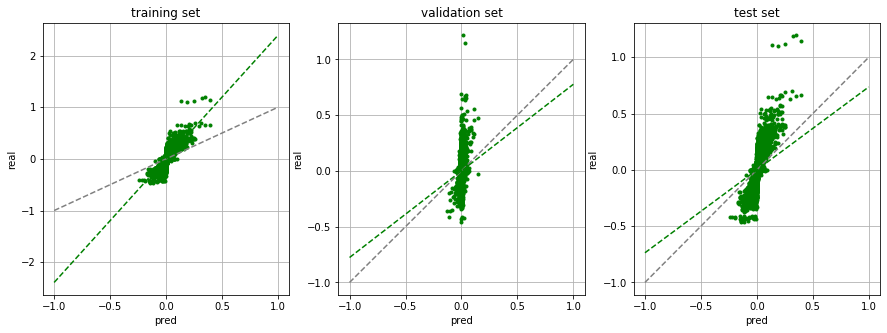

In [306]:
plotTVT(y10_train, y10_train_lgbmpred, 
        y10_validate, y10_validate_lgbmpred,
        y10_test, y10_test_lgbmpred)

In [309]:
# (1544500 - 1300000) * 15/500 = 7335

(np.mean(y10_test[y10_test_lgbmpred.argsort()[-7335:]]), \
np.mean(y10_test[y10_test_lgbmpred.argsort()[:7335]]))

(0.007642298015886615, -0.004987348534718022)

In [350]:
# futher parameter tuning

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'huber'},
    'num_leaves': 100,
    'learning_rate': 0.2,
    'num_boost_round' : 500,
    'feature_fraction': 0.5,
    'bagging_fraction': 1,
    'bagging_freq': 1,
    'verbose': -1
}

In [351]:
lgb5_train = lgb.Dataset(X_train, y5_train)
lgb5_eval = lgb.Dataset(X_validate, y5_validate, reference = lgb5_train)
lgbm5 = lgb.train(params, lgb10_train, valid_sets = lgb5_eval)

[1]	valid_0's huber: 9.80219e-05
[2]	valid_0's huber: 9.79087e-05
[3]	valid_0's huber: 9.76418e-05
[4]	valid_0's huber: 9.75107e-05
[5]	valid_0's huber: 9.74554e-05
[6]	valid_0's huber: 9.72706e-05
[7]	valid_0's huber: 9.72101e-05
[8]	valid_0's huber: 9.71855e-05
[9]	valid_0's huber: 9.70692e-05
[10]	valid_0's huber: 9.69891e-05
[11]	valid_0's huber: 9.69745e-05
[12]	valid_0's huber: 9.67111e-05
[13]	valid_0's huber: 9.66437e-05
[14]	valid_0's huber: 9.64767e-05
[15]	valid_0's huber: 9.63848e-05
[16]	valid_0's huber: 9.63328e-05
[17]	valid_0's huber: 9.63029e-05
[18]	valid_0's huber: 9.62475e-05
[19]	valid_0's huber: 9.62007e-05
[20]	valid_0's huber: 9.61319e-05
[21]	valid_0's huber: 9.59841e-05
[22]	valid_0's huber: 9.59149e-05
[23]	valid_0's huber: 9.58883e-05
[24]	valid_0's huber: 9.58472e-05
[25]	valid_0's huber: 9.5831e-05
[26]	valid_0's huber: 9.58177e-05
[27]	valid_0's huber: 9.57583e-05
[28]	valid_0's huber: 9.57404e-05
[29]	valid_0's huber: 9.56924e-05
[30]	valid_0's huber: 9.

[243]	valid_0's huber: 8.77565e-05
[244]	valid_0's huber: 8.77254e-05
[245]	valid_0's huber: 8.77237e-05
[246]	valid_0's huber: 8.76969e-05
[247]	valid_0's huber: 8.76578e-05
[248]	valid_0's huber: 8.76464e-05
[249]	valid_0's huber: 8.76165e-05
[250]	valid_0's huber: 8.76076e-05
[251]	valid_0's huber: 8.75579e-05
[252]	valid_0's huber: 8.75386e-05
[253]	valid_0's huber: 8.75224e-05
[254]	valid_0's huber: 8.74892e-05
[255]	valid_0's huber: 8.74687e-05
[256]	valid_0's huber: 8.74647e-05
[257]	valid_0's huber: 8.74399e-05
[258]	valid_0's huber: 8.74145e-05
[259]	valid_0's huber: 8.73879e-05
[260]	valid_0's huber: 8.7368e-05
[261]	valid_0's huber: 8.73566e-05
[262]	valid_0's huber: 8.73436e-05
[263]	valid_0's huber: 8.73354e-05
[264]	valid_0's huber: 8.73167e-05
[265]	valid_0's huber: 8.72995e-05
[266]	valid_0's huber: 8.72902e-05
[267]	valid_0's huber: 8.72776e-05
[268]	valid_0's huber: 8.72657e-05
[269]	valid_0's huber: 8.7238e-05
[270]	valid_0's huber: 8.72355e-05
[271]	valid_0's huber:

[483]	valid_0's huber: 8.32885e-05
[484]	valid_0's huber: 8.32795e-05
[485]	valid_0's huber: 8.32719e-05
[486]	valid_0's huber: 8.3262e-05
[487]	valid_0's huber: 8.32333e-05
[488]	valid_0's huber: 8.32147e-05
[489]	valid_0's huber: 8.31961e-05
[490]	valid_0's huber: 8.31712e-05
[491]	valid_0's huber: 8.3153e-05
[492]	valid_0's huber: 8.31363e-05
[493]	valid_0's huber: 8.31133e-05
[494]	valid_0's huber: 8.30891e-05
[495]	valid_0's huber: 8.30738e-05
[496]	valid_0's huber: 8.30469e-05
[497]	valid_0's huber: 8.30473e-05
[498]	valid_0's huber: 8.30331e-05
[499]	valid_0's huber: 8.30178e-05
[500]	valid_0's huber: 8.30063e-05


In [352]:
y5_train_lgbmpred = lgbm5.predict(X_train)
print("Training MSE: " + str(mean_squared_error(y5_train_lgbmpred, y5_train)))
print("Training accuracy: " + str(calc_accuracy(y5_train_lgbmpred, y5_train)))

Training MSE: 0.00017185340954399504
Training accuracy: 0.537196


In [353]:
y5_validate_lgbmpred = lgbm5.predict(X_validate)
print("Validation MSE: " + str(mean_squared_error(y5_validate_lgbmpred, y5_validate)))
print("Validation accuracy: " + str(calc_accuracy(y5_validate_lgbmpred, y5_validate)))

Validation MSE: 0.00016601264750719938
Validation accuracy: 0.535735


In [354]:
y5_test_lgbmpred = lgbm10.predict(X_test)
print("Test MSE: " + str(mean_squared_error(y10_test_lgbmpred, y5_test)))
print("Test accuracy: " + str(calc_accuracy(y10_test_lgbmpred, y5_test)))

Test MSE: 0.00019025160984753147
Test accuracy: 0.516319018404908


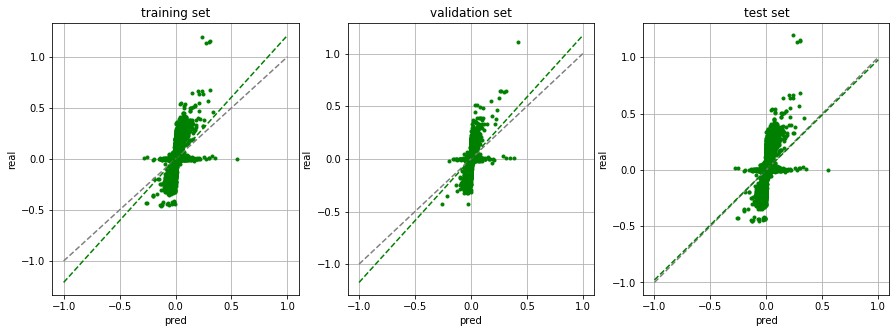

In [355]:
plotTVT(y5_train, y5_train_lgbmpred, 
        y5_validate, y5_validate_lgbmpred,
        y5_test, y5_test_lgbmpred)

In [346]:
# (1544500 - 1300000) * 15/500 = 7335

(np.mean(y5_test[y5_test_lgbmpred.argsort()[-7335:]]), \
np.mean(y5_test[y5_test_lgbmpred.argsort()[:7335]]))

(0.0035456406294905444, -0.0017452321832910453)

# 速度对比

In [291]:
t = time.time()
lgbm10.predict(X_test[:500])
print(time.time() - t)

0.003198862075805664


In [292]:
t = time.time()
gb10.predict(X_test[:500])
print(time.time() - t)

0.0007538795471191406


# 模型保存

In [370]:
alphasbasic = pd.read_csv('data/alphas23.csv').set_index('Unnamed: 0')

In [371]:
import lightgbm as lgb

shuf = shuffle(data, random_state = 2020)

y10_train = data_shuf['obj10'].iloc[:1500000].values
y5_train = data_shuf['obj5'].iloc[:1500000].values
X_train = data_shuf.iloc[:1500000, 3:-2].values

y10_validate = data_shuf['obj10'].iloc[1500000:].values
y5_validate = data_shuf['obj5'].iloc[1500000:].values
X_train = data_shuf.iloc[1500000:, 3:-2].values

NameError: name 'data' is not defined

In [365]:
params10 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'huber'},
    'num_leaves': 100,
    'learning_rate': 0.2,
    'num_boost_round' : 500,
    'feature_fraction': 0.5,
    'bagging_fraction': 1,
    'bagging_freq': 1,
    'verbose': -1
}

lgb10_train = lgb.Dataset(X_train, y10_train)
lgb10_eval = lgb.Dataset(X_validate, y10_validate, reference = lgb10_train)
lgbm10 = lgb.train(params10, lgb10_train, valid_sets = lgb10_eval)
pickle.dump(lgbm10, open('Models/lgbm10.sav', 'wb'))

params5 = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'huber'},
    'num_leaves': 100,
    'learning_rate': 0.2,
    'num_boost_round' : 500,
    'feature_fraction': 0.5,
    'bagging_fraction': 1,
    'bagging_freq': 1,
    'verbose': -1
}

lgb5_train = lgb.Dataset(X_train, y5_train)
lgb5_eval = lgb.Dataset(X_validate, y5_validate, reference = lgb5_train)
lgbm5 = lgb.train(params5, lgb5_train, valid_sets = lgb5_eval)
pickle.dump(lgbm5, open('Models/lgbm5.sav', 'wb'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm-3.2.1-py3.6-macosx-10.9-x86_64.egg/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's huber: 0.000195613
[2]	valid_0's huber: 0.000195488
[3]	valid_0's huber: 0.000195446
[4]	valid_0's huber: 0.000195413
[5]	valid_0's huber: 0.000195345
[6]	valid_0's huber: 0.00019524
[7]	valid_0's huber: 0.000195164
[8]	valid_0's huber: 0.000195091
[9]	valid_0's huber: 0.000195064
[10]	valid_0's huber: 0.000195062
[11]	valid_0's huber: 0.000195055
[12]	valid_0's huber: 0.000195006
[13]	valid_0's huber: 0.000194995
[14]	valid_0's huber: 0.000194895
[15]	valid_0's huber: 0.000194806
[16]	valid_0's huber: 0.000194762
[17]	valid_0's huber: 0.000194771
[18]	valid_0's huber: 0.000194747
[19]	valid_0's huber: 0.000194749
[20]	valid_0's huber: 0.000194752
[21]	valid_0's huber: 0.000194738
[22]	valid_0's huber: 0.000194748
[23]	valid_0's huber: 0.000194753
[24]	valid_0's huber: 0.000194755
[25]	valid_0's huber: 0.000194764
[26]	valid_0's huber: 0.000194756
[27]	valid_0's huber: 0.000194755
[28]	valid_0's huber: 0.000194769
[29]	valid_0's huber: 0.000194688
[30]	valid_0's huber: 0.

[251]	valid_0's huber: 0.00019281
[252]	valid_0's huber: 0.000192797
[253]	valid_0's huber: 0.000192801
[254]	valid_0's huber: 0.000192815
[255]	valid_0's huber: 0.000192756
[256]	valid_0's huber: 0.000192748
[257]	valid_0's huber: 0.000192722
[258]	valid_0's huber: 0.000192739
[259]	valid_0's huber: 0.000192726
[260]	valid_0's huber: 0.000192729
[261]	valid_0's huber: 0.000192731
[262]	valid_0's huber: 0.000192734
[263]	valid_0's huber: 0.000192736
[264]	valid_0's huber: 0.000192738
[265]	valid_0's huber: 0.000192742
[266]	valid_0's huber: 0.000192749
[267]	valid_0's huber: 0.000192753
[268]	valid_0's huber: 0.00019275
[269]	valid_0's huber: 0.00019276
[270]	valid_0's huber: 0.000192755
[271]	valid_0's huber: 0.000192765
[272]	valid_0's huber: 0.000192767
[273]	valid_0's huber: 0.000192775
[274]	valid_0's huber: 0.000192782
[275]	valid_0's huber: 0.000192757
[276]	valid_0's huber: 0.000192749
[277]	valid_0's huber: 0.000192716
[278]	valid_0's huber: 0.00019272
[279]	valid_0's huber: 0

[496]	valid_0's huber: 0.000191481
[497]	valid_0's huber: 0.000191468
[498]	valid_0's huber: 0.000191467
[499]	valid_0's huber: 0.00019147
[500]	valid_0's huber: 0.000191469
[1]	valid_0's huber: 9.82118e-05
[2]	valid_0's huber: 9.8194e-05
[3]	valid_0's huber: 9.81946e-05
[4]	valid_0's huber: 9.81909e-05
[5]	valid_0's huber: 9.81884e-05
[6]	valid_0's huber: 9.81805e-05
[7]	valid_0's huber: 9.8129e-05
[8]	valid_0's huber: 9.8127e-05
[9]	valid_0's huber: 9.81289e-05
[10]	valid_0's huber: 9.81153e-05
[11]	valid_0's huber: 9.81151e-05
[12]	valid_0's huber: 9.81113e-05
[13]	valid_0's huber: 9.81018e-05
[14]	valid_0's huber: 9.80981e-05
[15]	valid_0's huber: 9.80818e-05
[16]	valid_0's huber: 9.80998e-05
[17]	valid_0's huber: 9.81089e-05
[18]	valid_0's huber: 9.8121e-05
[19]	valid_0's huber: 9.8124e-05
[20]	valid_0's huber: 9.81151e-05
[21]	valid_0's huber: 9.81134e-05
[22]	valid_0's huber: 9.80966e-05
[23]	valid_0's huber: 9.8102e-05
[24]	valid_0's huber: 9.80907e-05
[25]	valid_0's huber: 9.8

[234]	valid_0's huber: 9.81773e-05
[235]	valid_0's huber: 9.81855e-05
[236]	valid_0's huber: 9.81848e-05
[237]	valid_0's huber: 9.81949e-05
[238]	valid_0's huber: 9.81901e-05
[239]	valid_0's huber: 9.81913e-05
[240]	valid_0's huber: 9.81928e-05
[241]	valid_0's huber: 9.8192e-05
[242]	valid_0's huber: 9.81924e-05
[243]	valid_0's huber: 9.81925e-05
[244]	valid_0's huber: 9.81945e-05
[245]	valid_0's huber: 9.82007e-05
[246]	valid_0's huber: 9.81879e-05
[247]	valid_0's huber: 9.81888e-05
[248]	valid_0's huber: 9.81903e-05
[249]	valid_0's huber: 9.81901e-05
[250]	valid_0's huber: 9.81889e-05
[251]	valid_0's huber: 9.81697e-05
[252]	valid_0's huber: 9.81531e-05
[253]	valid_0's huber: 9.81566e-05
[254]	valid_0's huber: 9.81494e-05
[255]	valid_0's huber: 9.81605e-05
[256]	valid_0's huber: 9.81762e-05
[257]	valid_0's huber: 9.81691e-05
[258]	valid_0's huber: 9.8173e-05
[259]	valid_0's huber: 9.81656e-05
[260]	valid_0's huber: 9.81623e-05
[261]	valid_0's huber: 9.81656e-05
[262]	valid_0's huber:

[482]	valid_0's huber: 9.82746e-05
[483]	valid_0's huber: 9.8275e-05
[484]	valid_0's huber: 9.82823e-05
[485]	valid_0's huber: 9.8286e-05
[486]	valid_0's huber: 9.82717e-05
[487]	valid_0's huber: 9.827e-05
[488]	valid_0's huber: 9.82641e-05
[489]	valid_0's huber: 9.82433e-05
[490]	valid_0's huber: 9.82395e-05
[491]	valid_0's huber: 9.82403e-05
[492]	valid_0's huber: 9.82394e-05
[493]	valid_0's huber: 9.8245e-05
[494]	valid_0's huber: 9.82372e-05
[495]	valid_0's huber: 9.8234e-05
[496]	valid_0's huber: 9.82392e-05
[497]	valid_0's huber: 9.82442e-05
[498]	valid_0's huber: 9.82455e-05
[499]	valid_0's huber: 9.82499e-05
[500]	valid_0's huber: 9.82483e-05
